In [1]:
!pip install xlrd
!pip install adversarial-robustness-toolbox
!pip install -U imbalanced-learn
!pip install shap
!pip install memory-profiler


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.3
    Uninstalling imbalanced-learn-0.12.3:
      Successfully uninstalled imbalanced-learn-0.12.3
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-privacy==0.5.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import sys
import os
import pandas as pd
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE,SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Input
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.constraints import MaxNorm

from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier

tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()


2024-10-04 21:00:30.736529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 21:00:31.719627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
class PPSMOTE:

    def __init__(self, k_neighbors=2, random_state=None):
        if isinstance(k_neighbors, int):
            if k_neighbors > 0:
                self.k_neighbors = k_neighbors
            else:
                raise ValueError('k_neighbors should be integer greater than 0')
        else:
            raise TypeError('Expect integer for k_neighbors')

        if isinstance(random_state, int):
            np.random.seed(random_state)

    def _laplaceNoise(self, mu, b, size):
        return np.random.laplace(mu, b, size)

    def _randomize(self, samples, target_size):
        length = samples.shape[0]
        idx = np.random.randint(length, size=target_size)
        return samples[idx, :]

    def _populate(self, idx, nnarray, minority_samples, noise):
        noise = self._laplaceNoise(0, noise, self.numattrs)

        for attr in range(self.numattrs):
            nn = np.random.randint(low=0, high=self.k_neighbors)
            dif = (minority_samples[nnarray[nn]][attr] - minority_samples[idx][attr])
            self.synthetic[self.newidx][attr] = (minority_samples[idx][attr] + noise[attr] * dif)
        self.newidx += 1

    def oversample(self, samples, labels, noise, merge=False):
      # Convert to numpy array if list is passed
      if isinstance(samples, list):
          self.samples = np.array(samples)
      elif isinstance(samples, np.ndarray):
          self.samples = samples
      else:
          raise TypeError('Expect a built-in list or an ndarray for samples')

      if isinstance(labels, list):
          labels = np.array(labels)

      # Find class counts for all classes
      class_counts = Counter(labels)
      majority_class = max(class_counts, key=class_counts.get)
      majority_size = class_counts[majority_class]

      # Initialize lists to store synthetic samples and labels
      synthetic_samples_list = []
      synthetic_labels_list = []

      # Loop through each class, oversampling minority classes
      for class_label, class_size in class_counts.items():
          if class_size < majority_size:
              # This is a minority class, oversample it
              minority_samples = self.samples[labels == class_label]
              self.numattrs = minority_samples.shape[1]

              # Calculate how many synthetic samples are needed to balance the class
              synthetic_needed = majority_size - class_size
              self.synthetic = np.empty(shape=(synthetic_needed, self.numattrs))
              self.newidx = 0

              # Nearest neighbor calculation on the minority samples
              self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors)
              self.nbrs.fit(minority_samples)
              self.knn = self.nbrs.kneighbors()[1]

              # Populate synthetic samples for the minority class
              for _ in range(synthetic_needed):
                  idx = np.random.randint(low=0, high=minority_samples.shape[0])
                  nnarray = self.knn[idx]
                  self._populate(idx, nnarray, minority_samples, noise)

              # Store the synthetic samples and their labels
              synthetic_samples_list.append(self.synthetic)
              synthetic_labels_list.append([class_label] * self.synthetic.shape[0])

      # Combine synthetic samples for all minority classes
      if synthetic_samples_list:
          synthetic_samples = np.vstack(synthetic_samples_list)
          synthetic_labels = np.concatenate(synthetic_labels_list)

      # Return the oversampled data
      if merge and synthetic_samples_list:
          # Merge the synthetic samples with the original dataset (both minority and majority)
          return np.concatenate((self.samples, synthetic_samples)), np.concatenate((labels, synthetic_labels))
      elif merge and not synthetic_samples_list:
          return self.samples, labels  # No oversampling was needed
      else:
          # Only return synthetic minority samples if there are any
          if synthetic_samples_list:
              return synthetic_samples, synthetic_labels
          else:
              return np.array([]), np.array([])  # No synthetic samples generated



In [5]:
dataset = pd.read_csv(r"RT_IOT2022")
label_encoder_df = LabelEncoder()
dataset['proto'] = label_encoder_df.fit_transform(dataset['proto'])
dataset['service'] = label_encoder_df.fit_transform(dataset['service'])
dataset['Attack_type'] = label_encoder_df.fit_transform(dataset['Attack_type'])
#dataset = dataset.dropna()
dataset.drop(columns=['Unnamed: 0'], inplace=True)
dataset['Attack_type'].unique()
#print(dataset)
dataset.head()

id.orig_p  id.resp_p  proto  service  flow_duration  fwd_pkts_tot  \
0      38667       1883      1        5      32.011598             9   
1      51143       1883      1        5      31.883584             9   
2      44761       1883      1        5      32.124053             9   
3      60893       1883      1        5      31.961063             9   
4      51087       1883      1        5      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

   active.std      idle.min      idle.max      idle.tot      idle.avg  \
0         0.0  2.972918e+07  2.972918e+07  2.972918e+07  2.972918e+07   
1         0.0  2.985528e+07  2.985528e+07  2.985528e+07  2.985528e+07   
2         0.0  2.984215e+07  2.984215e+07  2.984215e+07  2.984215e+07   
3         0.0  2.991377e+07  2.991377e+07  2.991377e+07  2.991377e+07   
4         0.0  2.981470e+07  2.981470e+07  2.981470e+07  2.981470e+07   

   idle.std  fwd_init_window_size  bwd_init_window_size  fwd_last_window_size  \
0       0.0                 64240                 26847                   502   
1       0.0                 64240                 26847                   502   
2       0.0                 64240                 26847                   502   
3       0.0                 64240                 26847                   502   
4       0.0                 64240                 26847                   502   

   Attack_type  
0            3  
1            3  
2            3  
3            3  
4            3  

[5 rows x 84 columns]

In [7]:
X = dataset.to_numpy()[:,:83]
y = dataset.to_numpy()[:,-1]
unique_values = np.unique(y)
print("Unique values:", unique_values)

Unique values: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


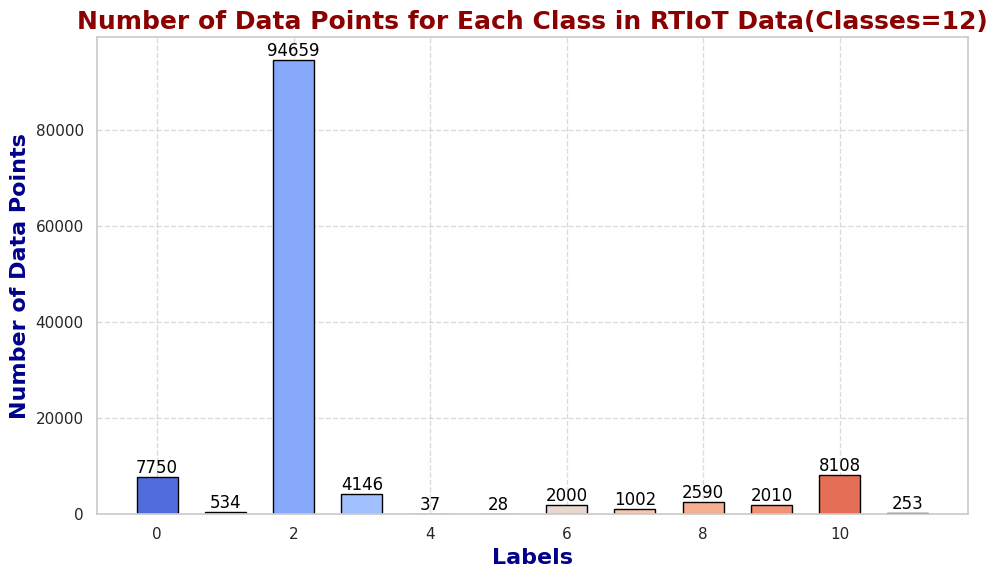

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set seaborn style for better aesthetics
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 14})  # Increase font size

# Step 2: Get unique labels and their counts
unique_labels, label_counts = np.unique(y, return_counts=True)

# Step 3: Create a gradient color palette based on the number of labels
colors = sns.color_palette("coolwarm", len(unique_labels))

# Step 4: Plot the bar chart with enhanced style
plt.figure(figsize=(10, 6))
bars = plt.bar(unique_labels, label_counts, color=colors, width=0.6, edgecolor='black')

# Step 5: Add labels and title with improved styling
plt.xlabel('Labels', fontsize=16, fontweight='bold', color='darkblue')
plt.ylabel('Number of Data Points', fontsize=16, fontweight='bold', color='darkblue')
plt.title('Number of Data Points for Each Class in RTIoT Data(Classes=12)', fontsize=18, fontweight='bold', color='darkred')

# Step 6: Adding label values on top of the bars
for bar, count in zip(bars, label_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, str(count), ha='center', va='bottom', fontsize=12, color='black')

# Step 7: Enhance layout and add grid for clarity
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Step 8: Save the fancy plot as a PNG file
plt.savefig('Class12-Imbalance_graph.png', dpi=300, bbox_inches='tight')

# Step 9: Show the plot
plt.show()


In [39]:


# Initialize the resamplers
smote = SMOTE()
adasyn = ADASYN()
svm_smote = SVMSMOTE()
borderline_smote = BorderlineSMOTE()

# Function to measure the runtime of a resampler
def measure_runtime(resampler, X, y):
    start_time = time.time()
    x_resampled, y_resampled = resampler.fit_resample(X, y)
    end_time = time.time()
    return end_time - start_time

# Measure runtime for each method
runtime_smote = measure_runtime(smote, X, y)
print(f"SMOTE runtime: {runtime_smote:.4f} seconds")
runtime_adasyn = measure_runtime(adasyn, X, y)
print(f"ADASYN runtime: {runtime_adasyn:.4f} seconds")
#runtime_svm_smote = measure_runtime(svm_smote, X, y)
#print(f"SVM SMOTE runtime: {runtime_svm_smote:.4f} seconds")
runtime_borderline_smote = measure_runtime(borderline_smote, X, y)
print(f"Borderline SMOTE runtime: {runtime_borderline_smote:.4f} seconds")


SMOTE runtime: 2.6085 seconds
ADASYN runtime: 4.9498 seconds
Borderline SMOTE runtime: 6.2897 seconds


In [6]:
import time
smote = PPSMOTE(k_neighbors=5, random_state=42)
start_time = time.time()
X_train_3, y_train_3 = smote.oversample(X, y, 0.025, merge=True)
end_time = time.time()

# Calculate runtime
runtime_in_seconds = end_time - start_time
print(f"PP-SMOTE resampling runtime: {runtime_in_seconds:.4f} seconds")

X_train_3.shape

KeyboardInterrupt: 

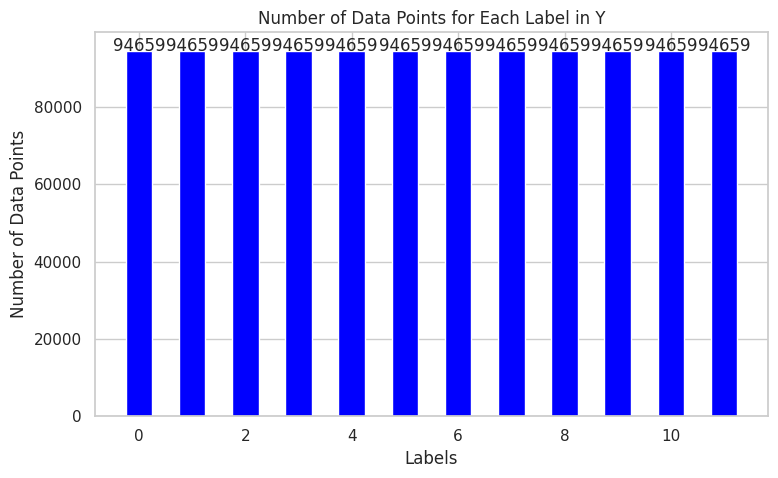

In [8]:
# Get unique labels in y
# Get unique labels and their counts
unique_labels, label_counts = np.unique(y_train_3, return_counts=True)

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, label_counts, color='blue', width=0.5)

# Labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Label in Y')

# Adding label values on top of the bars
for i, count in enumerate(label_counts):
    plt.text(unique_labels[i], count + 0.1, str(count), ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


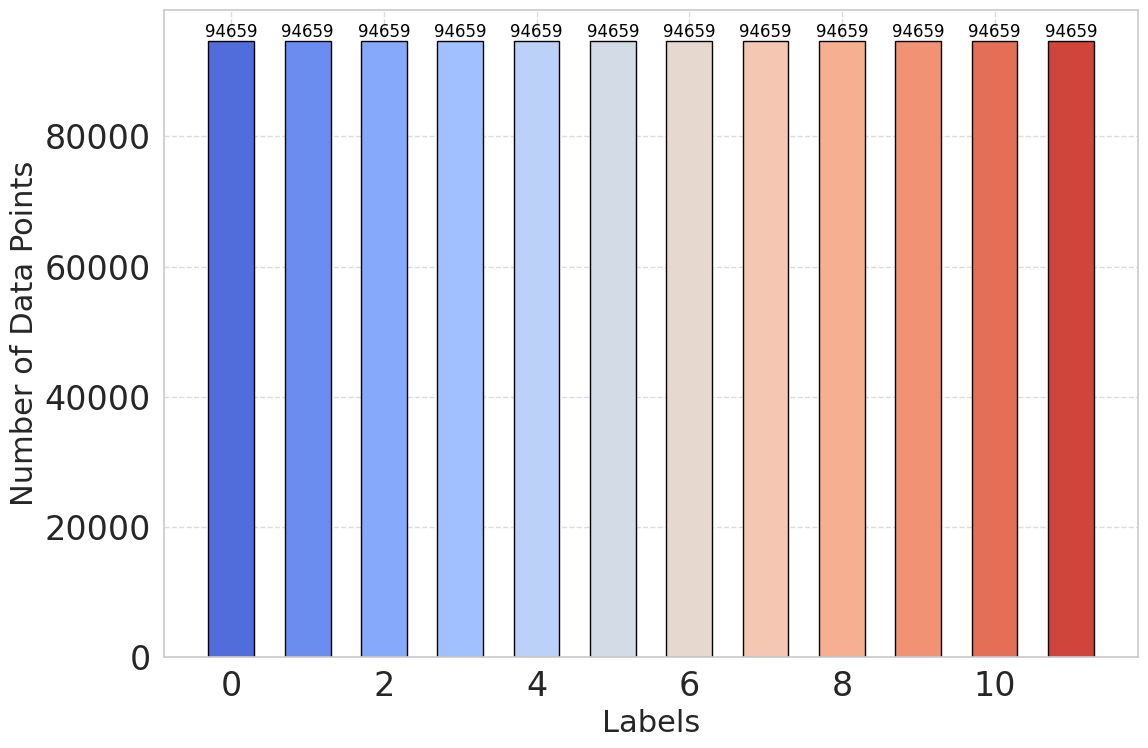

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Set seaborn style for better aesthetics
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24})  

# Step 2: Get unique labels and their counts
unique_labels, label_counts = np.unique(y_train_3, return_counts=True)

# Step 3: Create a gradient color palette based on the number of labels
colors = sns.color_palette("coolwarm", len(unique_labels))

# Step 4: Plot the bar chart with enhanced style
plt.figure(figsize=(12, 8))
bars = plt.bar(unique_labels, label_counts, color=colors, width=0.6, edgecolor='black')

# Step 5: Add labels and title with improved styling
plt.xlabel('Labels', fontsize=22)
plt.ylabel('Number of Data Points', fontsize=22)
plt.title('')

# Step 6: Adding label values on top of the bars
for bar, count in zip(bars, label_counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, str(count), ha='center', va='bottom', fontsize=12, color='black')

# Step 7: Enhance layout and add grid for clarity
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Step 8: Save the fancy plot as a PNG file
plt.savefig('Class12-Balance_graph.png', dpi=300, bbox_inches='tight')

# Step 9: Show the plot
plt.show()


In [22]:
# Concatenate the arrays along the column axis (axis=1):
concatenated_array = np.concatenate((X_train_3[:, 6:10], y_train_3[:, np.newaxis]), axis=1)

# Create a DataFrame from the concatenated array:
df_pair = pd.DataFrame(concatenated_array, columns=list(range(4)) + ['class'])  # Assign column names

print(df_pair.head())


     0    1    2         3  class
0  5.0  3.0  3.0  0.281148    3.0
1  5.0  3.0  3.0  0.282277    3.0
2  5.0  3.0  3.0  0.280164    3.0
3  5.0  3.0  3.0  0.281593    3.0
4  5.0  3.0  3.0  0.282111    3.0


In [15]:
# Select columns 2 to 5 from array1
selected_columns = X_train_3[:, 2:6]  # Note: Python indexing starts from 0

# Concatenate the selected columns and the class array
combined_array = np.concatenate((selected_columns, y_train_3.reshape(-1, 1)), axis=1)

# Create a DataFrame from the combined array with column names
column_names = ['proto', 'service', 'flow_duration','fwd_pkts_tot','attack_type']
df_selected = pd.DataFrame(combined_array, columns=column_names)
print(df_selected.head())

   proto  service  flow_duration  fwd_pkts_tot  attack_type
0    1.0      5.0      32.011598           9.0          3.0
1    1.0      5.0      31.883584           9.0          3.0
2    1.0      5.0      32.124053           9.0          3.0
3    1.0      5.0      31.961063           9.0          3.0
4    1.0      5.0      31.902362           9.0          3.0


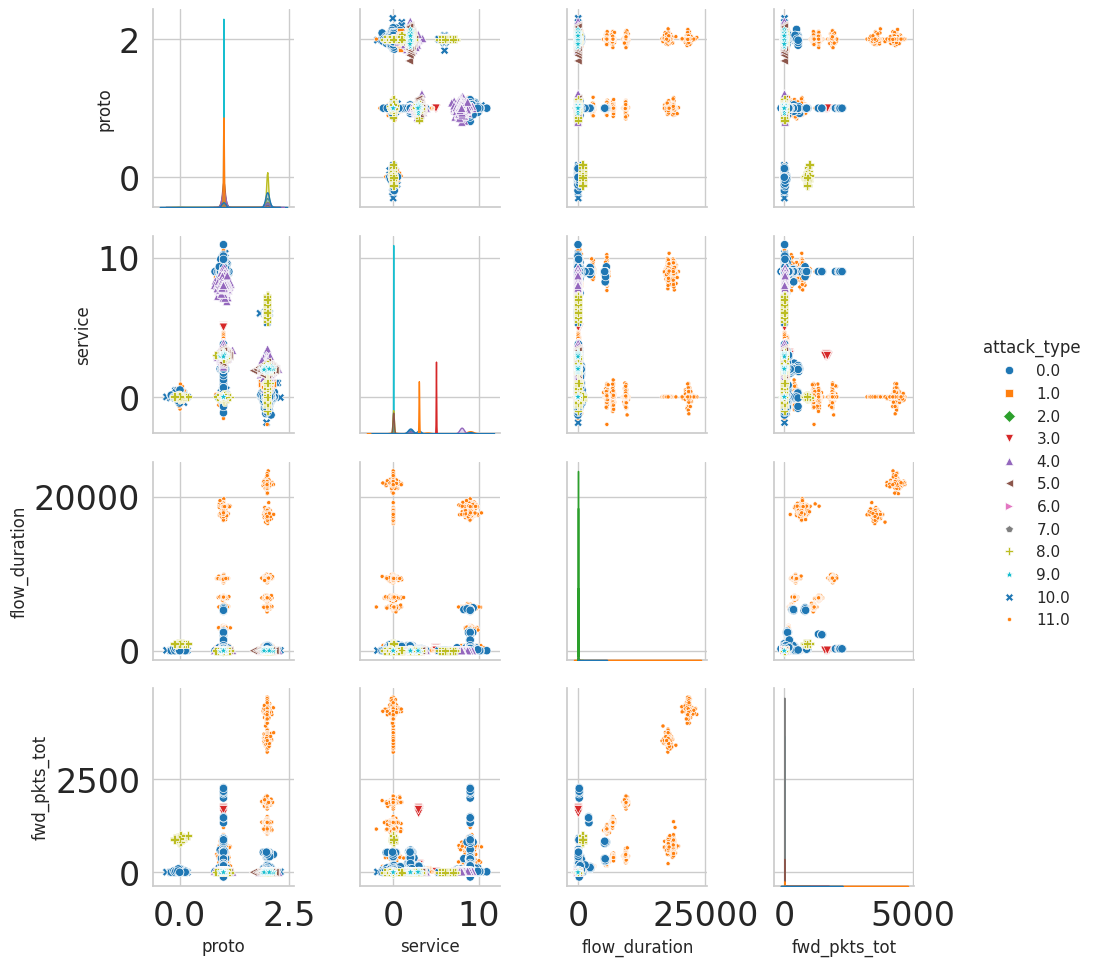

In [19]:
import seaborn as sns

plt.rcParams.update({'font.size': 24, 'xtick.labelsize': 24, 'ytick.labelsize': 24})  
palette = sns.color_palette("tab10", n_colors=12)
sns.pairplot(df_selected, hue='attack_type', diag_kind='kde', palette=palette, markers=['o', 's', 'D', 'v', '^', '<', '>', 'p', 'P', '*', 'X','.'])
#sns.pairplot(df_selected, hue='attack_type')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
#plt.xlabel(fontsize=24)
#plt.ylabel(fontsize=24)
plt.savefig('pair_plot.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG
plt.show()

/tmp/ipykernel_765288/13078986.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_765288/13078986.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight')
/home/dgxuser49/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


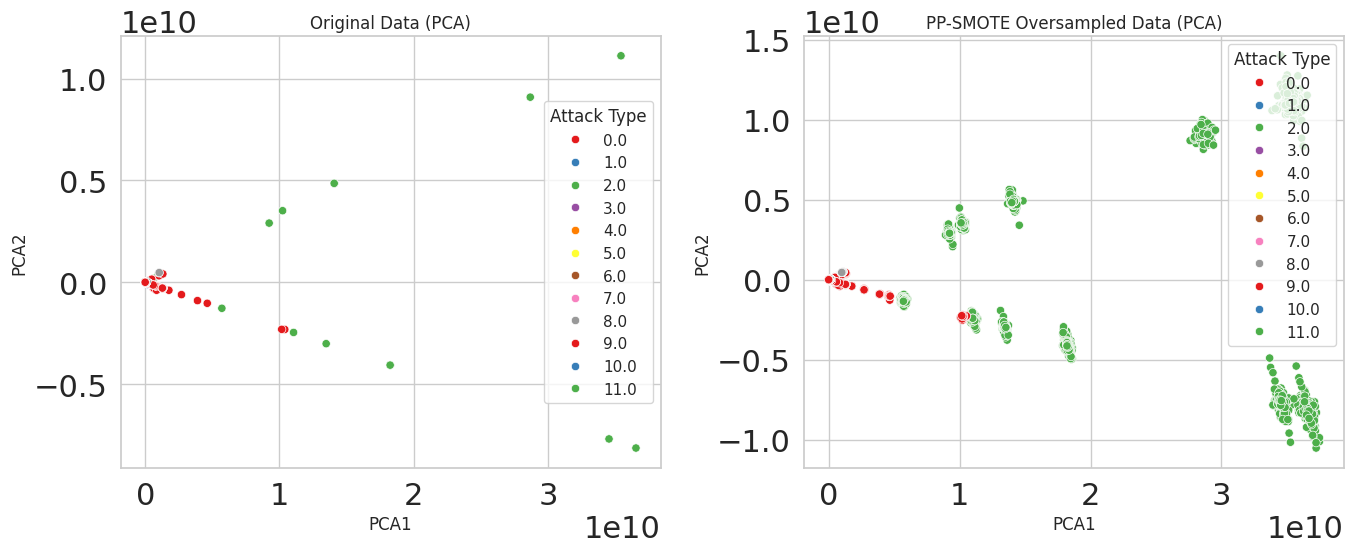

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Assuming you already have X, X_res, y, y_res from SMOTE

# Apply PCA for dimensionality reduction (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_res_pca = pca.transform(X_train_3)

# Create DataFrames for plotting
df_original = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_original['Attack Type'] = y

df_resampled = pd.DataFrame(X_res_pca, columns=['PCA1', 'PCA2'])
df_resampled['Attack Type'] = y_train_3

# Plot PCA results in two subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot the original data (PCA reduced)
sns.scatterplot(data=df_original, x='PCA1', y='PCA2', hue='Attack Type', ax=ax[0], palette='Set1')
ax[0].set_title('Original Data (PCA)')

# Plot the SMOTE-resampled data (PCA reduced)
sns.scatterplot(data=df_resampled, x='PCA1', y='PCA2', hue='Attack Type', ax=ax[1], palette='Set1')
ax[1].set_title('PP-SMOTE Oversampled Data (PCA)')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300, bbox_inches='tight') 
# Show the plots
plt.show()


In [7]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_3)

# Visualize the results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_3)
plt.title("t-SNE Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

KeyboardInterrupt: 

/tmp/ipykernel_765288/3989212189.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['proto'], label=f'Class {target_class}')


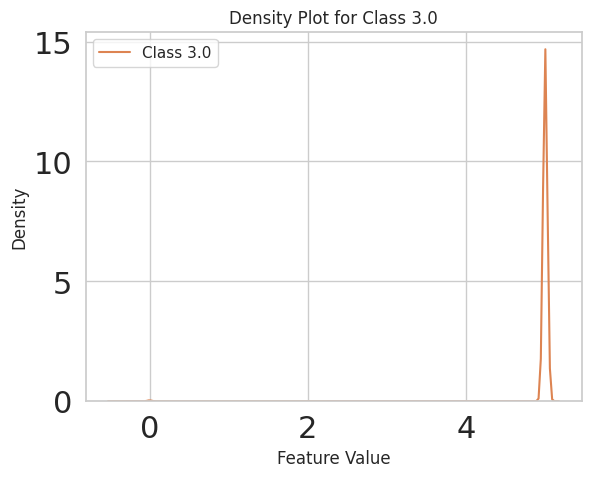

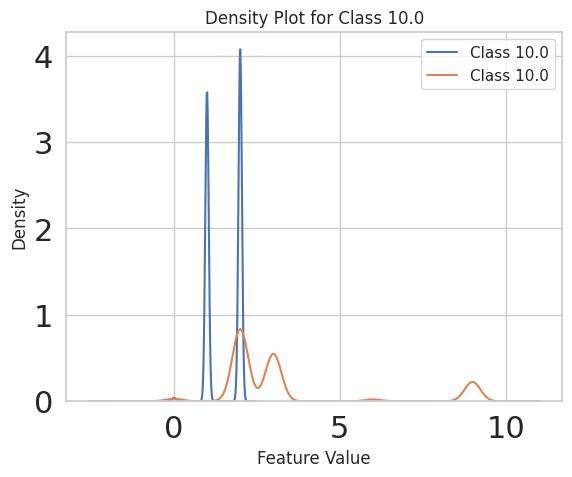

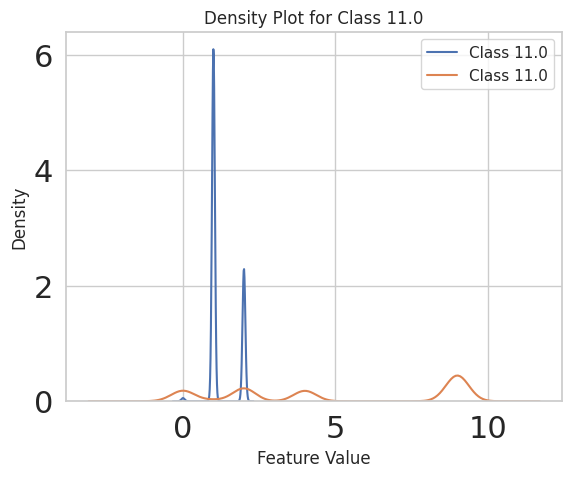

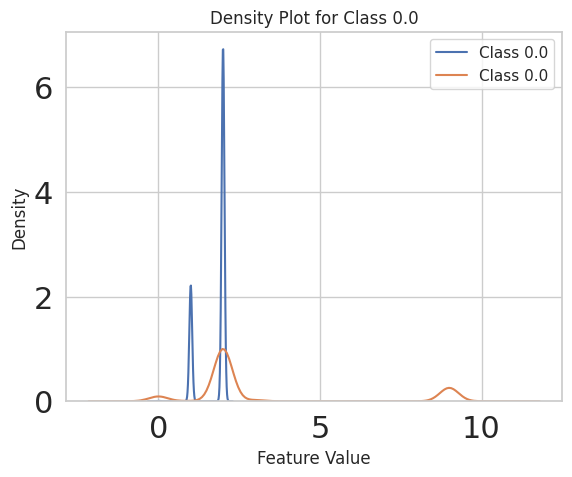

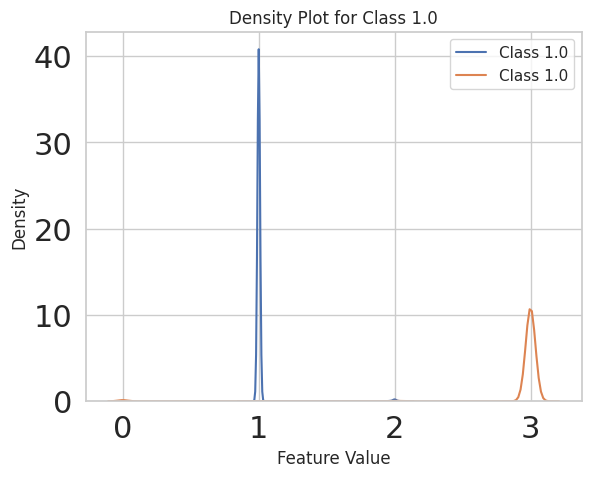

/tmp/ipykernel_765288/3989212189.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['proto'], label=f'Class {target_class}')
/tmp/ipykernel_765288/3989212189.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['service'], label=f'Class {target_class}')


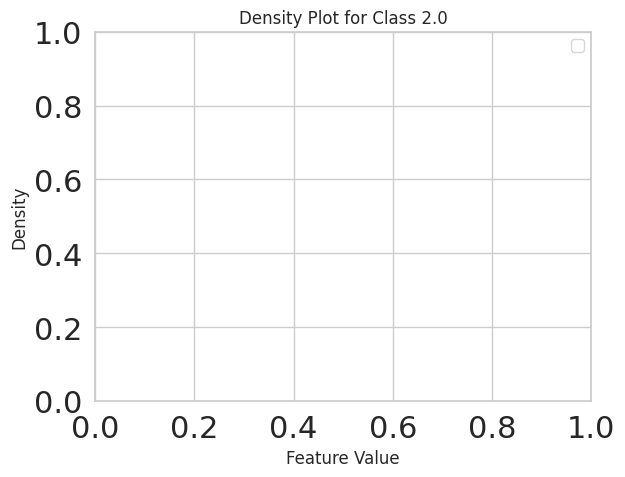

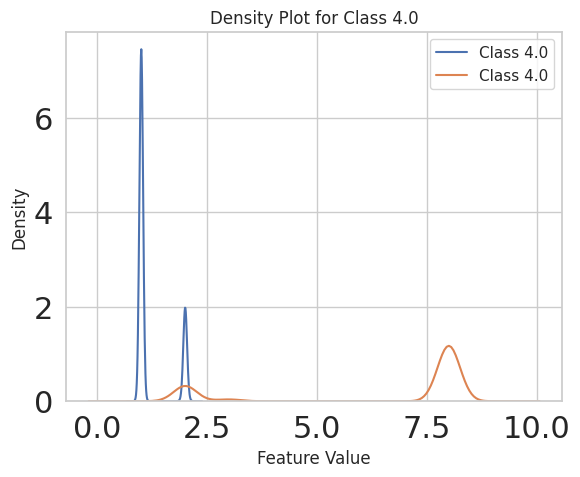

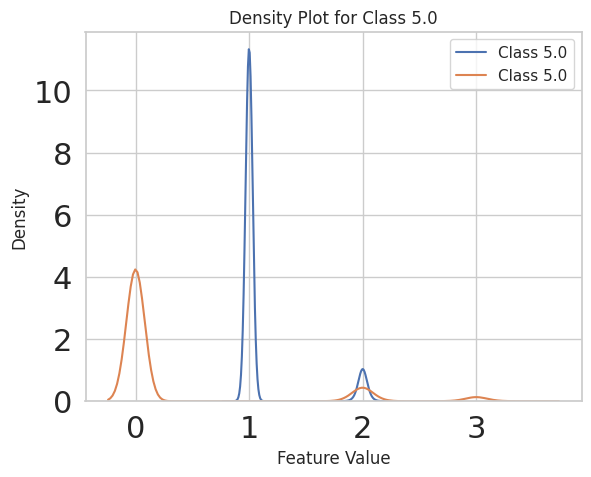

/tmp/ipykernel_765288/3989212189.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['proto'], label=f'Class {target_class}')
/tmp/ipykernel_765288/3989212189.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['service'], label=f'Class {target_class}')


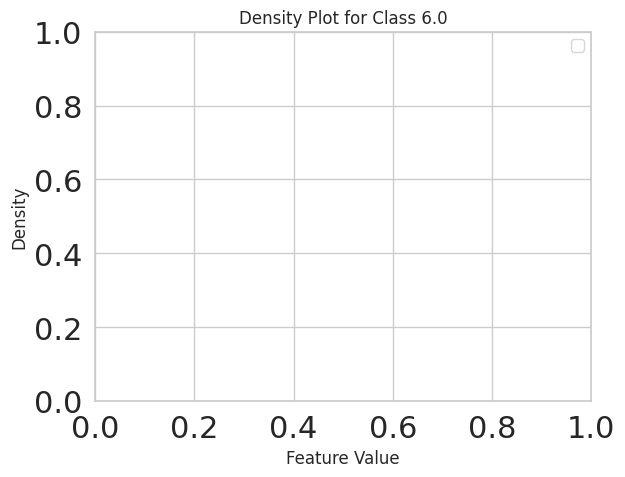

/tmp/ipykernel_765288/3989212189.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['proto'], label=f'Class {target_class}')
/tmp/ipykernel_765288/3989212189.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=class_data['service'], label=f'Class {target_class}')


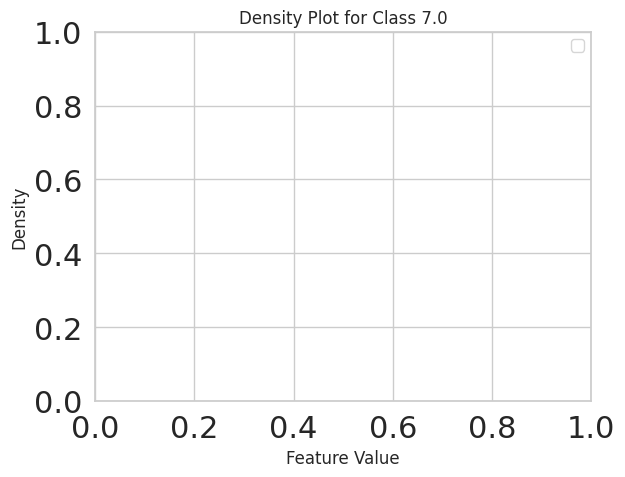

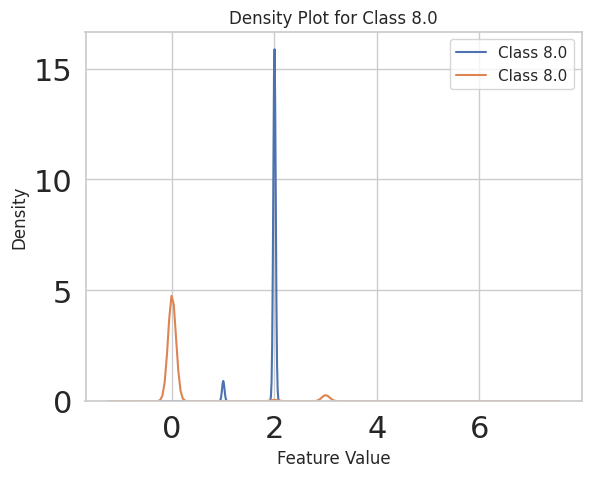

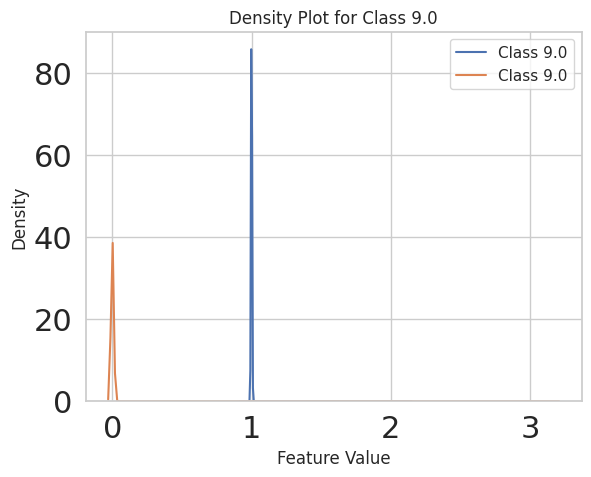

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data' with columns 'target' (class labels) and 'feature1', 'feature2', etc. (features)

# Create a separate plot for each class
for target_class in df_selected['attack_type'].unique():
    class_data = df_selected[df_selected['attack_type'] == target_class]
    sns.kdeplot(data=class_data['proto'], label=f'Class {target_class}')
    sns.kdeplot(data=class_data['service'], label=f'Class {target_class}')
    # Add more features as needed
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    plt.title(f'Density Plot for Class {target_class}')
    plt.legend()
    plt.show()

/tmp/ipykernel_106534/3735900953.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataset, x='proto', hue='Attack_type', fill=True, common_norm=False, alpha=0.4, label='Original')
/tmp/ipykernel_106534/3735900953.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_selected, x='Feature3', hue='class', fill=True, common_norm=False, alpha=0.4, label='PP-SMOTE')


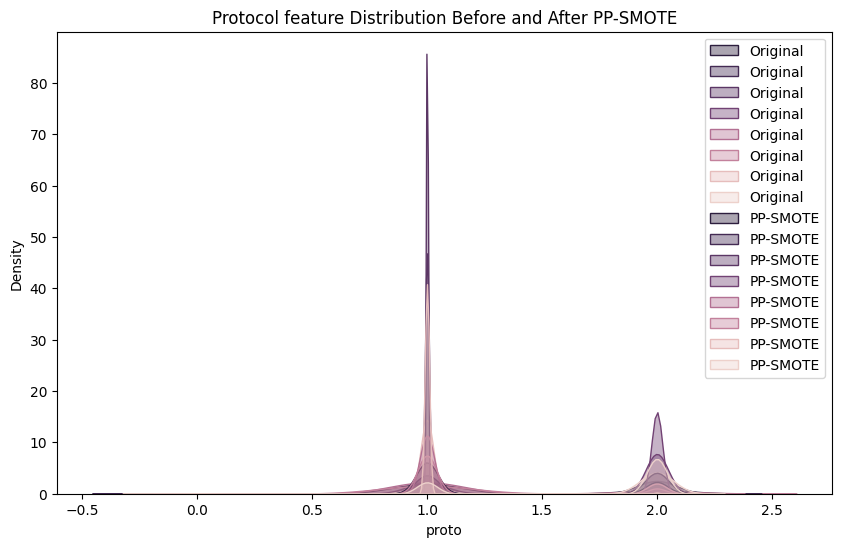

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for feature 'feature_1'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=dataset, x='proto', hue='Attack_type', fill=True, common_norm=False, alpha=0.4, label='Original')
sns.kdeplot(data=df_selected, x='Feature3', hue='class', fill=True, common_norm=False, alpha=0.4, label='PP-SMOTE')
plt.title('Protocol feature Distribution Before and After PP-SMOTE')
plt.legend()
plt.savefig('kde-plot.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG
plt.show()


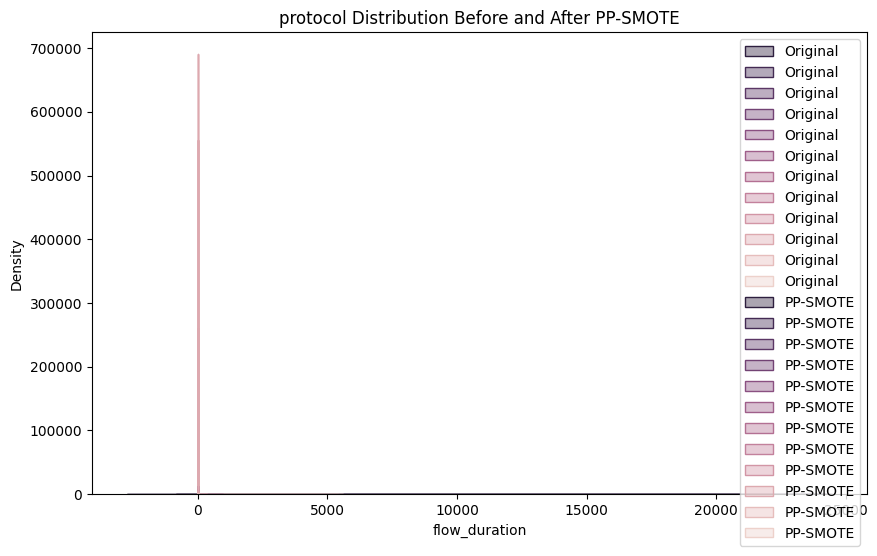

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for feature 'feature_1'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=dataset, x='flow_duration', hue='Attack_type', fill=True, common_norm=False, alpha=0.4, label='Original')
sns.kdeplot(data=df_selected, x='Feature5', hue='class', fill=True, common_norm=False, alpha=0.4, label='PP-SMOTE')
plt.title('Flow_Duration feature Distribution Before and After PP-SMOTE')
plt.legend()
plt.savefig('kde-plot-flow.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG
plt.show()


/tmp/ipykernel_106534/1039794127.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dataset, x='service', hue='Attack_type', fill=True, common_norm=False, alpha=0.4, label='Original')
/tmp/ipykernel_106534/1039794127.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_selected, x='Feature4', hue='class', fill=True, common_norm=False, alpha=0.4, label='PP-SMOTE')


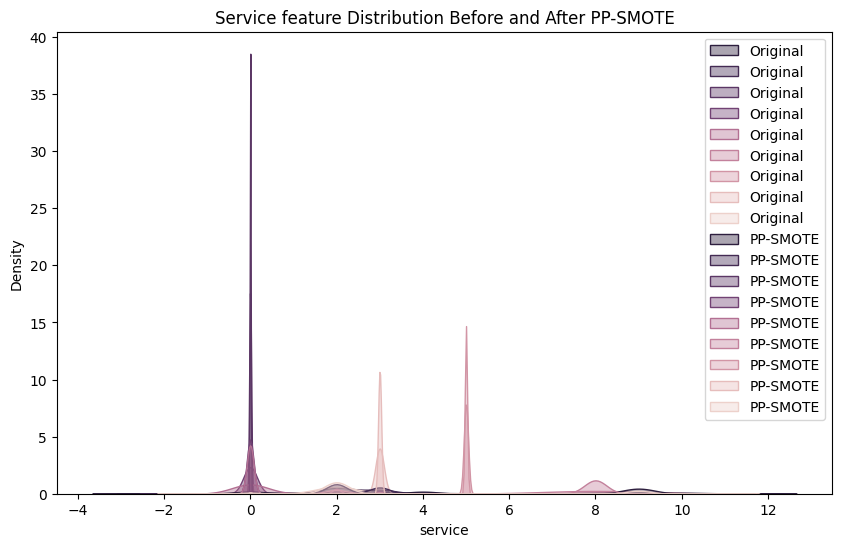

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example for feature 'feature_1'
plt.figure(figsize=(10, 6))
sns.kdeplot(data=dataset, x='service', hue='Attack_type', fill=True, common_norm=False, alpha=0.4, label='Original')
sns.kdeplot(data=df_selected, x='Feature4', hue='class', fill=True, common_norm=False, alpha=0.4, label='PP-SMOTE')
plt.title('Service feature Distribution Before and After PP-SMOTE')
plt.legend()
plt.savefig('kde-plot-service.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG
plt.show()


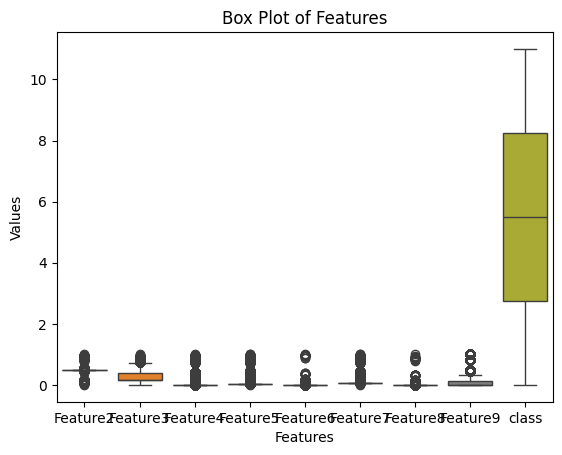

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
sns.boxplot(data=df_selected)
plt.title('Box Plot of Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

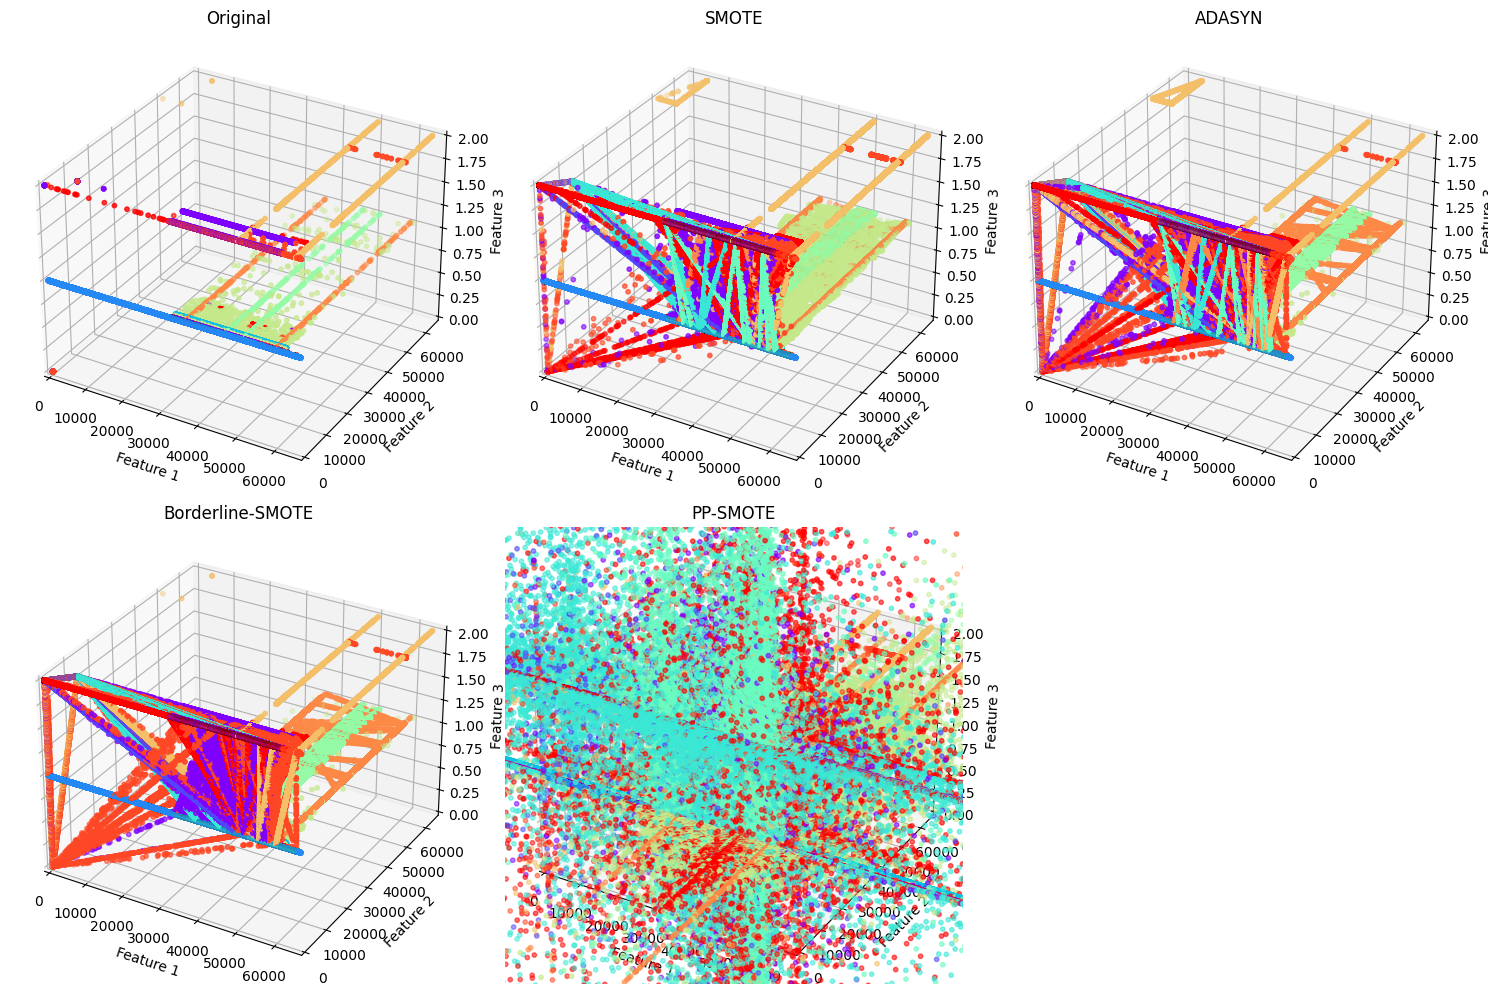

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler
from sklearn.datasets import make_classification
import numpy as np

# Define different resampling methods
resampling_methods = {
    'Original': (X, y),  # No resampling
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'Borderline-SMOTE': BorderlineSMOTE(),
    'PP-SMOTE': PPSMOTE(k_neighbors=5, random_state=42),
}

# Plotting in a 3x3 grid (change depending on the number of methods)
fig = plt.figure(figsize=(15, 15))

for i, (method_name, resampler) in enumerate(resampling_methods.items()):
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    
    if method_name == 'Original':
        # No resampling, use original dataset
        x_res, y_res = X, y
    elif method_name == 'PP-SMOTE':
        x_res, y_res = resampler.oversample(X, y, 1.0, merge=True)
    else:
        # Apply the resampling technique
        x_res, y_res = resampler.fit_resample(X, y)

    # Create 3D scatter plot
    ax.scatter(x_res[:, 0], x_res[:, 1], x_res[:, 2], c=y_res, cmap='rainbow', s=10)
    ax.set_title(method_name)

    # Optional: axis limits and labels
    ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
    ax.set_ylim([X[:, 1].min(), X[:, 1].max()])
    ax.set_zlim([X[:, 2].min(), X[:, 2].max()])
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Running PP-SMOTE with k=5...
Train on 567954 samples, validate on 567954 samples
Epoch 1/30


2024-09-30 01:41:45.728112: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_33/kernel/Assign' id:3036 op device:{requested: '', assigned: ''} def:{{{node dense_33/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_33/kernel, dense_33/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 01:41:54.301196: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_6/AddN_1' id:3152 op device:{requested: '', assigned: ''} def:{{{node loss_6/AddN_

567954/567954 - 15s - loss: 0.7156 - acc: 0.8813 - val_loss: 0.5518 - val_acc: 0.8823 - 15s/epoch - 26us/sample
Epoch 2/30
567954/567954 - 14s - loss: 0.4506 - acc: 0.9284 - val_loss: 0.5040 - val_acc: 0.8845 - 14s/epoch - 25us/sample
Epoch 3/30
567954/567954 - 14s - loss: 0.3986 - acc: 0.9358 - val_loss: 0.4463 - val_acc: 0.8969 - 14s/epoch - 25us/sample
Epoch 4/30
567954/567954 - 14s - loss: 0.3656 - acc: 0.9414 - val_loss: 0.4249 - val_acc: 0.9029 - 14s/epoch - 25us/sample
Epoch 5/30
567954/567954 - 14s - loss: 0.3423 - acc: 0.9449 - val_loss: 0.4190 - val_acc: 0.9269 - 14s/epoch - 25us/sample
Epoch 6/30
567954/567954 - 14s - loss: 0.3236 - acc: 0.9475 - val_loss: 0.3926 - val_acc: 0.9345 - 14s/epoch - 25us/sample
Epoch 7/30
567954/567954 - 14s - loss: 0.3087 - acc: 0.9495 - val_loss: 0.3892 - val_acc: 0.9339 - 14s/epoch - 25us/sample
Epoch 8/30
567954/567954 - 14s - loss: 0.2959 - acc: 0.9513 - val_loss: 0.3849 - val_acc: 0.9277 - 14s/epoch - 25us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 01:48:53.455126: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_34/Softmax' id:3068 op device:{requested: '', assigned: ''} def:{{{node dense_34/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_34/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9974

Members Accuracy: 0.9809
Non Members Accuracy 0.9821
Attack Accuracy 0.9815


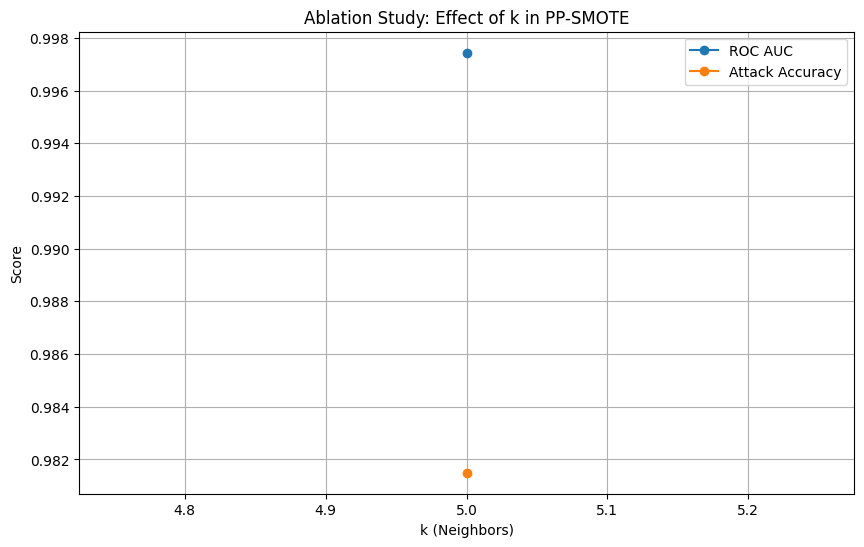

In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


k_values = [2, 3, 5, 7, 10]  # You can change or add more values
#k_values = [5]  # You can change or add more values
# Step 4: Perform k-based ablation study with SMOTE
results = {
    'k': [],
    'accuracy': [],
    'attack_accuracy': []
}

for k in k_values:
    print(f"Running PP-SMOTE with k={k}...")
    
    # Apply SMOTE with current k
    smote = PPSMOTE(k_neighbors=k, random_state=42)
    X_train_3,y_train_3 = smote.oversample(X, y, 0.025, merge=True)
    X_train, X_test, y_train, y_test = train_test_split(X_train_3,y_train_3, random_state=104,test_size=0.5,shuffle=True)
    scaler = MinMaxScaler()
    label_encoder = LabelEncoder()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    label_encoder.fit(y_train)
    label_encoder.fit(y_test)
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    model = Sequential()
    model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    #model.summary()
    history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=30,                    
                          batch_size=128,
                          verbose=2)
    pred_val = model.predict(X_test)
    auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
    
    # Store the results
    results['k'].append(k)
    results['accuracy'].append(auc_score)
    
    print(f"Accuracy: {auc_score:.4f}\n")

    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train) * attack_train_ratio)
    attack_test_size = int(len(X_test) * attack_train_ratio)
    mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
    mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
    
    mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                        X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
    mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
    
    mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
    mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
    mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
    
    print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
    print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
    print(f"Attack Accuracy {mlp_acc_bb:.4f}")
    results['attack_accuracy'].append(mlp_acc_bb)

# Step 7: Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Step 8: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='ROC AUC')
plt.plot(results_df['k'], results_df['attack_accuracy'], marker='o', label='Attack Accuracy')
plt.title('Ablation Study: Effect of k in PP-SMOTE')
plt.xlabel('k (Neighbors)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('K_neighbors_PP-SMOTE.jpg', dpi=300, bbox_inches='tight')

plt.show()


Running ablation study for imbalance ratio=0.2...
Train on 113586 samples, validate on 113586 samples


2024-09-19 03:41:11.787734: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_48/kernel/Assign' id:7511 op device:{requested: '', assigned: ''} def:{{{node dense_48/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_48/kernel, dense_48/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 03:41:14.133900: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_9/mul' id:7617 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_49_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


113586/113586 - 4s - loss: 0.9380 - acc: 0.6811 - val_loss: 0.2297 - val_acc: 0.9364 - 4s/epoch - 31us/sample
Epoch 2/30
113586/113586 - 3s - loss: 0.4132 - acc: 0.8576 - val_loss: 0.1813 - val_acc: 0.9469 - 3s/epoch - 28us/sample
Epoch 3/30
113586/113586 - 3s - loss: 0.3260 - acc: 0.8883 - val_loss: 0.1415 - val_acc: 0.9503 - 3s/epoch - 28us/sample
Epoch 4/30
113586/113586 - 3s - loss: 0.2727 - acc: 0.9038 - val_loss: 0.1305 - val_acc: 0.9554 - 3s/epoch - 28us/sample
Epoch 5/30
113586/113586 - 3s - loss: 0.2385 - acc: 0.9161 - val_loss: 0.1096 - val_acc: 0.9610 - 3s/epoch - 28us/sample
Epoch 6/30
113586/113586 - 3s - loss: 0.2144 - acc: 0.9258 - val_loss: 0.1054 - val_acc: 0.9651 - 3s/epoch - 28us/sample
Epoch 7/30
113586/113586 - 3s - loss: 0.1922 - acc: 0.9343 - val_loss: 0.1057 - val_acc: 0.9646 - 3s/epoch - 28us/sample
Epoch 8/30
113586/113586 - 3s - loss: 0.1789 - acc: 0.9405 - val_loss: 0.0717 - val_acc: 0.9759 - 3s/epoch - 28us/sample
Epoch 9/30
113586/113586 - 3s - loss: 0.164

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 03:42:48.555482: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_49/Softmax' id:7559 op device:{requested: '', assigned: ''} def:{{{node dense_49/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_49/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9995

Members Accuracy: 0.8211
Non Members Accuracy 0.4839
Attack Accuracy 0.6525
Running ablation study for imbalance ratio=0.3...
Train on 170382 samples, validate on 170382 samples


2024-09-19 03:44:42.624445: W tensorflow/c/c_api.cc:304] Operation '{name:'training_20/Adam/dense_54/bias/m/Assign' id:8789 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_54/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_54/bias/m, training_20/Adam/dense_54/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 03:44:46.058457: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_10/mul' id:8509 op device:{requested: '', assigned: ''} def:{{{node loss_10/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_10/mul/x, loss_10/dense_54_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


170382/170382 - 5s - loss: 0.8370 - acc: 0.7081 - val_loss: 0.2460 - val_acc: 0.9050 - 5s/epoch - 31us/sample
Epoch 2/30
170382/170382 - 5s - loss: 0.3801 - acc: 0.8715 - val_loss: 0.1848 - val_acc: 0.9408 - 5s/epoch - 29us/sample
Epoch 3/30
170382/170382 - 5s - loss: 0.3024 - acc: 0.9016 - val_loss: 0.1535 - val_acc: 0.9535 - 5s/epoch - 29us/sample
Epoch 4/30
170382/170382 - 5s - loss: 0.2537 - acc: 0.9214 - val_loss: 0.2081 - val_acc: 0.9369 - 5s/epoch - 29us/sample
Epoch 5/30
170382/170382 - 5s - loss: 0.2269 - acc: 0.9299 - val_loss: 0.2270 - val_acc: 0.9340 - 5s/epoch - 28us/sample
Epoch 6/30
170382/170382 - 5s - loss: 0.2065 - acc: 0.9367 - val_loss: 0.3407 - val_acc: 0.9145 - 5s/epoch - 28us/sample
Epoch 7/30
170382/170382 - 5s - loss: 0.1908 - acc: 0.9414 - val_loss: 0.2300 - val_acc: 0.9385 - 5s/epoch - 28us/sample
Epoch 8/30
170382/170382 - 5s - loss: 0.1755 - acc: 0.9460 - val_loss: 0.3759 - val_acc: 0.9102 - 5s/epoch - 29us/sample
Epoch 9/30
170382/170382 - 5s - loss: 0.171

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 03:47:10.196995: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_54/Softmax' id:8451 op device:{requested: '', assigned: ''} def:{{{node dense_54/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_54/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9968

Members Accuracy: 0.8154
Non Members Accuracy 0.6930
Attack Accuracy 0.7542
Running ablation study for imbalance ratio=0.5...
Train on 283974 samples, validate on 283974 samples


2024-09-19 03:50:19.157406: W tensorflow/c/c_api.cc:304] Operation '{name:'count_11/Assign' id:9353 op device:{requested: '', assigned: ''} def:{{{node count_11/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_11, count_11/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 03:50:24.900859: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_11/mul' id:9401 op device:{requested: '', assigned: ''} def:{{{node loss_11/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_11/mul/x, loss_11/dense_59_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


283974/283974 - 9s - loss: 0.7019 - acc: 0.7575 - val_loss: 0.2842 - val_acc: 0.9191 - 9s/epoch - 32us/sample
Epoch 2/30
283974/283974 - 8s - loss: 0.3391 - acc: 0.8856 - val_loss: 0.2258 - val_acc: 0.9081 - 8s/epoch - 29us/sample
Epoch 3/30
283974/283974 - 8s - loss: 0.2571 - acc: 0.9177 - val_loss: 0.1840 - val_acc: 0.9337 - 8s/epoch - 29us/sample
Epoch 4/30
283974/283974 - 8s - loss: 0.2199 - acc: 0.9292 - val_loss: 0.2082 - val_acc: 0.9337 - 8s/epoch - 29us/sample
Epoch 5/30
283974/283974 - 8s - loss: 0.1991 - acc: 0.9360 - val_loss: 0.1949 - val_acc: 0.9365 - 8s/epoch - 29us/sample
Epoch 6/30
283974/283974 - 8s - loss: 0.1827 - acc: 0.9420 - val_loss: 0.3145 - val_acc: 0.8905 - 8s/epoch - 29us/sample
Epoch 7/30
283974/283974 - 8s - loss: 0.1760 - acc: 0.9439 - val_loss: 0.3075 - val_acc: 0.9067 - 8s/epoch - 29us/sample
Epoch 8/30
283974/283974 - 8s - loss: 0.1683 - acc: 0.9474 - val_loss: 0.2902 - val_acc: 0.9043 - 8s/epoch - 28us/sample
Epoch 9/30
283974/283974 - 8s - loss: 0.159

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 03:54:26.941509: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_59/Softmax' id:9343 op device:{requested: '', assigned: ''} def:{{{node dense_59/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_59/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9984

Members Accuracy: 0.9074
Non Members Accuracy 0.6009
Attack Accuracy 0.7542
Running ablation study for imbalance ratio=0.75...
Train on 425964 samples, validate on 425964 samples


2024-09-19 03:59:23.767976: W tensorflow/c/c_api.cc:304] Operation '{name:'training_24/Adam/dense_60/kernel/v/Assign' id:10580 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_60/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_60/kernel/v, training_24/Adam/dense_60/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 03:59:32.086334: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_12/mul' id:10293 op device:{requested: '', assigned: ''} def:{{{node loss_12/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_12/mul/x, loss_12/dense_64_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


425964/425964 - 13s - loss: 0.5933 - acc: 0.8051 - val_loss: 0.2203 - val_acc: 0.9071 - 13s/epoch - 32us/sample
Epoch 2/30
425964/425964 - 13s - loss: 0.2677 - acc: 0.9151 - val_loss: 0.2459 - val_acc: 0.9143 - 13s/epoch - 31us/sample
Epoch 3/30
425964/425964 - 13s - loss: 0.2131 - acc: 0.9322 - val_loss: 0.3498 - val_acc: 0.8820 - 13s/epoch - 31us/sample
Epoch 4/30
425964/425964 - 13s - loss: 0.1914 - acc: 0.9398 - val_loss: 0.3582 - val_acc: 0.8749 - 13s/epoch - 31us/sample
Epoch 5/30
425964/425964 - 13s - loss: 0.1773 - acc: 0.9434 - val_loss: 1.0418 - val_acc: 0.7770 - 13s/epoch - 31us/sample
Epoch 6/30
425964/425964 - 13s - loss: 0.1689 - acc: 0.9466 - val_loss: 0.5179 - val_acc: 0.8405 - 13s/epoch - 31us/sample
Epoch 7/30
425964/425964 - 13s - loss: 0.1663 - acc: 0.9478 - val_loss: 0.4387 - val_acc: 0.8263 - 13s/epoch - 31us/sample
Epoch 8/30
425964/425964 - 13s - loss: 0.1586 - acc: 0.9500 - val_loss: 0.5838 - val_acc: 0.7889 - 13s/epoch - 30us/sample
Epoch 9/30
425964/425964 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 04:05:56.748156: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_64/Softmax' id:10235 op device:{requested: '', assigned: ''} def:{{{node dense_64/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_64/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9951

Members Accuracy: 0.8245
Non Members Accuracy 0.7396
Attack Accuracy 0.7820
Running ablation study for imbalance ratio=1.0...
Train on 567954 samples, validate on 567954 samples


2024-09-19 04:13:46.052808: W tensorflow/c/c_api.cc:304] Operation '{name:'training_26/Adam/dense_67/kernel/m/Assign' id:11440 op device:{requested: '', assigned: ''} def:{{{node training_26/Adam/dense_67/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/Adam/dense_67/kernel/m, training_26/Adam/dense_67/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 04:13:57.543374: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_13/mul' id:11185 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/dense_69_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 18s - loss: 0.5601 - acc: 0.8155 - val_loss: 0.1998 - val_acc: 0.9330 - 18s/epoch - 32us/sample
Epoch 2/30
567954/567954 - 17s - loss: 0.2691 - acc: 0.9159 - val_loss: 0.1476 - val_acc: 0.9518 - 17s/epoch - 31us/sample
Epoch 3/30
567954/567954 - 18s - loss: 0.2179 - acc: 0.9318 - val_loss: 0.1398 - val_acc: 0.9556 - 18s/epoch - 31us/sample
Epoch 4/30
567954/567954 - 18s - loss: 0.1947 - acc: 0.9391 - val_loss: 0.1703 - val_acc: 0.9286 - 18s/epoch - 32us/sample
Epoch 5/30
567954/567954 - 18s - loss: 0.1826 - acc: 0.9428 - val_loss: 0.1914 - val_acc: 0.9259 - 18s/epoch - 31us/sample
Epoch 6/30
567954/567954 - 18s - loss: 0.1736 - acc: 0.9462 - val_loss: 0.1819 - val_acc: 0.9269 - 18s/epoch - 31us/sample
Epoch 7/30
567954/567954 - 18s - loss: 0.1682 - acc: 0.9484 - val_loss: 0.1953 - val_acc: 0.9289 - 18s/epoch - 31us/sample
Epoch 8/30
567954/567954 - 18s - loss: 0.1621 - acc: 0.9506 - val_loss: 0.1899 - val_acc: 0.9558 - 18s/epoch - 31us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 04:22:36.281570: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_69/Softmax' id:11127 op device:{requested: '', assigned: ''} def:{{{node dense_69/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_69/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9890

Members Accuracy: 0.7801
Non Members Accuracy 0.6935
Attack Accuracy 0.7368


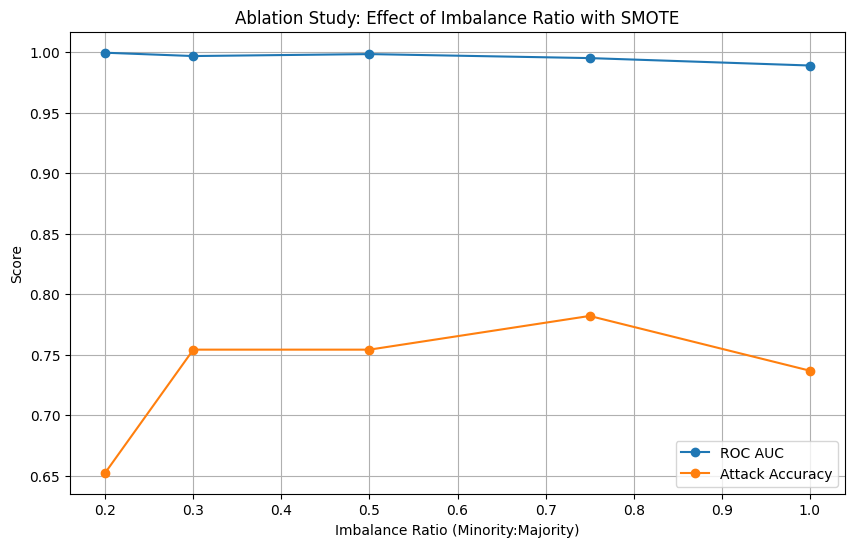

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

imbalance_ratios = [0.2, 0.3, 0.5, 0.75, 1.0]  # Ratio of minority to majority class

results = {
    'imbalance_ratio': [],
    'accuracy': [],
    'attack_accuracy': []
}

for ratio in imbalance_ratios:
    print(f"Running ablation study for imbalance ratio={ratio}...")

    # You need to define the sampling strategy for each class as a dictionary
    # For example, assuming 'y' has class labels [0, 1, 2, ..., 11], adjust the ratio accordingly:
    sampling_strategy = {0: int(len(y[y == 0]) * ratio),
                         1: int(len(y[y == 1]) * ratio),
                         2: int(len(y[y == 2]) * ratio),
                         3: int(len(y[y == 3]) * ratio),
                         4: int(len(y[y == 4]) * ratio),
                         5: int(len(y[y == 5]) * ratio),
                         6: int(len(y[y == 6]) * ratio),
                         7: int(len(y[y == 7]) * ratio),
                         8: int(len(y[y == 8]) * ratio),
                         9: int(len(y[y == 9]) * ratio),
                         10: int(len(y[y == 10]) * ratio),
                         11: int(len(y[y == 11]) * ratio)}
    
    # Apply the RandomUnderSampler
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)

    smote = PPSMOTE(k_neighbors=2, random_state=42)
    X_train_3, y_train_3 = smote.oversample(X_resampled, y_resampled, 0.025, merge=True)
    X_train, X_test, y_train, y_test = train_test_split(X_train_3,y_train_3, random_state=104,test_size=0.5,shuffle=True)
    scaler = MinMaxScaler()
    label_encoder = LabelEncoder()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    label_encoder.fit(y_train)
    label_encoder.fit(y_test)
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    model = Sequential()
    model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    #model.summary()
    history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=30,                    
                          batch_size=128,
                          verbose=2)
    pred_val = model.predict(X_test)
    auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
    
    # Store the results
    results['imbalance_ratio'].append(ratio)
    results['accuracy'].append(auc_score)
    
    print(f"Accuracy: {auc_score:.4f}\n")

    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train) * attack_train_ratio)
    attack_test_size = int(len(X_test) * attack_train_ratio)
    mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
    mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
    
    mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                        X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
    mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
    
    mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
    mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
    mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
    
    print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
    print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
    print(f"Attack Accuracy {mlp_acc_bb:.4f}")
    results['attack_accuracy'].append(mlp_acc_bb)

    
# Step 5: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Step 6: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['imbalance_ratio'], results_df['accuracy'], marker='o', label='ROC AUC')
plt.plot(results_df['imbalance_ratio'], results_df['attack_accuracy'], marker='o', label='Attack Accuracy')
plt.title('Ablation Study: Effect of Imbalance Ratio with PP-SMOTE')
plt.xlabel('Imbalance Ratio (Minority:Majority)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.savefig('Imabalance_Ratio_PP-SMOTE.jpg', dpi=300, bbox_inches='tight')
plt.show()

Running ablation study for L1-norm sensitivity=0.5...
Train on 567954 samples, validate on 567954 samples


2024-09-19 04:35:11.664441: W tensorflow/c/c_api.cc:304] Operation '{name:'training_28/Adam/dense_73/bias/v/Assign' id:12403 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_73/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_73/bias/v, training_28/Adam/dense_73/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 04:35:22.208847: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_14/mul' id:12077 op device:{requested: '', assigned: ''} def:{{{node loss_14/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_14/mul/x, loss_14/dense_74_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 17s - loss: 0.9500 - acc: 0.6344 - val_loss: 0.5853 - val_acc: 0.7638 - 17s/epoch - 30us/sample
Epoch 2/30
567954/567954 - 17s - loss: 0.6512 - acc: 0.7424 - val_loss: 0.5074 - val_acc: 0.7798 - 17s/epoch - 29us/sample
Epoch 3/30
567954/567954 - 17s - loss: 0.5877 - acc: 0.7666 - val_loss: 0.4543 - val_acc: 0.8177 - 17s/epoch - 30us/sample
Epoch 4/30
567954/567954 - 17s - loss: 0.5520 - acc: 0.7815 - val_loss: 0.4396 - val_acc: 0.8128 - 17s/epoch - 30us/sample
Epoch 5/30
567954/567954 - 17s - loss: 0.5274 - acc: 0.7915 - val_loss: 0.4257 - val_acc: 0.8156 - 17s/epoch - 30us/sample
Epoch 6/30
567954/567954 - 17s - loss: 0.5177 - acc: 0.7951 - val_loss: 0.4446 - val_acc: 0.8139 - 17s/epoch - 30us/sample
Epoch 7/30
567954/567954 - 17s - loss: 0.5108 - acc: 0.7980 - val_loss: 0.4101 - val_acc: 0.8258 - 17s/epoch - 30us/sample
Epoch 8/30
567954/567954 - 17s - loss: 0.5116 - acc: 0.7979 - val_loss: 0.4380 - val_acc: 0.8146 - 17s/epoch - 30us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 04:43:37.434676: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_74/Softmax' id:12019 op device:{requested: '', assigned: ''} def:{{{node dense_74/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_74/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9869

Members Accuracy: 0.7692
Non Members Accuracy 0.7288
Attack Accuracy 0.7490
L1-norm sensitivity: 0.5, AUC Score: 0.9869
Running ablation study for L1-norm sensitivity=0.6...
Train on 567954 samples, validate on 567954 samples


2024-09-19 04:51:58.655325: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_76/bias/Assign' id:12794 op device:{requested: '', assigned: ''} def:{{{node dense_76/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_76/bias, dense_76/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 04:52:09.323914: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_15/mul' id:12969 op device:{requested: '', assigned: ''} def:{{{node loss_15/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul/x, loss_15/dense_79_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 17s - loss: 0.9481 - acc: 0.6366 - val_loss: 0.5546 - val_acc: 0.7774 - 17s/epoch - 30us/sample
Epoch 2/30
567954/567954 - 17s - loss: 0.6672 - acc: 0.7384 - val_loss: 0.5210 - val_acc: 0.7643 - 17s/epoch - 30us/sample
Epoch 3/30
567954/567954 - 17s - loss: 0.6092 - acc: 0.7604 - val_loss: 0.5299 - val_acc: 0.7801 - 17s/epoch - 30us/sample
Epoch 4/30
567954/567954 - 17s - loss: 0.5739 - acc: 0.7742 - val_loss: 0.4582 - val_acc: 0.8108 - 17s/epoch - 30us/sample
Epoch 5/30
567954/567954 - 17s - loss: 0.5578 - acc: 0.7797 - val_loss: 0.4741 - val_acc: 0.8000 - 17s/epoch - 30us/sample
Epoch 6/30
567954/567954 - 17s - loss: 0.5494 - acc: 0.7823 - val_loss: 0.4483 - val_acc: 0.8134 - 17s/epoch - 30us/sample
Epoch 7/30
567954/567954 - 17s - loss: 0.5429 - acc: 0.7839 - val_loss: 0.4194 - val_acc: 0.8254 - 17s/epoch - 30us/sample
Epoch 8/30
567954/567954 - 17s - loss: 0.5408 - acc: 0.7858 - val_loss: 0.4544 - val_acc: 0.8050 - 17s/epoch - 30us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 05:00:28.120077: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_79/Softmax' id:12911 op device:{requested: '', assigned: ''} def:{{{node dense_79/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_79/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9857

Members Accuracy: 0.8446
Non Members Accuracy 0.5761
Attack Accuracy 0.7104
L1-norm sensitivity: 0.6, AUC Score: 0.9857
Running ablation study for L1-norm sensitivity=0.75...
Train on 567954 samples, validate on 567954 samples


2024-09-19 05:08:44.572305: W tensorflow/c/c_api.cc:304] Operation '{name:'training_32/Adam/dense_84/kernel/m/Assign' id:14136 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/dense_84/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/dense_84/kernel/m, training_32/Adam/dense_84/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 05:08:55.474286: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_16/mul' id:13861 op device:{requested: '', assigned: ''} def:{{{node loss_16/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_16/mul/x, loss_16/dense_84_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 18s - loss: 0.9534 - acc: 0.6391 - val_loss: 0.5724 - val_acc: 0.7696 - 18s/epoch - 31us/sample
Epoch 2/30
567954/567954 - 17s - loss: 0.6783 - acc: 0.7398 - val_loss: 0.5161 - val_acc: 0.7926 - 17s/epoch - 30us/sample
Epoch 3/30
567954/567954 - 17s - loss: 0.6168 - acc: 0.7617 - val_loss: 0.4976 - val_acc: 0.7948 - 17s/epoch - 30us/sample
Epoch 4/30
567954/567954 - 17s - loss: 0.5867 - acc: 0.7716 - val_loss: 0.4521 - val_acc: 0.8104 - 17s/epoch - 31us/sample
Epoch 5/30
567954/567954 - 17s - loss: 0.5687 - acc: 0.7772 - val_loss: 0.4875 - val_acc: 0.7843 - 17s/epoch - 30us/sample
Epoch 6/30
567954/567954 - 17s - loss: 0.5581 - acc: 0.7804 - val_loss: 0.5171 - val_acc: 0.7801 - 17s/epoch - 30us/sample
Epoch 7/30
567954/567954 - 17s - loss: 0.5568 - acc: 0.7814 - val_loss: 0.4370 - val_acc: 0.8168 - 17s/epoch - 30us/sample
Epoch 8/30
567954/567954 - 17s - loss: 0.5588 - acc: 0.7813 - val_loss: 0.4625 - val_acc: 0.8107 - 17s/epoch - 30us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 05:17:18.736082: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_84/Softmax' id:13803 op device:{requested: '', assigned: ''} def:{{{node dense_84/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_84/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9829

Members Accuracy: 0.8059
Non Members Accuracy 0.6936
Attack Accuracy 0.7497
L1-norm sensitivity: 0.75, AUC Score: 0.9829
Running ablation study for L1-norm sensitivity=0.9...
Train on 567954 samples, validate on 567954 samples


2024-09-19 05:25:50.465535: W tensorflow/c/c_api.cc:304] Operation '{name:'training_34/Adam/dense_86/bias/m/Assign' id:15001 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_86/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_86/bias/m, training_34/Adam/dense_86/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 05:26:01.496494: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_17/mul' id:14753 op device:{requested: '', assigned: ''} def:{{{node loss_17/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_17/mul/x, loss_17/dense_89_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 18s - loss: 0.9812 - acc: 0.6262 - val_loss: 0.6267 - val_acc: 0.7416 - 18s/epoch - 32us/sample
Epoch 2/30
567954/567954 - 17s - loss: 0.6894 - acc: 0.7332 - val_loss: 0.5165 - val_acc: 0.7803 - 17s/epoch - 30us/sample
Epoch 3/30
567954/567954 - 17s - loss: 0.6201 - acc: 0.7579 - val_loss: 0.4795 - val_acc: 0.7994 - 17s/epoch - 30us/sample
Epoch 4/30
567954/567954 - 17s - loss: 0.5880 - acc: 0.7692 - val_loss: 0.5070 - val_acc: 0.7852 - 17s/epoch - 30us/sample
Epoch 5/30
567954/567954 - 17s - loss: 0.5721 - acc: 0.7749 - val_loss: 0.4553 - val_acc: 0.8062 - 17s/epoch - 31us/sample
Epoch 6/30
567954/567954 - 17s - loss: 0.5596 - acc: 0.7794 - val_loss: 0.4346 - val_acc: 0.8219 - 17s/epoch - 30us/sample
Epoch 7/30
567954/567954 - 17s - loss: 0.5547 - acc: 0.7818 - val_loss: 0.4213 - val_acc: 0.8283 - 17s/epoch - 30us/sample
Epoch 8/30
567954/567954 - 17s - loss: 0.5612 - acc: 0.7795 - val_loss: 0.4855 - val_acc: 0.8093 - 17s/epoch - 30us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 05:34:28.782741: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_89/Softmax' id:14695 op device:{requested: '', assigned: ''} def:{{{node dense_89/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_89/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9858

Members Accuracy: 0.8600
Non Members Accuracy 0.6171
Attack Accuracy 0.7386
L1-norm sensitivity: 0.9, AUC Score: 0.9858
Running ablation study for L1-norm sensitivity=1.0...
Train on 567954 samples, validate on 567954 samples


2024-09-19 05:42:36.193221: W tensorflow/c/c_api.cc:304] Operation '{name:'training_36/Adam/decay/Assign' id:15864 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/decay, training_36/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-19 05:42:47.236845: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_18/mul' id:15645 op device:{requested: '', assigned: ''} def:{{{node loss_18/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_18/mul/x, loss_18/dense_94_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 18s - loss: 0.9650 - acc: 0.6331 - val_loss: 0.6076 - val_acc: 0.7628 - 18s/epoch - 32us/sample
Epoch 2/30
567954/567954 - 18s - loss: 0.6947 - acc: 0.7326 - val_loss: 0.5418 - val_acc: 0.7789 - 18s/epoch - 31us/sample
Epoch 3/30
567954/567954 - 18s - loss: 0.6414 - acc: 0.7513 - val_loss: 0.5228 - val_acc: 0.7981 - 18s/epoch - 31us/sample
Epoch 4/30
567954/567954 - 17s - loss: 0.6213 - acc: 0.7595 - val_loss: 0.5010 - val_acc: 0.7905 - 17s/epoch - 31us/sample
Epoch 5/30
567954/567954 - 17s - loss: 0.6067 - acc: 0.7643 - val_loss: 0.5031 - val_acc: 0.7912 - 17s/epoch - 30us/sample
Epoch 6/30
567954/567954 - 17s - loss: 0.5955 - acc: 0.7681 - val_loss: 0.5080 - val_acc: 0.7802 - 17s/epoch - 31us/sample
Epoch 7/30
567954/567954 - 17s - loss: 0.5886 - acc: 0.7703 - val_loss: 0.4793 - val_acc: 0.7957 - 17s/epoch - 31us/sample
Epoch 8/30
567954/567954 - 17s - loss: 0.5838 - acc: 0.7725 - val_loss: 0.4815 - val_acc: 0.8035 - 17s/epoch - 31us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-19 05:51:18.845993: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_94/Softmax' id:15587 op device:{requested: '', assigned: ''} def:{{{node dense_94/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_94/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy: 0.9850

Members Accuracy: 0.7499
Non Members Accuracy 0.6770
Attack Accuracy 0.7134
L1-norm sensitivity: 1.0, AUC Score: 0.9850


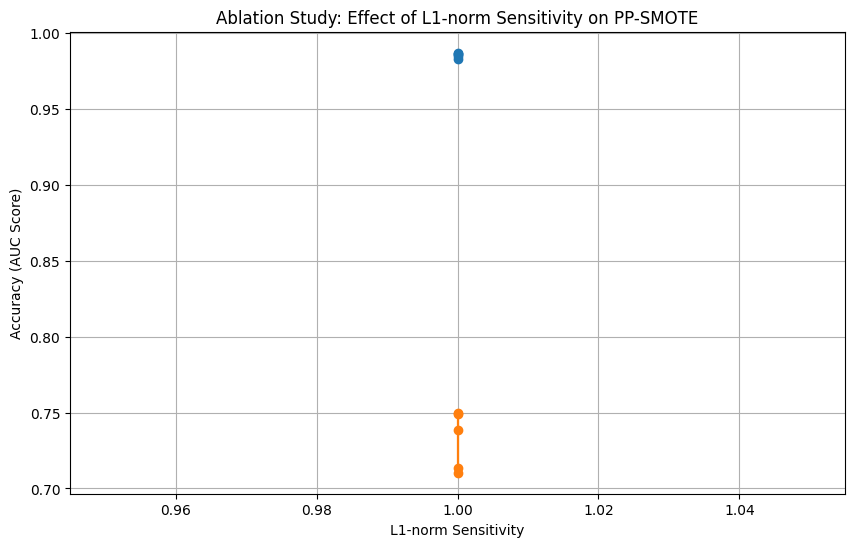

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# L1-norm sensitivities to explore
l1_sensitivities = [0.5, 0.6, 0.75, 0.9, 1.0]  # Vary sensitivity

# Epsilon (privacy budget) - a fixed small value for ablation study
epsilon = 0.025

# Results storage
results = {
    'l1_sensitivity': [],
    'accuracy': [],
    'attack_accuracy': []
}

def laplace_noise(l1_sensitivity, epsilon, size):
    # Generate Laplace noise based on sensitivity and epsilon
    noise = np.random.laplace(0, l1_sensitivity / epsilon, size=size)
    return noise

# Loop over different L1-norm sensitivities
for l1_sensitivity in l1_sensitivities:
    print(f"Running ablation study for L1-norm sensitivity={l1_sensitivity}...")
    
    # Step 1: Apply SMOTE
    smote = PPSMOTE(k_neighbors=5, random_state=42)
    X_train_3, y_train_3 = smote.oversample(X, y, epsilon, merge=True)
    noise = laplace_noise(l1_sensitivity, epsilon, X_train_3.shape)
    X_train_3_noisy = X_train_3 + noise
    X_train, X_test, y_train, y_test = train_test_split(X_train_3_noisy,y_train_3, random_state=104,test_size=0.5,shuffle=True)
    scaler = MinMaxScaler()
    label_encoder = LabelEncoder()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    label_encoder.fit(y_train)
    label_encoder.fit(y_test)
    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)
    model = Sequential()
    model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    #model.summary()
    history = model.fit(X_train, y_train,
                          validation_data=(X_test, y_test),
                          epochs=30,                    
                          batch_size=128,
                          verbose=2)
    pred_val = model.predict(X_test)
    auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
    
    # Store the results
    results['l1_sensitivity'].append(l1_sensitivity)
    results['accuracy'].append(auc_score)
    
    print(f"Accuracy: {auc_score:.4f}\n")

    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train) * attack_train_ratio)
    attack_test_size = int(len(X_test) * attack_train_ratio)
    mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
    mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
    
    mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32),y_train[:attack_train_size].astype(np.float32),
                        X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
    mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
    
    mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
    mlp_test_acc_bb = 1-(np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
    mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
    
    print(f"Members Accuracy: {mlp_train_acc_bb:.4f}")
    print(f"Non Members Accuracy {mlp_test_acc_bb:.4f}")
    print(f"Attack Accuracy {mlp_acc_bb:.4f}")
    results['attack_accuracy'].append(mlp_acc_bb)

    print(f"L1-norm sensitivity: {l1_sensitivity}, AUC Score: {auc_score:.4f}")

# Convert results to a DataFrame for further analysis and plotting
results_df = pd.DataFrame(results)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['l1_sensitivity'], results_df['accuracy'], marker='o', label='Accuracy (AUC)')
plt.plot(results_df['l1_sensitivity'], results_df['attack_accuracy'], marker='o', label='Attack Accuracy')

plt.title('Ablation Study: Effect of L1-norm Sensitivity on PP-SMOTE')
plt.xlabel('L1-norm Sensitivity')
plt.ylabel('Accuracy (AUC Score)')
plt.grid(True)
plt.savefig('L1_sensitivity_PP-SMOTE.jpg', dpi=300, bbox_inches='tight')

plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Hyperparameter grid
param_grid = {
    'k': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'sensitivity': [1.0],
    'privacy_budget': [0.05, 0.033, 0.025, 0.02],
    'minority_majority_ratio': [1.0],
    'learning_rate': [0.001]
}

# Initialize results storage
results = {
    'k': [],
    'sensitivity': [],
    'privacy_budget': [],
    'minority_majority_ratio': [],
    'learning_rate': [],
    'accuracy': [],
    'attack_accuracy': [],
    'f1_score' : []
}

# Function to perform grid search with F1 score calculation
def grid_search():
    best_config = None
    best_auc = -np.inf
    for k in param_grid['k']:
        for sensitivity in param_grid['sensitivity']:
            for privacy_budget in param_grid['privacy_budget']:
                for minority_majority_ratio in param_grid['minority_majority_ratio']:
                    for learning_rate in param_grid['learning_rate']:
                        print(f"Running with k={k}, sensitivity={sensitivity}, privacy_budget={privacy_budget}, ratio={minority_majority_ratio}, lr={learning_rate}...")

                        # Apply SMOTE (or your custom PPSMOTE) with the current parameters
                        smote = PPSMOTE(k_neighbors=k, random_state=42)
                        X_train_3, y_train_3 = smote.oversample(X, y, privacy_budget, merge=True)
                        X_train, X_test, y_train, y_test = train_test_split(X_train_3, y_train_3, random_state=104, test_size=0.5, shuffle=True)
                        
                        # Data scaling and label encoding
                        scaler = MinMaxScaler()
                        label_encoder = LabelEncoder()
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.transform(X_test)
                        y_train = label_encoder.fit_transform(y_train)
                        y_test = label_encoder.transform(y_test)
                        
                        # Build the model
                        model = Sequential()
                        model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
                        model.add(Dropout(0.3))
                        model.add(Dense(64, activation='relu'))
                        model.add(Dropout(0.3))
                        model.add(Dense(32, activation='relu'))
                        model.add(Dropout(0.3))
                        model.add(Dense(16, activation='relu'))
                        model.add(Dropout(0.3))
                        model.add(Dense(12, activation='softmax'))
                        
                        # Compile the model with the current learning rate
                        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, clipnorm=1.0)
                        loss = tf.keras.losses.SparseCategoricalCrossentropy()
                        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
                        
                        # Train the model
                        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, verbose=2)
                        
                        # Evaluate AUC
                        pred_val = model.predict(X_test)
                        auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
                        
                        # Predict classes for F1 score calculation
                        pred_classes = np.argmax(pred_val, axis=1)
                        f1 = f1_score(y_test, pred_classes, average='weighted')
                        
                        # Membership inference attack
                        attack_train_ratio = 0.5
                        attack_train_size = int(len(X_train) * attack_train_ratio)
                        attack_test_size = int(len(X_test) * attack_train_ratio)
                        
                        mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
                        mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
                        mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                                          X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
                        mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
                        mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
                        
                        mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
                        mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
                        mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
                        
                        print(f"AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Attack Accuracy: {mlp_acc_bb:.4f}")
                        
                        # Store the results
                        results['k'].append(k)
                        results['sensitivity'].append(sensitivity)
                        results['privacy_budget'].append(privacy_budget)
                        results['minority_majority_ratio'].append(minority_majority_ratio)
                        results['learning_rate'].append(learning_rate)
                        results['accuracy'].append(auc_score)
                        results['attack_accuracy'].append(mlp_acc_bb)
                        results['f1_score'].append(f1)
                        
                        # Check if the current config meets the criteria
                        if auc_score > 0.9 and mlp_acc_bb < 0.6 and auc_score > best_auc:
                            best_auc = auc_score
                            best_config = {
                                'k': k,
                                'sensitivity': sensitivity,
                                'privacy_budget': privacy_budget,
                                'minority_majority_ratio': minority_majority_ratio,
                                'learning_rate': learning_rate
                            }
    
    return best_config, results

# Perform grid search
best_config, results = grid_search()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='ROC AUC')
plt.plot(results_df['k'], results_df['attack_accuracy'], marker='o', label='Attack Accuracy')
plt.plot(results_df['k'], results_df['f1_score'], marker='o', label='F1 Score')
plt.title('Grid Search Results: Effect of k in PP-SMOTE')
plt.xlabel('k (Neighbors)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('Grid_Search_PP-SMOTE.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Print the best configuration
if best_config:
    print("Best Configuration Found:")
    print(best_config)
else:
    print("No configuration met the criteria.")

Running with k=2, sensitivity=1.0, privacy_budget=0.05, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples
Epoch 1/30


2024-09-30 20:47:44.603924: W tensorflow/c/c_api.cc:304] Operation '{name:'training_12/Adam/dense_31/kernel/v/Assign' id:5838 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_31/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_31/kernel/v, training_12/Adam/dense_31/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 20:47:56.755054: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_6/mul' id:5539 

567954/567954 - 18s - loss: 1.6320 - acc: 0.3510 - val_loss: 1.3204 - val_acc: 0.5321 - 18s/epoch - 32us/sample
Epoch 2/30
567954/567954 - 18s - loss: 1.3951 - acc: 0.4576 - val_loss: 1.1582 - val_acc: 0.5447 - 18s/epoch - 32us/sample
Epoch 3/30
567954/567954 - 18s - loss: 1.2820 - acc: 0.5176 - val_loss: 1.0422 - val_acc: 0.6497 - 18s/epoch - 32us/sample
Epoch 4/30
567954/567954 - 18s - loss: 1.2304 - acc: 0.5471 - val_loss: 1.2087 - val_acc: 0.5485 - 18s/epoch - 32us/sample
Epoch 5/30
567954/567954 - 18s - loss: 1.1646 - acc: 0.5777 - val_loss: 1.2137 - val_acc: 0.4855 - 18s/epoch - 31us/sample
Epoch 6/30
567954/567954 - 18s - loss: 1.1242 - acc: 0.6087 - val_loss: 1.1337 - val_acc: 0.5275 - 18s/epoch - 32us/sample
Epoch 7/30
567954/567954 - 18s - loss: 1.0875 - acc: 0.6348 - val_loss: 1.1052 - val_acc: 0.5592 - 18s/epoch - 32us/sample
Epoch 8/30
567954/567954 - 18s - loss: 1.0507 - acc: 0.6575 - val_loss: 1.1981 - val_acc: 0.5174 - 18s/epoch - 32us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 20:56:40.278708: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_34/Softmax' id:5481 op device:{requested: '', assigned: ''} def:{{{node dense_34/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_34/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9031, F1 Score: 0.5723, Attack Accuracy: 0.5005
Running with k=2, sensitivity=1.0, privacy_budget=0.033, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 21:09:37.061017: W tensorflow/c/c_api.cc:304] Operation '{name:'training_14/Adam/decay/Assign' id:6820 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/decay, training_14/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 21:09:49.201197: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_7/mul' id:6601 op device:{requested: '', assigned: ''} def:{{{node loss_7/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_7/mul/x, loss_7/dense_39_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 18s - loss: 1.8140 - acc: 0.2643 - val_loss: 1.5131 - val_acc: 0.3943 - 18s/epoch - 32us/sample
Epoch 2/30
567954/567954 - 18s - loss: 1.5738 - acc: 0.3582 - val_loss: 1.4472 - val_acc: 0.3762 - 18s/epoch - 32us/sample
Epoch 3/30
567954/567954 - 18s - loss: 1.4967 - acc: 0.3956 - val_loss: 1.4266 - val_acc: 0.3775 - 18s/epoch - 32us/sample
Epoch 4/30
567954/567954 - 18s - loss: 1.4383 - acc: 0.4336 - val_loss: 1.4279 - val_acc: 0.3954 - 18s/epoch - 32us/sample
Epoch 5/30
567954/567954 - 18s - loss: 1.4068 - acc: 0.4439 - val_loss: 1.5755 - val_acc: 0.3404 - 18s/epoch - 32us/sample
Epoch 6/30
567954/567954 - 18s - loss: 1.3869 - acc: 0.4528 - val_loss: 1.6690 - val_acc: 0.3784 - 18s/epoch - 32us/sample
Epoch 7/30
567954/567954 - 18s - loss: 1.3704 - acc: 0.4619 - val_loss: 1.7261 - val_acc: 0.3326 - 18s/epoch - 32us/sample
Epoch 8/30
567954/567954 - 18s - loss: 1.3592 - acc: 0.4712 - val_loss: 1.6689 - val_acc: 0.4022 - 18s/epoch - 32us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 21:18:39.135350: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_39/Softmax' id:6543 op device:{requested: '', assigned: ''} def:{{{node dense_39/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_39/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.6075, F1 Score: 0.1446, Attack Accuracy: 0.4996
Running with k=2, sensitivity=1.0, privacy_budget=0.025, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 21:29:21.659796: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_44/bias/Assign' id:7599 op device:{requested: '', assigned: ''} def:{{{node dense_44/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_44/bias, dense_44/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 21:29:33.932711: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_8/mul' id:7663 op device:{requested: '', assigned: ''} def:{{{node loss_8/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_8/mul/x, loss_8/dense_44_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 18s - loss: 1.6665 - acc: 0.3458 - val_loss: 1.2183 - val_acc: 0.4741 - 18s/epoch - 32us/sample
Epoch 2/30
567954/567954 - 18s - loss: 1.2290 - acc: 0.5518 - val_loss: 0.9126 - val_acc: 0.6761 - 18s/epoch - 32us/sample
Epoch 3/30
567954/567954 - 18s - loss: 1.1267 - acc: 0.5941 - val_loss: 0.8511 - val_acc: 0.6732 - 18s/epoch - 32us/sample
Epoch 4/30
567954/567954 - 18s - loss: 1.0711 - acc: 0.6175 - val_loss: 0.8350 - val_acc: 0.6717 - 18s/epoch - 32us/sample
Epoch 5/30
567954/567954 - 18s - loss: 1.0307 - acc: 0.6345 - val_loss: 0.7958 - val_acc: 0.6847 - 18s/epoch - 32us/sample
Epoch 6/30
567954/567954 - 18s - loss: 0.9990 - acc: 0.6478 - val_loss: 0.8534 - val_acc: 0.6709 - 18s/epoch - 32us/sample
Epoch 7/30
567954/567954 - 19s - loss: 0.9592 - acc: 0.6671 - val_loss: 0.7508 - val_acc: 0.7058 - 19s/epoch - 33us/sample
Epoch 8/30
567954/567954 - 18s - loss: 0.9371 - acc: 0.6796 - val_loss: 0.7504 - val_acc: 0.6963 - 18s/epoch - 32us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 21:38:27.624725: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_44/Softmax' id:7605 op device:{requested: '', assigned: ''} def:{{{node dense_44/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_44/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9259, F1 Score: 0.5692, Attack Accuracy: 0.5001
Running with k=2, sensitivity=1.0, privacy_budget=0.02, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 21:51:40.060123: W tensorflow/c/c_api.cc:304] Operation '{name:'training_18/Adam/dense_45/kernel/m/Assign' id:8956 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/dense_45/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/dense_45/kernel/m, training_18/Adam/dense_45/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 21:51:52.495128: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_9/mul' id:8725 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_49_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 19s - loss: 1.6278 - acc: 0.3445 - val_loss: 1.2732 - val_acc: 0.5119 - 19s/epoch - 33us/sample
Epoch 2/30
567954/567954 - 18s - loss: 1.3477 - acc: 0.4805 - val_loss: 1.0587 - val_acc: 0.6689 - 18s/epoch - 32us/sample
Epoch 3/30
567954/567954 - 18s - loss: 1.2214 - acc: 0.5549 - val_loss: 0.8939 - val_acc: 0.6939 - 18s/epoch - 32us/sample
Epoch 4/30
567954/567954 - 18s - loss: 1.1387 - acc: 0.5963 - val_loss: 0.8518 - val_acc: 0.7385 - 18s/epoch - 32us/sample
Epoch 5/30
567954/567954 - 18s - loss: 1.0745 - acc: 0.6273 - val_loss: 0.8181 - val_acc: 0.7112 - 18s/epoch - 32us/sample
Epoch 6/30
567954/567954 - 18s - loss: 1.0230 - acc: 0.6516 - val_loss: 0.7943 - val_acc: 0.7058 - 18s/epoch - 32us/sample
Epoch 7/30
567954/567954 - 18s - loss: 0.9807 - acc: 0.6689 - val_loss: 0.8239 - val_acc: 0.7232 - 18s/epoch - 32us/sample
Epoch 8/30
567954/567954 - 18s - loss: 0.9775 - acc: 0.6714 - val_loss: 0.7902 - val_acc: 0.7337 - 18s/epoch - 32us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 22:00:50.594567: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_49/Softmax' id:8667 op device:{requested: '', assigned: ''} def:{{{node dense_49/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_49/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9509, F1 Score: 0.5710, Attack Accuracy: 0.4992
Running with k=3, sensitivity=1.0, privacy_budget=0.05, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 22:13:58.831456: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_53/kernel/Assign' id:9681 op device:{requested: '', assigned: ''} def:{{{node dense_53/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_53/kernel, dense_53/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 22:14:11.341070: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_10/mul' id:9787 op device:{requested: '', assigned: ''} def:{{{node loss_10/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_10/mul/x, loss_10/dense_54_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 19s - loss: 1.6823 - acc: 0.3205 - val_loss: 1.4060 - val_acc: 0.4359 - 19s/epoch - 34us/sample
Epoch 2/30
567954/567954 - 18s - loss: 1.4924 - acc: 0.3884 - val_loss: 1.3368 - val_acc: 0.4410 - 18s/epoch - 32us/sample
Epoch 3/30
567954/567954 - 18s - loss: 1.4221 - acc: 0.4181 - val_loss: 1.3341 - val_acc: 0.3958 - 18s/epoch - 32us/sample
Epoch 4/30
567954/567954 - 18s - loss: 1.3833 - acc: 0.4455 - val_loss: 1.2623 - val_acc: 0.4730 - 18s/epoch - 32us/sample
Epoch 5/30
567954/567954 - 18s - loss: 1.3218 - acc: 0.4887 - val_loss: 1.1946 - val_acc: 0.5744 - 18s/epoch - 33us/sample
Epoch 6/30
567954/567954 - 19s - loss: 1.2669 - acc: 0.5217 - val_loss: 1.0797 - val_acc: 0.5607 - 19s/epoch - 33us/sample
Epoch 7/30
567954/567954 - 19s - loss: 1.2091 - acc: 0.5480 - val_loss: 1.1760 - val_acc: 0.4996 - 19s/epoch - 33us/sample
Epoch 8/30
567954/567954 - 19s - loss: 1.1827 - acc: 0.5614 - val_loss: 1.1324 - val_acc: 0.5218 - 19s/epoch - 33us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 22:23:15.710260: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_54/Softmax' id:9729 op device:{requested: '', assigned: ''} def:{{{node dense_54/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_54/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9680, F1 Score: 0.7627, Attack Accuracy: 0.5020
Running with k=3, sensitivity=1.0, privacy_budget=0.033, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 22:35:11.381300: W tensorflow/c/c_api.cc:304] Operation '{name:'training_22/Adam/dense_59/kernel/v/Assign' id:11180 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/dense_59/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/dense_59/kernel/v, training_22/Adam/dense_59/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 22:35:23.842399: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_11/mul' id:10849 op device:{requested: '', assigned: ''} def:{{{node loss_11/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_11/mul/x, loss_11/dense_59_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 19s - loss: 1.6431 - acc: 0.3469 - val_loss: 1.3502 - val_acc: 0.4388 - 19s/epoch - 34us/sample
Epoch 2/30
567954/567954 - 19s - loss: 1.3626 - acc: 0.4700 - val_loss: 1.0961 - val_acc: 0.5689 - 19s/epoch - 33us/sample
Epoch 3/30
567954/567954 - 18s - loss: 1.2685 - acc: 0.5160 - val_loss: 1.0802 - val_acc: 0.5560 - 18s/epoch - 32us/sample
Epoch 4/30
567954/567954 - 19s - loss: 1.2296 - acc: 0.5411 - val_loss: 1.1073 - val_acc: 0.4940 - 19s/epoch - 33us/sample
Epoch 5/30
567954/567954 - 19s - loss: 1.1725 - acc: 0.5647 - val_loss: 1.2561 - val_acc: 0.4961 - 19s/epoch - 33us/sample
Epoch 6/30
567954/567954 - 19s - loss: 1.1364 - acc: 0.5879 - val_loss: 1.1917 - val_acc: 0.5085 - 19s/epoch - 33us/sample
Epoch 7/30
567954/567954 - 19s - loss: 1.1141 - acc: 0.6030 - val_loss: 1.3593 - val_acc: 0.4525 - 19s/epoch - 33us/sample
Epoch 8/30
567954/567954 - 19s - loss: 1.0658 - acc: 0.6270 - val_loss: 1.3474 - val_acc: 0.5454 - 19s/epoch - 33us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 22:44:29.142589: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_59/Softmax' id:10791 op device:{requested: '', assigned: ''} def:{{{node dense_59/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_59/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9004, F1 Score: 0.4680, Attack Accuracy: 0.5006
Running with k=3, sensitivity=1.0, privacy_budget=0.025, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 22:58:24.464449: W tensorflow/c/c_api.cc:304] Operation '{name:'training_24/Adam/dense_61/kernel/m/Assign' id:12154 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_61/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_61/kernel/m, training_24/Adam/dense_61/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 22:58:37.216599: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_12/mul' id:11911 op device:{requested: '', assigned: ''} def:{{{node loss_12/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_12/mul/x, loss_12/dense_64_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 19s - loss: 1.6300 - acc: 0.3456 - val_loss: 1.2957 - val_acc: 0.4420 - 19s/epoch - 34us/sample
Epoch 2/30
567954/567954 - 19s - loss: 1.3921 - acc: 0.4590 - val_loss: 1.0862 - val_acc: 0.5855 - 19s/epoch - 33us/sample
Epoch 3/30
567954/567954 - 19s - loss: 1.2844 - acc: 0.5126 - val_loss: 1.0862 - val_acc: 0.5619 - 19s/epoch - 33us/sample
Epoch 4/30
567954/567954 - 19s - loss: 1.1999 - acc: 0.5655 - val_loss: 1.0327 - val_acc: 0.6149 - 19s/epoch - 33us/sample
Epoch 5/30
567954/567954 - 19s - loss: 1.1145 - acc: 0.6115 - val_loss: 1.1525 - val_acc: 0.5462 - 19s/epoch - 33us/sample
Epoch 6/30
567954/567954 - 19s - loss: 1.0690 - acc: 0.6283 - val_loss: 0.9357 - val_acc: 0.6790 - 19s/epoch - 33us/sample
Epoch 7/30
567954/567954 - 19s - loss: 1.0369 - acc: 0.6433 - val_loss: 0.9093 - val_acc: 0.6343 - 19s/epoch - 33us/sample
Epoch 8/30
567954/567954 - 19s - loss: 1.0197 - acc: 0.6509 - val_loss: 1.1000 - val_acc: 0.5837 - 19s/epoch - 33us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 23:07:49.965829: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_64/Softmax' id:11853 op device:{requested: '', assigned: ''} def:{{{node dense_64/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_64/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9320, F1 Score: 0.4912, Attack Accuracy: 0.4995
Running with k=3, sensitivity=1.0, privacy_budget=0.02, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 23:19:47.172577: W tensorflow/c/c_api.cc:304] Operation '{name:'training_26/Adam/beta_1/Assign' id:13182 op device:{requested: '', assigned: ''} def:{{{node training_26/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_26/Adam/beta_1, training_26/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 23:19:59.815984: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_13/mul' id:12973 op device:{requested: '', assigned: ''} def:{{{node loss_13/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_13/mul/x, loss_13/dense_69_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 19s - loss: 1.6153 - acc: 0.3639 - val_loss: 1.2484 - val_acc: 0.5415 - 19s/epoch - 34us/sample
Epoch 2/30
567954/567954 - 19s - loss: 1.3359 - acc: 0.4862 - val_loss: 1.1291 - val_acc: 0.5989 - 19s/epoch - 33us/sample
Epoch 3/30
567954/567954 - 19s - loss: 1.2537 - acc: 0.5259 - val_loss: 1.0179 - val_acc: 0.6253 - 19s/epoch - 33us/sample
Epoch 4/30
567954/567954 - 19s - loss: 1.2152 - acc: 0.5522 - val_loss: 1.1274 - val_acc: 0.5966 - 19s/epoch - 33us/sample
Epoch 5/30
567954/567954 - 19s - loss: 1.1546 - acc: 0.5883 - val_loss: 0.9030 - val_acc: 0.6950 - 19s/epoch - 33us/sample
Epoch 6/30
567954/567954 - 19s - loss: 1.1160 - acc: 0.6075 - val_loss: 0.8688 - val_acc: 0.6909 - 19s/epoch - 33us/sample
Epoch 7/30
567954/567954 - 19s - loss: 1.0869 - acc: 0.6229 - val_loss: 1.1331 - val_acc: 0.5759 - 19s/epoch - 34us/sample
Epoch 8/30
567954/567954 - 19s - loss: 1.0985 - acc: 0.6187 - val_loss: 0.8205 - val_acc: 0.7324 - 19s/epoch - 33us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 23:29:16.035224: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_69/Softmax' id:12915 op device:{requested: '', assigned: ''} def:{{{node dense_69/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_69/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.8883, F1 Score: 0.6168, Attack Accuracy: 0.4992
Running with k=4, sensitivity=1.0, privacy_budget=0.05, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-09-30 23:43:49.756563: W tensorflow/c/c_api.cc:304] Operation '{name:'training_28/Adam/dense_73/kernel/v/Assign' id:14356 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_73/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_73/kernel/v, training_28/Adam/dense_73/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-30 23:44:02.627978: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_14/mul' id:14035 op device:{requested: '', assigned: ''} def:{{{node loss_14/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_14/mul/x, loss_14/dense_74_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 20s - loss: 1.7223 - acc: 0.2935 - val_loss: 1.4377 - val_acc: 0.3595 - 20s/epoch - 34us/sample
Epoch 2/30
567954/567954 - 19s - loss: 1.4847 - acc: 0.4010 - val_loss: 1.3933 - val_acc: 0.4714 - 19s/epoch - 34us/sample
Epoch 3/30
567954/567954 - 19s - loss: 1.3534 - acc: 0.4844 - val_loss: 1.1783 - val_acc: 0.5659 - 19s/epoch - 34us/sample
Epoch 4/30
567954/567954 - 19s - loss: 1.2552 - acc: 0.5354 - val_loss: 1.1261 - val_acc: 0.5483 - 19s/epoch - 33us/sample
Epoch 5/30
567954/567954 - 19s - loss: 1.1629 - acc: 0.5834 - val_loss: 1.0367 - val_acc: 0.5964 - 19s/epoch - 34us/sample
Epoch 6/30
567954/567954 - 20s - loss: 1.0958 - acc: 0.6189 - val_loss: 0.9386 - val_acc: 0.6469 - 20s/epoch - 34us/sample
Epoch 7/30
567954/567954 - 19s - loss: 1.0459 - acc: 0.6454 - val_loss: 0.9334 - val_acc: 0.6468 - 19s/epoch - 34us/sample
Epoch 8/30
567954/567954 - 19s - loss: 1.0095 - acc: 0.6620 - val_loss: 0.9242 - val_acc: 0.6255 - 19s/epoch - 34us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-30 23:53:21.361401: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_74/Softmax' id:13977 op device:{requested: '', assigned: ''} def:{{{node dense_74/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_74/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9221, F1 Score: 0.6095, Attack Accuracy: 0.4990
Running with k=4, sensitivity=1.0, privacy_budget=0.033, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-10-01 00:07:25.595253: W tensorflow/c/c_api.cc:304] Operation '{name:'training_30/Adam/dense_79/kernel/v/Assign' id:15428 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/dense_79/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/dense_79/kernel/v, training_30/Adam/dense_79/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-01 00:07:38.860685: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_15/mul' id:15097 op device:{requested: '', assigned: ''} def:{{{node loss_15/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul/x, loss_15/dense_79_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 20s - loss: 1.6718 - acc: 0.3306 - val_loss: 1.3440 - val_acc: 0.4401 - 20s/epoch - 35us/sample
Epoch 2/30
567954/567954 - 19s - loss: 1.4353 - acc: 0.4461 - val_loss: 1.2003 - val_acc: 0.5847 - 19s/epoch - 34us/sample
Epoch 3/30
567954/567954 - 19s - loss: 1.3534 - acc: 0.4844 - val_loss: 1.2553 - val_acc: 0.4892 - 19s/epoch - 34us/sample
Epoch 4/30
567954/567954 - 19s - loss: 1.2742 - acc: 0.5264 - val_loss: 1.1320 - val_acc: 0.5870 - 19s/epoch - 33us/sample
Epoch 5/30
567954/567954 - 19s - loss: 1.2058 - acc: 0.5617 - val_loss: 1.0120 - val_acc: 0.6060 - 19s/epoch - 33us/sample
Epoch 6/30
567954/567954 - 19s - loss: 1.1424 - acc: 0.5979 - val_loss: 0.9377 - val_acc: 0.6449 - 19s/epoch - 34us/sample
Epoch 7/30
567954/567954 - 19s - loss: 1.0823 - acc: 0.6341 - val_loss: 0.8906 - val_acc: 0.6746 - 19s/epoch - 34us/sample
Epoch 8/30
567954/567954 - 19s - loss: 1.0441 - acc: 0.6508 - val_loss: 0.8975 - val_acc: 0.6475 - 19s/epoch - 34us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-01 00:17:02.345204: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_79/Softmax' id:15039 op device:{requested: '', assigned: ''} def:{{{node dense_79/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_79/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9336, F1 Score: 0.5614, Attack Accuracy: 0.4994
Running with k=4, sensitivity=1.0, privacy_budget=0.025, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-10-01 00:30:25.777709: W tensorflow/c/c_api.cc:304] Operation '{name:'training_32/Adam/dense_81/bias/v/Assign' id:16463 op device:{requested: '', assigned: ''} def:{{{node training_32/Adam/dense_81/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_32/Adam/dense_81/bias/v, training_32/Adam/dense_81/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-01 00:30:38.734352: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_16/mul' id:16159 op device:{requested: '', assigned: ''} def:{{{node loss_16/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_16/mul/x, loss_16/dense_84_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 20s - loss: 1.7848 - acc: 0.2754 - val_loss: 1.4524 - val_acc: 0.3528 - 20s/epoch - 35us/sample
Epoch 2/30
567954/567954 - 19s - loss: 1.4540 - acc: 0.4268 - val_loss: 1.3035 - val_acc: 0.4788 - 19s/epoch - 34us/sample
Epoch 3/30
567954/567954 - 19s - loss: 1.3603 - acc: 0.4804 - val_loss: 1.2272 - val_acc: 0.5146 - 19s/epoch - 34us/sample
Epoch 4/30
567954/567954 - 20s - loss: 1.2906 - acc: 0.5180 - val_loss: 1.3482 - val_acc: 0.4420 - 20s/epoch - 35us/sample
Epoch 5/30
567954/567954 - 20s - loss: 1.2448 - acc: 0.5486 - val_loss: 1.1275 - val_acc: 0.5859 - 20s/epoch - 34us/sample
Epoch 6/30
567954/567954 - 19s - loss: 1.1864 - acc: 0.5786 - val_loss: 1.0892 - val_acc: 0.6069 - 19s/epoch - 34us/sample
Epoch 7/30
567954/567954 - 20s - loss: 1.1271 - acc: 0.6061 - val_loss: 1.1331 - val_acc: 0.5716 - 20s/epoch - 35us/sample
Epoch 8/30
567954/567954 - 20s - loss: 1.0838 - acc: 0.6231 - val_loss: 1.1890 - val_acc: 0.5416 - 20s/epoch - 34us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-01 00:40:09.220661: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_84/Softmax' id:16101 op device:{requested: '', assigned: ''} def:{{{node dense_84/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_84/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9364, F1 Score: 0.5470, Attack Accuracy: 0.4995
Running with k=4, sensitivity=1.0, privacy_budget=0.02, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-10-01 00:53:28.995170: W tensorflow/c/c_api.cc:304] Operation '{name:'training_34/Adam/beta_1/Assign' id:17430 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/beta_1, training_34/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-01 00:53:41.972519: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_17/mul' id:17221 op device:{requested: '', assigned: ''} def:{{{node loss_17/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_17/mul/x, loss_17/dense_89_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Hyperparameter grid
param_grid = {
    'k': [3],
    'sensitivity': [1.0],
    'privacy_budget': [0.05],
    'minority_majority_ratio': [1.0],
    'learning_rate': [0.001]
}

# Initialize results storage
results = {
    'k': [],
    'sensitivity': [],
    'privacy_budget': [],
    'minority_majority_ratio': [],
    'learning_rate': [],
    'accuracy': [],
    'attack_accuracy': [],
    'f1_score' : []
}

smote = PPSMOTE(k_neighbors=3, random_state=42)
X_train_3, y_train_3 = smote.oversample(X, y, param_grid['privacy_budget'], merge=True)


Running with k=3, sensitivity=1.0, privacy_budget=0.05, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples


2024-10-01 01:47:09.310236: W tensorflow/c/c_api.cc:304] Operation '{name:'training_40/Adam/dense_103/kernel/v/Assign' id:20513 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/dense_103/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/dense_103/kernel/v, training_40/Adam/dense_103/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-01 01:47:22.716125: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_20/mul' id:20192 op device:{requested: '', assigned: ''} def:{{{node loss_20/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_20/mul/x, loss_20/dense_104_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


567954/567954 - 21s - loss: 0.6427 - acc: 0.7772 - val_loss: 0.2280 - val_acc: 0.9318 - 21s/epoch - 36us/sample
Epoch 2/30
567954/567954 - 20s - loss: 0.3367 - acc: 0.8905 - val_loss: 0.1565 - val_acc: 0.9467 - 20s/epoch - 35us/sample
Epoch 3/30
567954/567954 - 20s - loss: 0.2737 - acc: 0.9134 - val_loss: 0.1372 - val_acc: 0.9539 - 20s/epoch - 35us/sample
Epoch 4/30
567954/567954 - 20s - loss: 0.2456 - acc: 0.9235 - val_loss: 0.1215 - val_acc: 0.9581 - 20s/epoch - 35us/sample
Epoch 5/30
567954/567954 - 20s - loss: 0.2302 - acc: 0.9284 - val_loss: 0.1094 - val_acc: 0.9624 - 20s/epoch - 35us/sample
Epoch 6/30
567954/567954 - 20s - loss: 0.2207 - acc: 0.9313 - val_loss: 0.1088 - val_acc: 0.9594 - 20s/epoch - 36us/sample
Epoch 7/30
567954/567954 - 20s - loss: 0.2129 - acc: 0.9334 - val_loss: 0.1036 - val_acc: 0.9644 - 20s/epoch - 35us/sample
Epoch 8/30
567954/567954 - 20s - loss: 0.2083 - acc: 0.9356 - val_loss: 0.0997 - val_acc: 0.9641 - 20s/epoch - 35us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-01 01:57:10.293441: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_104/Softmax' id:20134 op device:{requested: '', assigned: ''} def:{{{node dense_104/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_104/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9993, F1 Score: 0.9691, Attack Accuracy: 0.5010


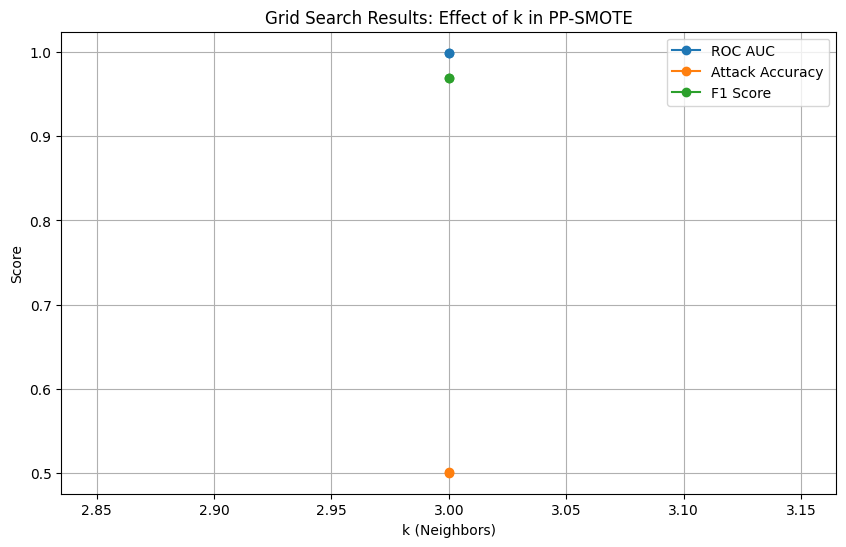

Best Configuration Found:
{'k': 3, 'sensitivity': 1.0, 'privacy_budget': 0.05, 'minority_majority_ratio': 1.0, 'learning_rate': 0.001}


In [16]:
# Function to perform grid search with F1 score calculation
def grid_search():
    best_config = None
    best_auc = -np.inf
    for k in param_grid['k']:
        for sensitivity in param_grid['sensitivity']:
            for privacy_budget in param_grid['privacy_budget']:
                for minority_majority_ratio in param_grid['minority_majority_ratio']:
                    for learning_rate in param_grid['learning_rate']:
                        print(f"Running with k={k}, sensitivity={sensitivity}, privacy_budget={privacy_budget}, ratio={minority_majority_ratio}, lr={learning_rate}...")

                        
                        X_train, X_test, y_train, y_test = train_test_split(X_train_3, y_train_3, random_state=104, test_size=0.5, shuffle=True)
                        
                        # Data scaling and label encoding
                        scaler = MinMaxScaler()
                        label_encoder = LabelEncoder()
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.transform(X_test)
                        y_train = label_encoder.fit_transform(y_train)
                        y_test = label_encoder.transform(y_test)
                        
                        # Build the model
                        model = Sequential()
                        model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
                        model.add(Dropout(0.3))
                        model.add(Dense(64, activation='relu'))
                        model.add(Dropout(0.3))
                        model.add(Dense(32, activation='relu'))
                        model.add(Dropout(0.3))
                        model.add(Dense(16, activation='relu'))
                        model.add(Dropout(0.3))
                        model.add(Dense(12, activation='softmax'))
                        
                        # Compile the model with the current learning rate
                        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, clipnorm=1.0)
                        loss = tf.keras.losses.SparseCategoricalCrossentropy()
                        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
                        
                        # Train the model
                        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, verbose=2)
                        
                        # Evaluate AUC
                        pred_val = model.predict(X_test)
                        auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
                        
                        # Predict classes for F1 score calculation
                        pred_classes = np.argmax(pred_val, axis=1)
                        f1 = f1_score(y_test, pred_classes, average='weighted')
                        
                        # Membership inference attack
                        attack_train_ratio = 0.5
                        attack_train_size = int(len(X_train) * attack_train_ratio)
                        attack_test_size = int(len(X_test) * attack_train_ratio)
                        
                        mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
                        mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
                        mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                                          X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
                        mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
                        mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
                        
                        mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
                        mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
                        mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
                        
                        print(f"AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Attack Accuracy: {mlp_acc_bb:.4f}")
                        
                        # Store the results
                        results['k'].append(k)
                        results['sensitivity'].append(sensitivity)
                        results['privacy_budget'].append(privacy_budget)
                        results['minority_majority_ratio'].append(minority_majority_ratio)
                        results['learning_rate'].append(learning_rate)
                        results['accuracy'].append(auc_score)
                        results['attack_accuracy'].append(mlp_acc_bb)
                        results['f1_score'].append(f1)
                        
                        # Check if the current config meets the criteria
                        if auc_score > 0.9 and mlp_acc_bb < 0.6 and auc_score > best_auc:
                            best_auc = auc_score
                            best_config = {
                                'k': k,
                                'sensitivity': sensitivity,
                                'privacy_budget': privacy_budget,
                                'minority_majority_ratio': minority_majority_ratio,
                                'learning_rate': learning_rate
                            }
    
    return best_config, results

# Perform grid search
best_config, results = grid_search()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='ROC AUC')
plt.plot(results_df['k'], results_df['attack_accuracy'], marker='o', label='Attack Accuracy')
plt.plot(results_df['k'], results_df['f1_score'], marker='o', label='F1 Score')
plt.title('Grid Search Results: Effect of k in PP-SMOTE')
plt.xlabel('k (Neighbors)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('Grid_Search_PP-SMOTE.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Print the best configuration
if best_config:
    print("Best Configuration Found:")
    print(best_config)
else:
    print("No configuration met the criteria.")

Train on 681544 samples, validate on 454364 samples


2024-10-04 02:24:23.447833: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_129/bias/Assign' id:21474 op device:{requested: '', assigned: ''} def:{{{node dense_129/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_129/bias, dense_129/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-04 02:24:36.479364: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_25/mul' id:21538 op device:{requested: '', assigned: ''} def:{{{node loss_25/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_25/mul/x, loss_25/dense_129_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


681544/681544 - 19s - loss: 0.1491 - acc: 0.9541 - val_loss: 0.0654 - val_acc: 0.9757 - 19s/epoch - 28us/sample
Epoch 2/30
681544/681544 - 18s - loss: 0.0517 - acc: 0.9808 - val_loss: 0.0452 - val_acc: 0.9829 - 18s/epoch - 26us/sample
Epoch 3/30
681544/681544 - 18s - loss: 0.0421 - acc: 0.9841 - val_loss: 0.0384 - val_acc: 0.9858 - 18s/epoch - 26us/sample
Epoch 4/30
681544/681544 - 18s - loss: 0.0375 - acc: 0.9861 - val_loss: 0.0358 - val_acc: 0.9869 - 18s/epoch - 26us/sample
Epoch 5/30
681544/681544 - 18s - loss: 0.0350 - acc: 0.9871 - val_loss: 0.0330 - val_acc: 0.9890 - 18s/epoch - 26us/sample
Epoch 6/30
681544/681544 - 18s - loss: 0.0340 - acc: 0.9873 - val_loss: 0.0330 - val_acc: 0.9874 - 18s/epoch - 26us/sample
Epoch 7/30
681544/681544 - 18s - loss: 0.0332 - acc: 0.9878 - val_loss: 0.0374 - val_acc: 0.9866 - 18s/epoch - 26us/sample
Epoch 8/30
681544/681544 - 18s - loss: 0.0327 - acc: 0.9878 - val_loss: 0.0275 - val_acc: 0.9897 - 18s/epoch - 26us/sample
Epoch 9/30
681544/681544 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-04 02:33:19.921342: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_129/Softmax' id:21480 op device:{requested: '', assigned: ''} def:{{{node dense_129/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_129/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9999, F1 Score: 0.9903, Attack Accuracy: 0.5934
SMOTE -> Mean Confidence: 0.9884, Variance: 0.0030, Acc: 0.9903, F1: 0.9903


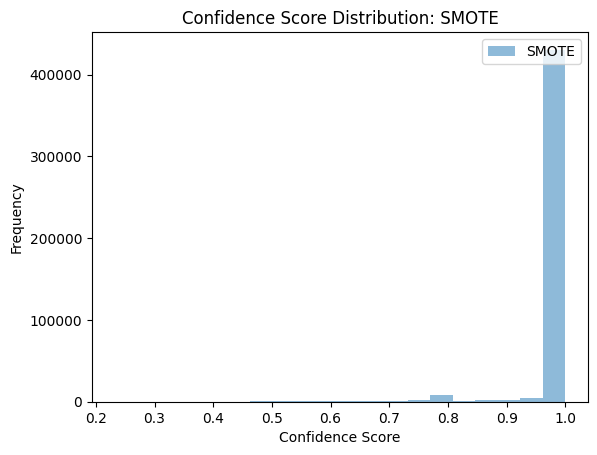

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Hyperparameter grid
param_grid = {
    'k': [3],
    'sensitivity': [1.0],
    'privacy_budget': [1.0],
    'minority_majority_ratio': [1.0],
    'learning_rate': [0.001]
}

# Initialize results storage
results = {
    'k': [],
    'sensitivity': [],
    'privacy_budget': [],
    'minority_majority_ratio': [],
    'learning_rate': [],
    'accuracy': [],
    'attack_accuracy': [],
    'f1_score': []
}
#ratio = 0.15
#sampling_strategy = {0: int(len(y[y == 0]) * ratio),
#                         1: int(len(y[y == 1]) * ratio),
#                         2: int(len(y[y == 2]) * ratio),
#                         3: int(len(y[y == 3]) * ratio),
#                         4: int(len(y[y == 4]) * ratio),
#                         5: int(len(y[y == 5]) * ratio),
#                         6: int(len(y[y == 6]) * ratio),
#                         7: int(len(y[y == 7]) * ratio),
#                         8: int(len(y[y == 8]) * ratio),
#                         9: int(len(y[y == 9]) * ratio),
#                         10: int(len(y[y == 10]) * ratio),
#                         11: int(len(y[y == 11]) * ratio)}
    
# Apply the RandomUnderSampler
#rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
#X_resampled, y_resampled = rus.fit_resample(X, y)

# Initialize SMOTE and PP-SMOTE
smote = SMOTE(k_neighbors=5)
#pp_smote = PPSMOTE(k_neighbors=3, random_state=42)

# Apply SMOTE oversampling
X_train_smote_1, y_train_smote_1 = smote.fit_resample(X, y)

# Split both SMOTE and PP-SMOTE data into train and test sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_train_smote_1, y_train_smote_1, test_size=0.4, 
                                                                            random_state=104, shuffle=True)

# Data scaling and label encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X_train_smote = scaler.fit_transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)
y_train_smote = label_encoder.fit_transform(y_train_smote)
y_test_smote = label_encoder.transform(y_test_smote)

def build_and_train_model_smote(X_train, y_train, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
    #model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    #model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, validation_data=(X_test_smote, y_test_smote),epochs=30, batch_size=128, verbose=2)
    
    return model
    
# Function to calculate confidence score statistics
def calculate_confidence_scores(model, X_test, y_test):
    # Predict the probabilities for the test set
    predictions = model.predict(X_test)
    # Get the predicted class labels
    pred_classes = np.argmax(predictions, axis=1)
    # Get the confidence scores (max probability for each prediction)
    confidence_scores = np.max(predictions, axis=1)
    
    # Calculate metrics: mean and variance of the confidence scores
    mean_confidence = np.mean(confidence_scores)
    confidence_variance = np.var(confidence_scores)
    
    # Evaluate accuracy and F1 score
    f1 = f1_score(y_test, pred_classes, average='weighted')
    accuracy = np.mean(pred_classes == y_test)

    pred_val = model.predict(X_test)
    auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
    X_train = X_train_smote   
    y_train = y_train_smote
    # Membership inference attack
    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train) * attack_train_ratio)
    attack_test_size = int(len(X_test) * attack_train_ratio)
               
    mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
    mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
    mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                                  X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
    mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
                 
    mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
    mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
    mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
    print(f"AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Attack Accuracy: {mlp_acc_bb:.4f}")
    
    return mean_confidence, confidence_variance, accuracy, f1, confidence_scores

# Apply PP-SMOTE and SMOTE and compare confidence scores
def compare_smote_vs_ppsmote():
    # Train and evaluate on SMOTE data
    model_smote = build_and_train_model_smote(X_train_smote, y_train_smote)
    mean_conf_smote, var_conf_smote, acc_smote, f1_smote, confidence_scores_smote = calculate_confidence_scores(model_smote, X_test_smote, y_test_smote)
     # Print and compare results
    print(f"SMOTE -> Mean Confidence: {mean_conf_smote:.4f}, Variance: {var_conf_smote:.4f}, Acc: {acc_smote:.4f}, F1: {f1_smote:.4f}")
   
    # Compare confidence distributions using histograms
    plt.hist(confidence_scores_smote, bins=20, alpha=0.5, label='SMOTE')
    #plt.hist(confidence_scores_ppsmote, bins=20, alpha=0.5, label='PP-SMOTE')
    plt.legend(loc='upper right')
    plt.title('Confidence Score Distribution: SMOTE')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.savefig('Conf_Score_SMOTE.jpg', dpi=300, bbox_inches='tight')

    plt.show()

# Call the function to compare and visualize results
compare_smote_vs_ppsmote()


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
import tensorflow_privacy as tf_privacy

from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Initialize SMOTE and PP-SMOTE
smote = SMOTE(k_neighbors=5)
#pp_smote = PPSMOTE(k_neighbors=3, random_state=42)

# Apply SMOTE oversampling
X_train_smote_1, y_train_smote_1 = smote.fit_resample(X, y)

# Split both SMOTE and PP-SMOTE data into train and test sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_train_smote_1, y_train_smote_1, test_size=0.4, 
                                                                            random_state=104, shuffle=True)

# Data scaling and label encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X_train_smote = scaler.fit_transform(X_train_smote)
X_test_smote = scaler.transform(X_test_smote)
y_train_smote = label_encoder.fit_transform(y_train_smote)
y_test_smote = label_encoder.transform(y_test_smote)




X_train shape: (681544, 83), y_train shape: (681544,)
X_test_smote shape: (454364, 83), y_test_smote shape: (454364,)
Train on 681544 samples, validate on 454364 samples
Epoch 1/30


2024-10-04 23:35:24.549912: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_28/kernel/Assign' id:4217 op device:{requested: '', assigned: ''} def:{{{node dense_28/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_28/kernel, dense_28/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-04 23:35:39.006430: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_5/mul' id:4314 op device:{requested: '', assigned: ''} def:{{{node loss_5/mul}} = 

681544/681544 - 20s - loss: 2.4745 - acc: 0.1368 - val_loss: 2.4582 - val_acc: 0.1526 - 20s/epoch - 30us/sample
Epoch 2/30
681544/681544 - 20s - loss: 2.4290 - acc: 0.1478 - val_loss: 2.4076 - val_acc: 0.2310 - 20s/epoch - 29us/sample
Epoch 3/30
681544/681544 - 20s - loss: 2.3707 - acc: 0.1503 - val_loss: 2.3166 - val_acc: 0.1969 - 20s/epoch - 30us/sample
Epoch 4/30
681544/681544 - 20s - loss: 2.2792 - acc: 0.2641 - val_loss: 2.2478 - val_acc: 0.2330 - 20s/epoch - 29us/sample
Epoch 5/30
681544/681544 - 20s - loss: 2.1213 - acc: 0.2291 - val_loss: 2.0275 - val_acc: 0.2436 - 20s/epoch - 29us/sample
Epoch 6/30
681544/681544 - 20s - loss: 1.9176 - acc: 0.4027 - val_loss: 1.8084 - val_acc: 0.4590 - 20s/epoch - 30us/sample
Epoch 7/30
681544/681544 - 21s - loss: 1.7109 - acc: 0.5299 - val_loss: 1.6064 - val_acc: 0.5957 - 21s/epoch - 30us/sample
Epoch 8/30
681544/681544 - 20s - loss: 1.4598 - acc: 0.5943 - val_loss: 1.3434 - val_acc: 0.6677 - 20s/epoch - 30us/sample
Epoch 9/30
681544/681544 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-04 23:45:27.499348: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_29/Softmax' id:4249 op device:{requested: '', assigned: ''} def:{{{node dense_29/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_29/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9676, F1 Score: 0.7866, Attack Accuracy: 0.5490
SMOTE -> Mean Confidence: 0.7567, Variance: 0.0358, Acc: 0.7775, F1: 0.7866


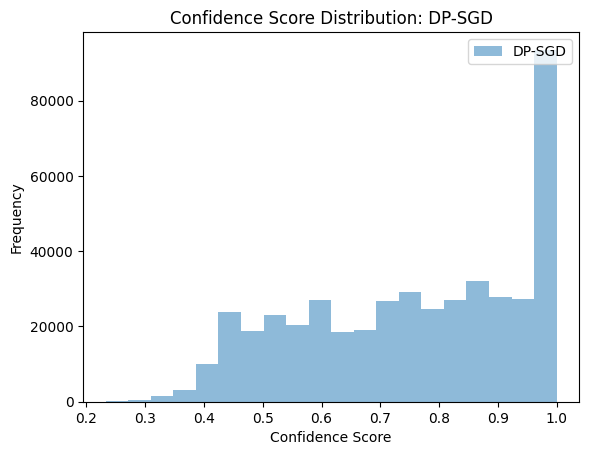

In [14]:
from tensorflow_privacy.privacy.analysis.rdp_accountant import compute_rdp
from tensorflow_privacy.privacy.analysis.rdp_accountant import get_privacy_spent

def compute_epsilon(steps):  
  orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
  sampling_probability = 128 / 681544
  rdp = compute_rdp(q=sampling_probability,
                    noise_multiplier=5.0,
                    steps=steps,
                    orders=orders)
  return get_privacy_spent(orders, rdp, target_delta=1e-5)[0]

def build_and_train_model_smote(X_train, y_train, learning_rate=0.001, noise_multiplier=5.0, l2_norm_clip=1.0):
    model = Sequential()
    model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(12, activation='softmax'))
    batch_size = min(128, X_train.shape[0])
    # Use the DPAdamOptimizer from TensorFlow Privacy
    optimizer = tf_privacy.DPAdamGaussianOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=1,  # Set according to your batch size
        learning_rate=learning_rate
    )
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test_smote shape: {X_test_smote.shape}, y_test_smote shape: {y_test_smote.shape}")

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, validation_data=(X_test_smote, y_test_smote), epochs=30, batch_size=batch_size, verbose=2)
    eps = compute_epsilon(30 * 681544 // 128)
    print('For delta=1e-5, the current epsilon is: %.2f' % eps)
    return model

# Function to calculate confidence score statistics
def calculate_confidence_scores(model, X_test, y_test):
    predictions = model.predict(X_test)
    pred_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    mean_confidence = np.mean(confidence_scores)
    confidence_variance = np.var(confidence_scores)
    
    f1 = f1_score(y_test, pred_classes, average='weighted')
    accuracy = np.mean(pred_classes == y_test)

    pred_val = model.predict(X_test)
    auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
    
    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train_smote) * attack_train_ratio)
    attack_test_size = int(len(X_test_smote) * attack_train_ratio)
               
    mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
    mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
    mlp_attack_bb.fit(X_train_smote[:attack_train_size].astype(np.float32), y_train_smote[:attack_train_size].astype(np.float32),
                      X_test_smote[:attack_test_size].astype(np.float32), y_test_smote[:attack_test_size].astype(np.float32))
    
    mlp_inferred_train_bb = mlp_attack_bb.infer(X_train_smote[attack_train_size:].astype(np.float32), y_train_smote[attack_train_size:])
    mlp_inferred_test_bb = mlp_attack_bb.infer(X_test_smote[attack_test_size:].astype(np.float32), y_test_smote[attack_test_size:])
                 
    mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
    mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
    mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
    print(f"AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Attack Accuracy: {mlp_acc_bb:.4f}")
    
    return mean_confidence, confidence_variance, accuracy, f1, confidence_scores

# Apply PP-SMOTE and SMOTE and compare confidence scores
def compare_smote_vs_ppsmote():
    model_smote = build_and_train_model_smote(X_train_smote, y_train_smote)
    mean_conf_smote, var_conf_smote, acc_smote, f1_smote, confidence_scores_smote = calculate_confidence_scores(model_smote, X_test_smote, y_test_smote)
    print(f"SMOTE -> Mean Confidence: {mean_conf_smote:.4f}, Variance: {var_conf_smote:.4f}, Acc: {acc_smote:.4f}, F1: {f1_smote:.4f}")
   
    plt.hist(confidence_scores_smote, bins=20, alpha=0.5, label='DP-SGD')
    plt.legend(loc='upper right')
    plt.title('Confidence Score Distribution: DP-SGD')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.savefig('Conf_Score_DPSGD-up.jpg', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to compare and visualize results
compare_smote_vs_ppsmote()


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Hyperparameter grid
param_grid = {
    'k': [3],
    'sensitivity': [1.0],
    'privacy_budget': [0.5],
    'minority_majority_ratio': [1.0],
    'learning_rate': [0.001]
}

# Initialize results storage
results = {
    'k': [],
    'sensitivity': [],
    'privacy_budget': [],
    'minority_majority_ratio': [],
    'learning_rate': [],
    'accuracy': [],
    'attack_accuracy': [],
    'f1_score': []
}

#ratio = 0.15
#sampling_strategy = {0: int(len(y[y == 0]) * ratio),
#                         1: int(len(y[y == 1]) * ratio),
#                         2: int(len(y[y == 2]) * ratio),
#                         3: int(len(y[y == 3]) * ratio),
#                         4: int(len(y[y == 4]) * ratio),
#                         5: int(len(y[y == 5]) * ratio),
#                         6: int(len(y[y == 6]) * ratio),
#                         7: int(len(y[y == 7]) * ratio),
#                         8: int(len(y[y == 8]) * ratio),
#                         9: int(len(y[y == 9]) * ratio),
#                         10: int(len(y[y == 10]) * ratio),
#                         11: int(len(y[y == 11]) * ratio)}
    
# Apply the RandomUnderSampler
#rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
#X_resampled, y_resampled = rus.fit_resample(X, y)

# Initialize SMOTE and PP-SMOTE
pp_smote = PPSMOTE(k_neighbors=3, random_state=42)

# Apply PP-SMOTE oversampling
X_train_ppsmote_1, y_train_ppsmote_1 = pp_smote.oversample(X, y, param_grid['privacy_budget'], merge=True)



Train on 567954 samples


2024-10-04 01:55:21.093851: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_115/bias/Assign' id:19865 op device:{requested: '', assigned: ''} def:{{{node dense_115/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_115/bias, dense_115/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/30
567954/567954 - 13s - loss: 1.2566 - acc: 0.5444 - 13s/epoch - 23us/sample
Epoch 2/30
567954/567954 - 13s - loss: 0.9298 - acc: 0.6863 - 13s/epoch - 23us/sample
Epoch 3/30
567954/567954 - 13s - loss: 0.8738 - acc: 0.7078 - 13s/epoch - 23us/sample
Epoch 4/30
567954/567954 - 13s - loss: 0.8308 - acc: 0.7224 - 13s/epoch - 23us/sample
Epoch 5/30
567954/567954 - 13s - loss: 0.8077 - acc: 0.7322 - 13s/epoch - 23us/sample
Epoch 6/30
567954/567954 - 13s - loss: 0.7894 - acc: 0.7383 - 13s/epoch - 22us/sample
Epoch 7/30
567954/567954 - 13s - loss: 0.7544 - acc: 0.7532 - 13s/epoch - 23us/sample
Epoch 8/30
567954/567954 - 13s - loss: 0.7254 - acc: 0.7641 - 13s/epoch - 23us/sample
Epoch 9/30
567954/567954 - 13s - loss: 0.7026 - acc: 0.7717 - 13s/epoch - 23us/sample
Epoch 10/30
567954/567954 - 13s - loss: 0.7004 - acc: 0.7740 - 13s/epoch - 23us/sample
Epoch 11/30
567954/567954 - 13s - loss: 0.6860 - acc: 0.7784 - 13s/epoch - 23us/sample
Epoch 12/30
567954/567954 - 13s - loss: 0.6753 - acc

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-04 02:01:48.901905: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_119/Softmax' id:20019 op device:{requested: '', assigned: ''} def:{{{node dense_119/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_119/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9817, F1 Score: 0.8595, Attack Accuracy: 0.5008
PP-SMOTE -> Mean Confidence: 0.7818, Variance: 0.0641, Acc: 0.8728, F1: 0.8595


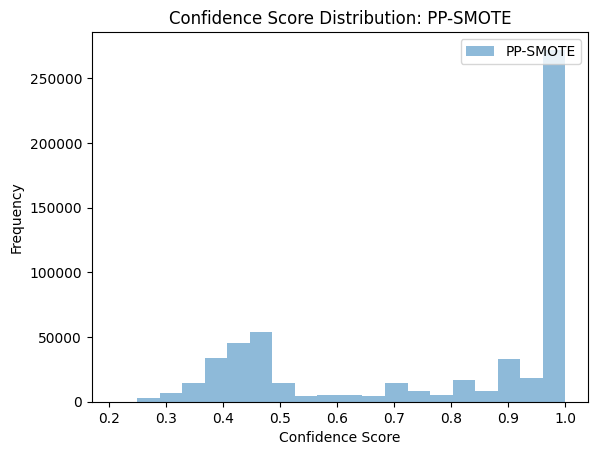

In [31]:
# Split both SMOTE and PP-SMOTE data into train and test sets
X_train_ppsmote, X_test_ppsmote, y_train_ppsmote, y_test_ppsmote = train_test_split(X_train_ppsmote_1, y_train_ppsmote_1, 
                                                                                    test_size=0.5, random_state=104, shuffle=True)

# Data scaling and label encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X_train_ppsmote = scaler.fit_transform(X_train_ppsmote)
X_test_ppsmote = scaler.transform(X_test_ppsmote)
y_train_ppsmote = label_encoder.fit_transform(y_train_ppsmote)
y_test_ppsmote = label_encoder.transform(y_test_ppsmote)

# Function to build and train the model
def build_and_train_model(X_train, y_train, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(12, activation='softmax'))
    
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=2)
    
    return model

   
# Function to calculate confidence score statistics
def calculate_confidence_scores(model, X_test, y_test):
    # Predict the probabilities for the test set
    predictions = model.predict(X_test)
    # Get the predicted class labels
    pred_classes = np.argmax(predictions, axis=1)
    # Get the confidence scores (max probability for each prediction)
    confidence_scores = np.max(predictions, axis=1)
    
    # Calculate metrics: mean and variance of the confidence scores
    mean_confidence = np.mean(confidence_scores)
    confidence_variance = np.var(confidence_scores)
    
    # Evaluate accuracy and F1 score
    f1 = f1_score(y_test, pred_classes, average='weighted')
    accuracy = np.mean(pred_classes == y_test)

    pred_val = model.predict(X_test)
    auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
    X_train = X_train_ppsmote  
    y_train = y_train_ppsmote
    # Membership inference attack
    attack_train_ratio = 0.5
    attack_train_size = int(len(X_train) * attack_train_ratio)
    attack_test_size = int(len(X_test) * attack_train_ratio)
               
    mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
    mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
    mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                                  X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
    mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
    mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
                 
    mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
    mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
    mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
    print(f"AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Attack Accuracy: {mlp_acc_bb:.4f}")
    
    return mean_confidence, confidence_variance, accuracy, f1, confidence_scores

# Apply PP-SMOTE and SMOTE and compare confidence scores
def compare_smote_vs_ppsmote():

    # Train and evaluate on PP-SMOTE data
    model_ppsmote = build_and_train_model(X_train_ppsmote, y_train_ppsmote)
    mean_conf_ppsmote, var_conf_ppsmote, acc_ppsmote, f1_ppsmote, confidence_scores_ppsmote = calculate_confidence_scores(model_ppsmote,X_test_ppsmote, y_test_ppsmote)
    print(f"PP-SMOTE -> Mean Confidence: {mean_conf_ppsmote:.4f}, Variance: {var_conf_ppsmote:.4f}, Acc: {acc_ppsmote:.4f}, F1: {f1_ppsmote:.4f}")
    
    # Compare confidence distributions using histograms
    #plt.hist(confidence_scores_smote, bins=20, alpha=0.5, label='SMOTE')
    plt.hist(confidence_scores_ppsmote, bins=20, alpha=0.5, label='PP-SMOTE')
    plt.legend(loc='upper right')
    plt.title('Confidence Score Distribution: PP-SMOTE')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.savefig('Conf_Score_PP_SMOTE.jpg', dpi=300, bbox_inches='tight')

    plt.show()

# Call the function to compare and visualize results
compare_smote_vs_ppsmote()


Running with k=3, sensitivity=1.0, privacy_budget=0.05, ratio=1.0, lr=0.001...
Train on 567954 samples, validate on 567954 samples
Epoch 1/30


2024-10-02 21:49:56.900200: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/Adam/dense_8/bias/v/Assign' id:1200 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_8/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_8/bias/v, training_2/Adam/dense_8/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-10-02 21:50:11.830335: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/mul' id:1014 op device:{reque

567954/567954 - 24s - loss: 0.2802 - acc: 0.9145 - val_loss: 0.1437 - val_acc: 0.9510 - 24s/epoch - 42us/sample
Epoch 2/30
567954/567954 - 23s - loss: 0.1151 - acc: 0.9607 - val_loss: 0.1026 - val_acc: 0.9631 - 23s/epoch - 41us/sample
Epoch 3/30
567954/567954 - 20s - loss: 0.0944 - acc: 0.9669 - val_loss: 0.0766 - val_acc: 0.9725 - 20s/epoch - 36us/sample
Epoch 4/30
567954/567954 - 16s - loss: 0.0784 - acc: 0.9727 - val_loss: 0.0731 - val_acc: 0.9752 - 16s/epoch - 27us/sample
Epoch 5/30
567954/567954 - 15s - loss: 0.0679 - acc: 0.9770 - val_loss: 0.0567 - val_acc: 0.9805 - 15s/epoch - 27us/sample
Epoch 6/30
567954/567954 - 16s - loss: 0.0608 - acc: 0.9793 - val_loss: 0.0595 - val_acc: 0.9798 - 16s/epoch - 28us/sample
Epoch 7/30
567954/567954 - 15s - loss: 0.0583 - acc: 0.9800 - val_loss: 0.0601 - val_acc: 0.9801 - 15s/epoch - 27us/sample
Epoch 8/30
567954/567954 - 16s - loss: 0.0561 - acc: 0.9809 - val_loss: 0.0513 - val_acc: 0.9827 - 16s/epoch - 27us/sample
Epoch 9/30
567954/567954 - 

/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-10-02 21:58:04.530429: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_9/Softmax' id:956 op device:{requested: '', assigned: ''} def:{{{node dense_9/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_9/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


AUC: 0.9998, F1 Score: 0.9848, Attack Accuracy: 0.5008


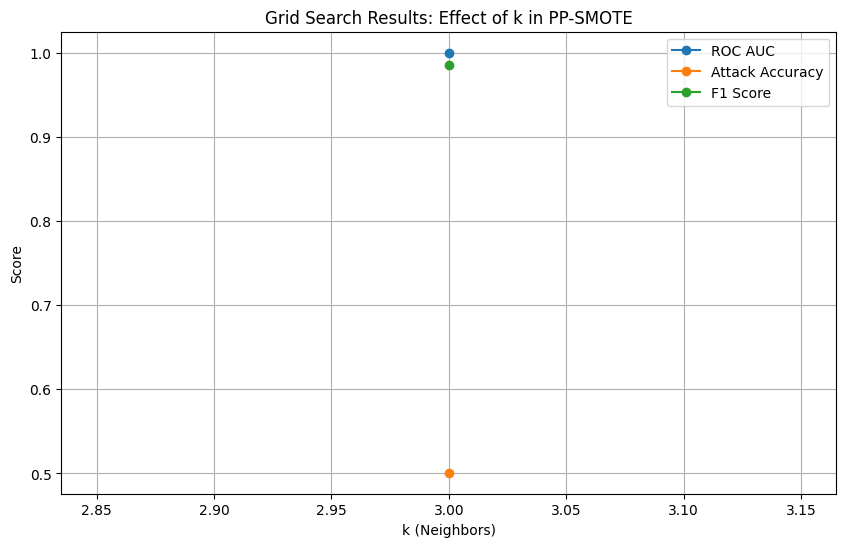

Best Configuration Found:
{'k': 3, 'sensitivity': 1.0, 'privacy_budget': 0.05, 'minority_majority_ratio': 1.0, 'learning_rate': 0.001}


In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def grid_search():
    best_config = None
    best_auc = -np.inf
    for k in param_grid['k']:
        for sensitivity in param_grid['sensitivity']:
            for privacy_budget in param_grid['privacy_budget']:
                for minority_majority_ratio in param_grid['minority_majority_ratio']:
                    for learning_rate in param_grid['learning_rate']:
                        print(f"Running with k={k}, sensitivity={sensitivity}, privacy_budget={privacy_budget}, ratio={minority_majority_ratio}, lr={learning_rate}...")

                        X_train, X_test, y_train, y_test = train_test_split(X_train_3, y_train_3, random_state=104, test_size=0.5, shuffle=True)
                        
                        # Data scaling and label encoding
                        scaler = MinMaxScaler()
                        label_encoder = LabelEncoder()
                        X_train = scaler.fit_transform(X_train)
                        X_test = scaler.transform(X_test)
                        y_train = label_encoder.fit_transform(y_train)
                        y_test = label_encoder.transform(y_test)
                        
                        # Build the model
                        model = Sequential()
                        model.add(Dense(83, activation='relu', input_dim=83, kernel_constraint=MaxNorm(3)))
                        #model.add(Dropout(0.3))
                        model.add(Dense(64, activation='relu'))
                        #model.add(Dropout(0.3))
                        model.add(Dense(32, activation='relu'))
                        #model.add(Dropout(0.3))
                        model.add(Dense(16, activation='relu'))
                        #model.add(Dropout(0.3))
                        model.add(Dense(12, activation='softmax'))
                        
                        # Compile the model with the current learning rate
                        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, clipnorm=1.0)
                        loss = tf.keras.losses.SparseCategoricalCrossentropy()
                        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
                        
                        # Train the model and collect history
                        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, verbose=2)
                        
                        # Plot and save loss-epoch curve
                        plt.figure()
                        plt.plot(history.history['loss'], label='Training Loss')
                        plt.plot(history.history['val_loss'], label='Validation Loss')
                        plt.title('Loss vs Epochs')
                        plt.xlabel('Epochs')
                        plt.ylabel('Loss')
                        plt.legend()
                        plt.grid(True)
                        plt.savefig(f'loss_epoch_curve_k_{k}.jpg', dpi=300, bbox_inches='tight')
                        plt.close()

                        # Evaluate AUC
                        pred_val = model.predict(X_test)
                        auc_score = roc_auc_score(y_test, pred_val, multi_class='ovr')
                        
                        # Predict classes for F1 score calculation
                        pred_classes = np.argmax(pred_val, axis=1)
                        f1 = f1_score(y_test, pred_classes, average='weighted')
                        
                        # Membership inference attack
                        attack_train_ratio = 0.5
                        attack_train_size = int(len(X_train) * attack_train_ratio)
                        attack_test_size = int(len(X_test) * attack_train_ratio)
                        
                        mlp_art_model = KerasClassifier(model=model, clip_values=(0, 1))
                        mlp_attack_bb = MembershipInferenceBlackBox(mlp_art_model, attack_model_type='rf')
                        mlp_attack_bb.fit(X_train[:attack_train_size].astype(np.float32), y_train[:attack_train_size].astype(np.float32),
                                          X_test[:attack_test_size].astype(np.float32), y_test[:attack_test_size].astype(np.float32))
                        mlp_inferred_train_bb = mlp_attack_bb.infer(X_train[attack_train_size:].astype(np.float32), y_train[attack_train_size:])
                        mlp_inferred_test_bb = mlp_attack_bb.infer(X_test[attack_test_size:].astype(np.float32), y_test[attack_test_size:])
                        
                        mlp_train_acc_bb = np.sum(mlp_inferred_train_bb) / len(mlp_inferred_train_bb)
                        mlp_test_acc_bb = 1 - (np.sum(mlp_inferred_test_bb) / len(mlp_inferred_test_bb))
                        mlp_acc_bb = (mlp_train_acc_bb * len(mlp_inferred_train_bb) + mlp_test_acc_bb * len(mlp_inferred_test_bb)) / (len(mlp_inferred_train_bb) + len(mlp_inferred_test_bb))
                        
                        print(f"AUC: {auc_score:.4f}, F1 Score: {f1:.4f}, Attack Accuracy: {mlp_acc_bb:.4f}")
                        
                        # Store the results
                        results['k'].append(k)
                        results['sensitivity'].append(sensitivity)
                        results['privacy_budget'].append(privacy_budget)
                        results['minority_majority_ratio'].append(minority_majority_ratio)
                        results['learning_rate'].append(learning_rate)
                        results['accuracy'].append(auc_score)
                        results['attack_accuracy'].append(mlp_acc_bb)
                        results['f1_score'].append(f1)
                        
                        # Plot and save ROC curve for the best config
                        if auc_score > best_auc:
                            best_auc = auc_score
                            best_config = {
                                'k': k,
                                'sensitivity': sensitivity,
                                'privacy_budget': privacy_budget,
                                'minority_majority_ratio': minority_majority_ratio,
                                'learning_rate': learning_rate
                            }

                            fpr = {}
                            tpr = {}
                            roc_auc = {}

                            for i in range(12):  # assuming 12 classes for multi-class
                                fpr[i], tpr[i], _ = roc_curve(y_test, pred_val[:, i], pos_label=i)
                                roc_auc[i] = auc(fpr[i], tpr[i])

                            plt.figure()
                            for i in range(12):
                                plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
                            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
                            plt.xlim([0.0, 1.0])
                            plt.ylim([0.0, 1.05])
                            plt.xlabel('False Positive Rate')
                            plt.ylabel('True Positive Rate')
                            plt.title('ROC Curve - Multi-Class')
                            plt.legend(loc='lower right')
                            plt.grid(True)
                            plt.savefig(f'roc_curve_k_{k}.jpg', dpi=300, bbox_inches='tight')
                            plt.close()

    return best_config, results

# Perform grid search
best_config, results = grid_search()

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['accuracy'], marker='o', label='ROC AUC')
plt.plot(results_df['k'], results_df['attack_accuracy'], marker='o', label='Attack Accuracy')
plt.plot(results_df['k'], results_df['f1_score'], marker='o', label='F1 Score')
plt.title('Grid Search Results: Effect of k in PP-SMOTE')
plt.xlabel('k (Neighbors)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.savefig('Grid_Search_PP-SMOTE.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Print the best configuration
if best_config:
    print("Best Configuration Found:")
    print(best_config)
else:
    print("No configuration met the criteria.")


In [91]:
c_dataset = pd.read_csv(r"creditcard.csv")
c_dataset = c_dataset.dropna()
#print(dataset)
c_dataset.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [92]:
X = c_dataset.to_numpy()[:,:30]
y = c_dataset.to_numpy()[:,-1]
unique_values = np.unique(y)
print("Unique values:", unique_values)

Unique values: [0. 1.]


In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
import tensorflow as tf

# Assuming PPSMOTE and the dataset are predefined (since they aren't standard imports)
smote = PPSMOTE(k_neighbors=5, random_state=42)
X_train_3, y_train_3 = smote.oversample(X, y, 0.025, merge=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_3, y_train_3, random_state=104, test_size=0.5, shuffle=True)


Epoch 1/50
2222/2222 - 9s - loss: 0.1796 - accuracy: 0.9324 - val_loss: 0.1467 - val_accuracy: 0.9419 - 9s/epoch - 4ms/step
Epoch 2/50
2222/2222 - 8s - loss: 0.1464 - accuracy: 0.9436 - val_loss: 0.1297 - val_accuracy: 0.9502 - 8s/epoch - 4ms/step
Epoch 3/50
2222/2222 - 8s - loss: 0.1250 - accuracy: 0.9519 - val_loss: 0.1180 - val_accuracy: 0.9539 - 8s/epoch - 4ms/step
Epoch 4/50
2222/2222 - 8s - loss: 0.1026 - accuracy: 0.9598 - val_loss: 0.0942 - val_accuracy: 0.9659 - 8s/epoch - 4ms/step
Epoch 5/50
2222/2222 - 8s - loss: 0.0789 - accuracy: 0.9681 - val_loss: 0.0744 - val_accuracy: 0.9683 - 8s/epoch - 4ms/step
Epoch 6/50
2222/2222 - 8s - loss: 0.0622 - accuracy: 0.9751 - val_loss: 0.0530 - val_accuracy: 0.9773 - 8s/epoch - 4ms/step
Epoch 7/50
2222/2222 - 8s - loss: 0.0507 - accuracy: 0.9808 - val_loss: 0.0644 - val_accuracy: 0.9720 - 8s/epoch - 4ms/step
Epoch 8/50
2222/2222 - 8s - loss: 0.0425 - accuracy: 0.9842 - val_loss: 0.0335 - val_accuracy: 0.9891 - 8s/epoch - 4ms/step
Epoch 9/

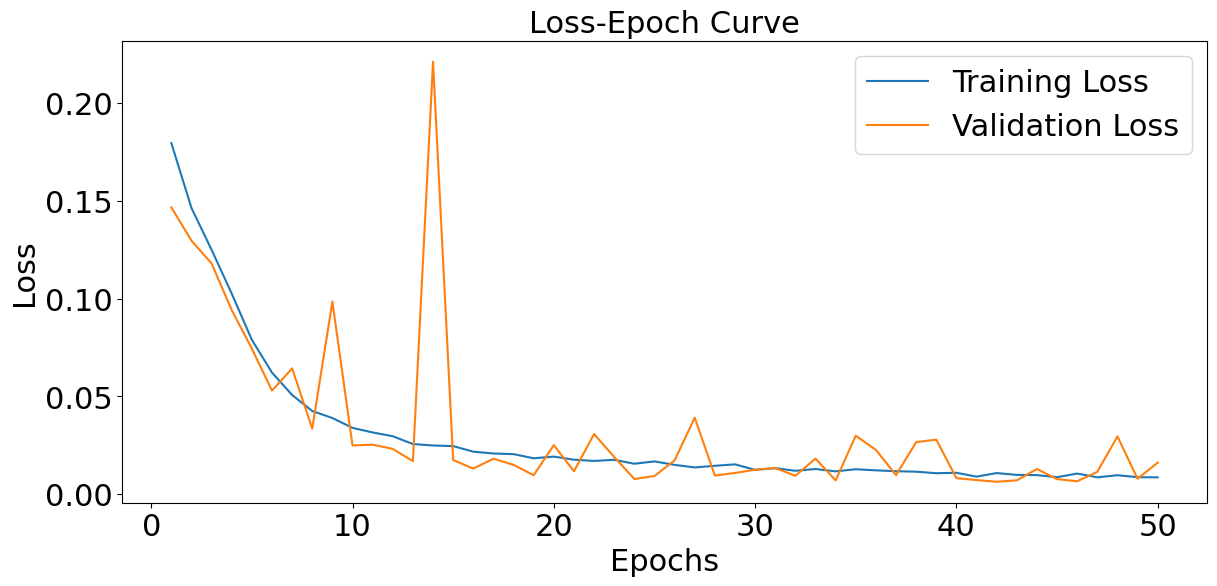

In [94]:

# Data scaling and label encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform (not fit_transform) on test data

label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Model for binary classification
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=30, kernel_constraint=MaxNorm(3)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Changed to 1 output neuron for binary classification

# Compile the model with BinaryCrossentropy loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()  # Changed to binary cross-entropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=128,
                        verbose=2)



# Loss and accuracy curves (train vs. validation)
epochs = range(1, len(history.history['loss']) + 1)

plt.rcParams.update({'font.size': 22, 'xtick.labelsize': 22, 'ytick.labelsize': 22})
# Plotting loss-epoch curve
plt.figure(figsize=(14, 6))
#plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss-Epoch Curve',fontsize= 22)
plt.xlabel('Epochs',fontsize= 22)
plt.ylabel('Loss',fontsize= 22)
plt.legend(fontsize= 22)

# Plotting accuracy-epoch curve
#plt.subplot(1, 2, 2)
#plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
#plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Accuracy-Epoch Curve',fontsize= 22)
#plt.xlabel('Epochs',fontsize= 22)
#plt.ylabel('Accuracy',fontsize= 22)
#plt.legend(fontsize= 22)

#plt.tight_layout()
plt.savefig('credit-epoch-curve.png', dpi=300, bbox_inches='tight')

plt.show()




Epoch 1/30
Epoch 1: Gradient Norm = 74.5755615234375
3554/3554 - 9s - loss: 0.1118 - accuracy: 0.9571 - 9s/epoch - 2ms/step
Epoch 2/30
Epoch 2: Gradient Norm = 80.81232452392578
3554/3554 - 8s - loss: 0.1203 - accuracy: 0.9545 - 8s/epoch - 2ms/step
Epoch 3/30
Epoch 3: Gradient Norm = 65.30403137207031
3554/3554 - 8s - loss: 0.1187 - accuracy: 0.9555 - 8s/epoch - 2ms/step
Epoch 4/30
Epoch 4: Gradient Norm = 224.14126586914062
3554/3554 - 8s - loss: 0.1166 - accuracy: 0.9560 - 8s/epoch - 2ms/step
Epoch 5/30
Epoch 5: Gradient Norm = 135.22799682617188
3554/3554 - 8s - loss: 0.1157 - accuracy: 0.9561 - 8s/epoch - 2ms/step
Epoch 6/30
Epoch 6: Gradient Norm = 80.68505096435547
3554/3554 - 8s - loss: 0.1129 - accuracy: 0.9568 - 8s/epoch - 2ms/step
Epoch 7/30
Epoch 7: Gradient Norm = 97.66179656982422
3554/3554 - 8s - loss: 0.1155 - accuracy: 0.9562 - 8s/epoch - 2ms/step
Epoch 8/30
Epoch 8: Gradient Norm = 125.26136016845703
3554/3554 - 8s - loss: 0.1127 - accuracy: 0.9573 - 8s/epoch - 2ms/ste

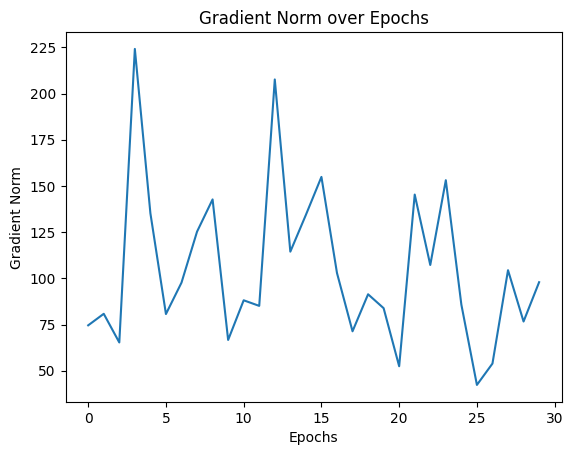

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L2 norm of gradients
def get_gradient_norm(model, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = tf.keras.losses.mean_squared_error(targets, predictions)  # Or any loss function you're using
    gradients = tape.gradient(loss, model.trainable_variables)
    # Compute the L2 norm of gradients
    norm = np.sum([np.linalg.norm(g.numpy()) for g in gradients if g is not None])
    return norm

# Callback to monitor gradient norms over training epochs
class GradientNormMonitor(tf.keras.callbacks.Callback):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        norm = get_gradient_norm(self.model, self.inputs, self.targets)
        self.gradient_norms.append(norm)
        print(f'Epoch {epoch+1}: Gradient Norm = {norm}')

    def plot_gradient_norms(self):
        plt.plot(self.gradient_norms)
        plt.title('Gradient Norm over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Gradient Norm')
        plt.savefig('credit-gradientnorm-curve.png', dpi=300, bbox_inches='tight')

        plt.show()

# Example usage during model training
# Assuming you have a dataset: (X_train, y_train)

inputs = X_train[:100]  # Subsample of data for gradient monitoring
targets = y_train[:100]  # Corresponding labels

gradient_monitor = GradientNormMonitor(inputs, targets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy()
# Compile and train the model with the gradient monitor callback
model.compile(optimizer=optimizer, loss=loss,metrics=['accuracy'],)
history = model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=2, callbacks=[gradient_monitor])

# Plot gradient norm after training
gradient_monitor.plot_gradient_norms()


8885/8885 - 14s - loss: 16.8711 - accuracy: 0.6272 - 14s/epoch - 2ms/step
8885/8885 - 13s - loss: 15.6228 - accuracy: 0.6279 - 13s/epoch - 1ms/step
8885/8885 - 14s - loss: 14.3246 - accuracy: 0.6229 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 12.8386 - accuracy: 0.6221 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 11.1048 - accuracy: 0.6335 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 9.2439 - accuracy: 0.6685 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 7.3738 - accuracy: 0.7083 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 5.5954 - accuracy: 0.7524 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 3.9444 - accuracy: 0.7874 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 2.5955 - accuracy: 0.8296 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 1.6901 - accuracy: 0.8623 - 14s/epoch - 2ms/step
8885/8885 - 13s - loss: 1.2114 - accuracy: 0.8887 - 13s/epoch - 2ms/step
8885/8885 - 14s - loss: 1.1024 - accuracy: 0.9030 - 14s/epoch - 2ms/step
8885/8885 - 14s - loss: 1.2600 - accuracy: 0.9

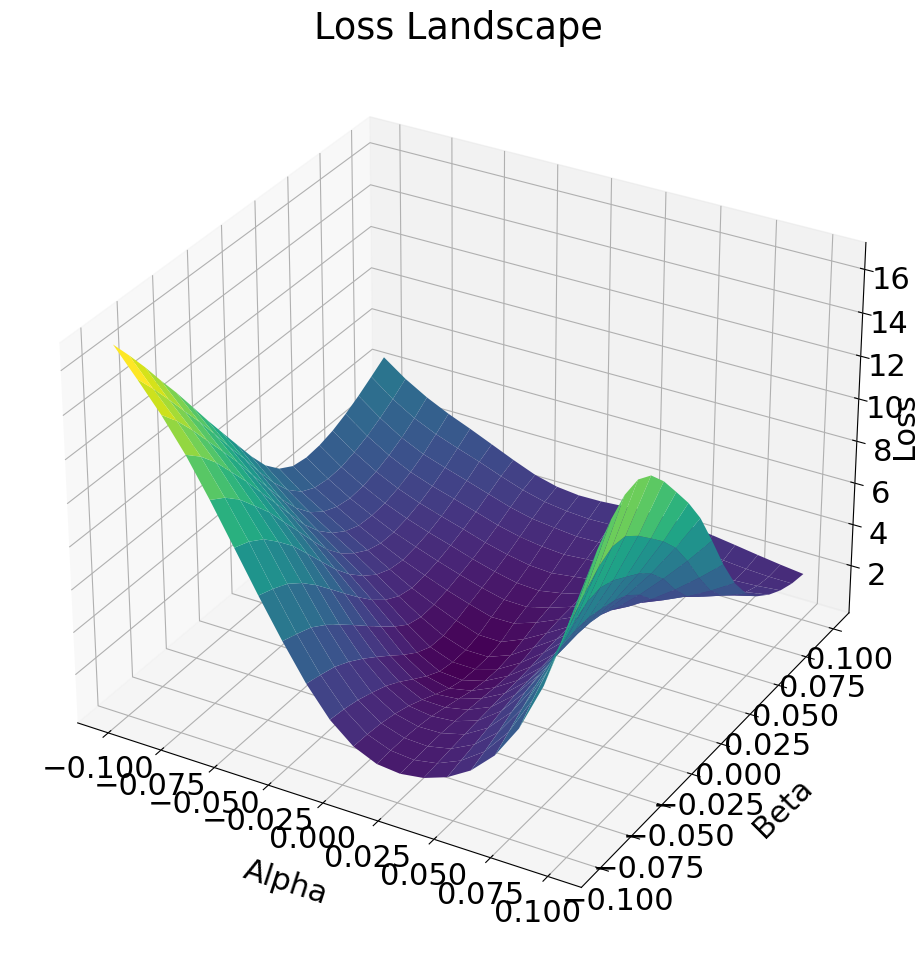

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to perturb model weights along a direction and compute loss
def perturb_and_compute_loss(model, X, y, direction1, direction2, alpha, beta):
    original_weights = model.get_weights()  # Store original weights
    perturbed_weights = []

    # Apply perturbation to the weights
    for i, weight in enumerate(original_weights):
        delta1 = direction1[i] * alpha
        delta2 = direction2[i] * beta
        perturbed_weights.append(weight + delta1 + delta2)

    model.set_weights(perturbed_weights)  # Update model weights
    loss = model.evaluate(X, y, verbose=2)[0]  # Compute loss
    model.set_weights(original_weights)  # Restore original weights
    return loss

# Function to generate random directions in parameter space
def generate_random_directions(model):
    directions = []
    for weight in model.get_weights():
        directions.append(np.random.randn(*weight.shape))
    return directions

# Function to plot the loss landscape
def plot_loss_landscape(model, X, y, alphas, betas):
    direction1 = generate_random_directions(model)
    direction2 = generate_random_directions(model)
    
    loss_values = np.zeros((len(alphas), len(betas)))

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            loss_values[i, j] = perturb_and_compute_loss(model, X, y, direction1, direction2, alpha, beta)

    # Plot the loss landscape as a 3D surface
    plt.figure(figsize=(10, 10))
    A, B = np.meshgrid(alphas, betas)
    ax = plt.axes(projection='3d')
    ax.xaxis.labelpad=20
    ax.yaxis.labelpad=20
    ax.zaxis.labelpad=0
    ax.plot_surface(A, B, loss_values, cmap='viridis')
    ax.set_title('Loss Landscape')
    ax.set_xlabel('Alpha', linespacing=3.2)
    ax.set_ylabel('Beta',rotation=45, linespacing=3.1)
    ax.set_zlabel('Loss',rotation=90, linespacing=1.0)
    plt.tight_layout()
    plt.savefig('credit-loss-landscape-curve-up.png', dpi=300, bbox_inches='tight')

    plt.show()

# Example usage
# Assuming you have a trained model, and X_train and y_train are your data
alphas = np.linspace(-0.1, 0.1, 20)  # Range of perturbations for direction 1
betas = np.linspace(-0.1, 0.1, 20)   # Range of perturbations for direction 2

# Assuming your model is already defined and compiled
plot_loss_landscape(model, X_train, y_train, alphas, betas)


In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# For binary classification, ensure predicted probabilities are the second column (for class 1)
#y_pred_proba = y_pred_proba[:, 1]  # Uncomment this if model.predict gives probabilities for both classes

# 2. Compute Precision-Recall and ROC values

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.rcParams.update({'font.size': 22, 'xtick.labelsize': 22, 'ytick.labelsize': 22})
# 3. Plot Precision-Recall Curve
plt.figure(figsize=(14, 6))
#plt.subplot(1, 2, 1)
#plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
#plt.xlabel('Recall',fontsize=22)
#plt.ylabel('Precision',fontsize=22)
#plt.title('Precision-Recall Curve',fontsize=22)
#plt.legend(loc='lower left',fontsize=16)

#plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate',fontsize=22)
plt.ylabel('True Positive Rate',fontsize=22)
plt.title('ROC Curve',fontsize=22)
plt.legend(loc='lower right',fontsize=16)
#plt.tight_layout()
# Save ROC Curve
plt.savefig('credit-precision-roc-curve.png', dpi=300, bbox_inches='tight')
plt.show()


6581/8885 [=====================>........] - ETA: 2s

KeyboardInterrupt: 

In [96]:
dataset = pd.read_csv(r"PUDF_base1q2009_tab.csv")
dataset = dataset.dropna()
dataset = dataset.drop(['RECORD_ID','PAT_AGE','PAT_STATUS'],axis=1)
dataset['SEX_CODE'] = pd.Categorical(dataset['SEX_CODE']).codes
dataset['ADMITTING_DIAGNOSIS'] = pd.Categorical(dataset['ADMITTING_DIAGNOSIS']).codes
dataset['PRINC_DIAG_CODE'] = pd.Categorical(dataset['PRINC_DIAG_CODE']).codes
dataset['OTH_DIAG_CODE_1'] = pd.Categorical(dataset['OTH_DIAG_CODE_1']).codes
dataset['OCCUR_DAY_1'] = pd.Categorical(dataset['OCCUR_DAY_1']).codes
dataset['OCCUR_CODE_1'] = pd.Categorical(dataset['OCCUR_CODE_1']).codes
dataset['HCFA_MDC'] = pd.Categorical(dataset['HCFA_MDC']).codes
dataset['ETHNICITY'] = pd.Categorical(dataset['ETHNICITY']).codes
dataset['SOURCE_OF_ADMISSION'] = pd.Categorical(dataset['SOURCE_OF_ADMISSION']).codes
dataset['RACE'] = pd.Categorical(dataset['RACE']).codes
dataset['LENGTH_OF_STAY'] = pd.Categorical(dataset['LENGTH_OF_STAY']).codes
dataset['TYPE_OF_ADMISSION'] = pd.Categorical(dataset['TYPE_OF_ADMISSION']).codes
dataset['APR_MDC'] = pd.Categorical(dataset['APR_MDC']).codes
dataset['HCFA_DRG'] = pd.Categorical(dataset['HCFA_DRG']).codes
dataset['APR_DRG'] = pd.Categorical(dataset['APR_DRG']).codes
dataset['ILLNESS_SEVERITY'] = pd.Categorical(dataset['ILLNESS_SEVERITY']).codes
dataset['RISK_MORTALITY'] = pd.Categorical(dataset['RISK_MORTALITY']).codes
RISK_MORTALITY_MAP = {1:0,2:1,3:2,4:3}
dataset['RISK_MORTALITY'] = dataset['RISK_MORTALITY'].replace(RISK_MORTALITY_MAP)

#dataset = dataset.iloc[:3800000]
print(dataset.shape)
dataset.head()

/tmp/ipykernel_1320384/1791046506.py:1: DtypeWarning: Columns (1,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r"PUDF_base1q2009_tab.csv")


(475977, 17)


SEX_CODE  TYPE_OF_ADMISSION  SOURCE_OF_ADMISSION  LENGTH_OF_STAY  RACE  \
0         1                  1                    9               2     3   
1         0                  1                    9               2     2   
2         0                  1                    9              53     2   
3         0                  1                    9               8     2   
4         0                  1                    9              17     3   

   ETHNICITY  ADMITTING_DIAGNOSIS  PRINC_DIAG_CODE  OTH_DIAG_CODE_1  \
0          1                  847              984              971   
1          1                  892             1043             5862   
2          1                  892             1043             5862   
3          1                  892             1043             1047   
4          1                  892             1043             4413   

   OCCUR_CODE_1  OCCUR_DAY_1  HCFA_MDC  APR_MDC  HCFA_DRG  APR_DRG  \
0             2         1610        19       19       673      277   
1             2         1610        19       19       674      275   
2             2         1610        19       19       674      275   
3             2         1610        19       19       674      275   
4             2         1610        19       19       674      275   

   ILLNESS_SEVERITY  RISK_MORTALITY  
0                 1               0  
1                 1               0  
2                 2               0  
3                 2               0  
4                 1               0

In [97]:
from sklearn.preprocessing import MinMaxScaler

sm_dataset_0 = dataset.query("RISK_MORTALITY == 0").iloc[1:60000]
sm_dataset_1 = dataset.query("RISK_MORTALITY == 1").iloc[1:60000]
sm_dataset_2 = dataset.query("RISK_MORTALITY == 2").iloc[1:60000]
sm_dataset_3 = dataset.query("RISK_MORTALITY == 3").iloc[1:60000]
sm_dataset = pd.concat([sm_dataset_0, sm_dataset_1, sm_dataset_2, sm_dataset_3])
sm_dataset.head()
print(len(sm_dataset_0))
print(len(sm_dataset_1))
print(len(sm_dataset_2))
print(len(sm_dataset_3))
#scaler = MinMaxScaler()
#X_orig = sm_dataset.to_numpy()
#X_orig = scaler.fit_transform(X_orig)
#np.unique(X_orig[:-1])
#X_orig.shape

59999
59999
59999
23610


In [98]:
X = sm_dataset.to_numpy()[:,:16]
y = sm_dataset.to_numpy()[:,-1]
unique_values = np.unique(y)
print("Unique values:", unique_values)

Unique values: [0 1 2 3]


In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
import tensorflow as tf

# Assuming PPSMOTE and the dataset are predefined (since they aren't standard imports)
smote = PPSMOTE(k_neighbors=5, random_state=42)
X_train_3, y_train_3 = smote.oversample(X, y, 0.025, merge=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_3, y_train_3, random_state=104, test_size=0.5, shuffle=True)

Epoch 1/150
938/938 - 4s - loss: 0.8240 - accuracy: 0.6440 - val_loss: 0.7465 - val_accuracy: 0.6844 - 4s/epoch - 4ms/step
Epoch 2/150
938/938 - 3s - loss: 0.7417 - accuracy: 0.6846 - val_loss: 0.7348 - val_accuracy: 0.6871 - 3s/epoch - 3ms/step
Epoch 3/150
938/938 - 3s - loss: 0.7301 - accuracy: 0.6888 - val_loss: 0.7262 - val_accuracy: 0.6902 - 3s/epoch - 3ms/step
Epoch 4/150
938/938 - 3s - loss: 0.7204 - accuracy: 0.6919 - val_loss: 0.7268 - val_accuracy: 0.6876 - 3s/epoch - 3ms/step
Epoch 5/150
938/938 - 3s - loss: 0.7142 - accuracy: 0.6945 - val_loss: 0.7197 - val_accuracy: 0.6898 - 3s/epoch - 3ms/step
Epoch 6/150
938/938 - 3s - loss: 0.7080 - accuracy: 0.6971 - val_loss: 0.7145 - val_accuracy: 0.6902 - 3s/epoch - 3ms/step
Epoch 7/150
938/938 - 3s - loss: 0.7031 - accuracy: 0.6984 - val_loss: 0.7044 - val_accuracy: 0.6991 - 3s/epoch - 3ms/step
Epoch 8/150
938/938 - 3s - loss: 0.6989 - accuracy: 0.6997 - val_loss: 0.7022 - val_accuracy: 0.7001 - 3s/epoch - 3ms/step
Epoch 9/150
938/

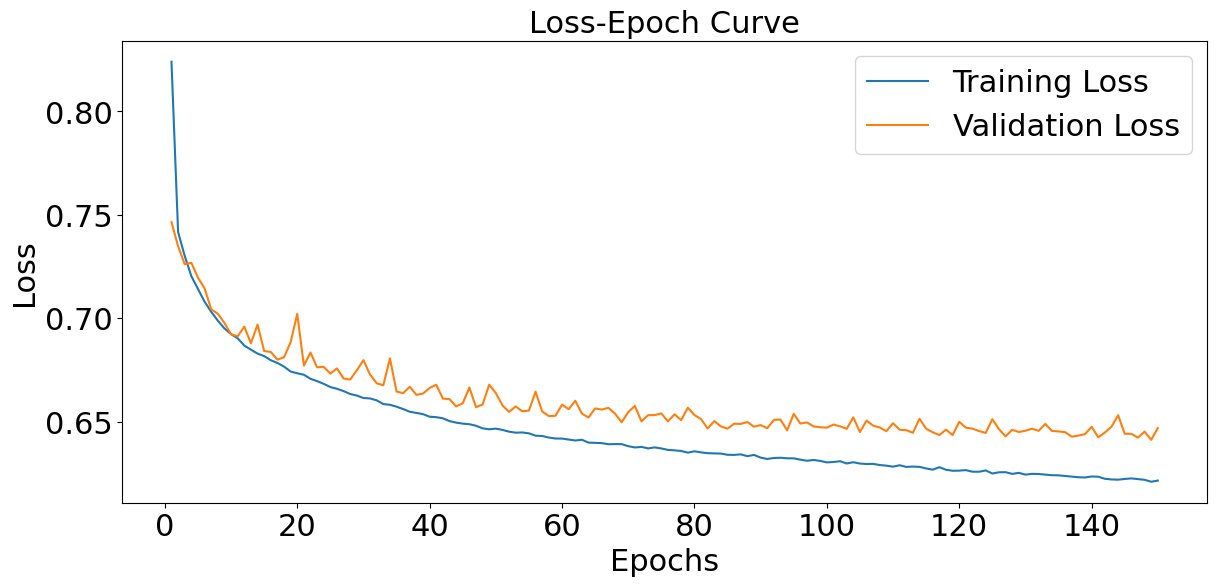

In [100]:

# Data scaling and label encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform (not fit_transform) on test data

label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Model for binary classification
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=16, kernel_constraint=MaxNorm(3)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Changed to 1 output neuron for binary classification

# Compile the model with BinaryCrossentropy loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()  # Changed to binary cross-entropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=150,
                        batch_size=128,
                        verbose=2)



# Loss and accuracy curves (train vs. validation)
epochs = range(1, len(history.history['loss']) + 1)

plt.rcParams.update({'font.size': 22, 'xtick.labelsize': 22, 'ytick.labelsize': 22})
# Plotting loss-epoch curve
plt.figure(figsize=(14, 6))
#plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss-Epoch Curve',fontsize= 22)
plt.xlabel('Epochs',fontsize= 22)
plt.ylabel('Loss',fontsize= 22)
plt.legend(fontsize= 22)

# Plotting accuracy-epoch curve
#plt.subplot(1, 2, 2)
#plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
#plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Accuracy-Epoch Curve',fontsize= 22)
#plt.xlabel('Epochs',fontsize= 22)
#plt.ylabel('Accuracy',fontsize= 22)
#plt.legend(fontsize= 22)

#plt.tight_layout()
plt.savefig('texas-epoch-curve.png', dpi=300, bbox_inches='tight')

plt.show()




3750/3750 [==============================] - 5s 1ms/step


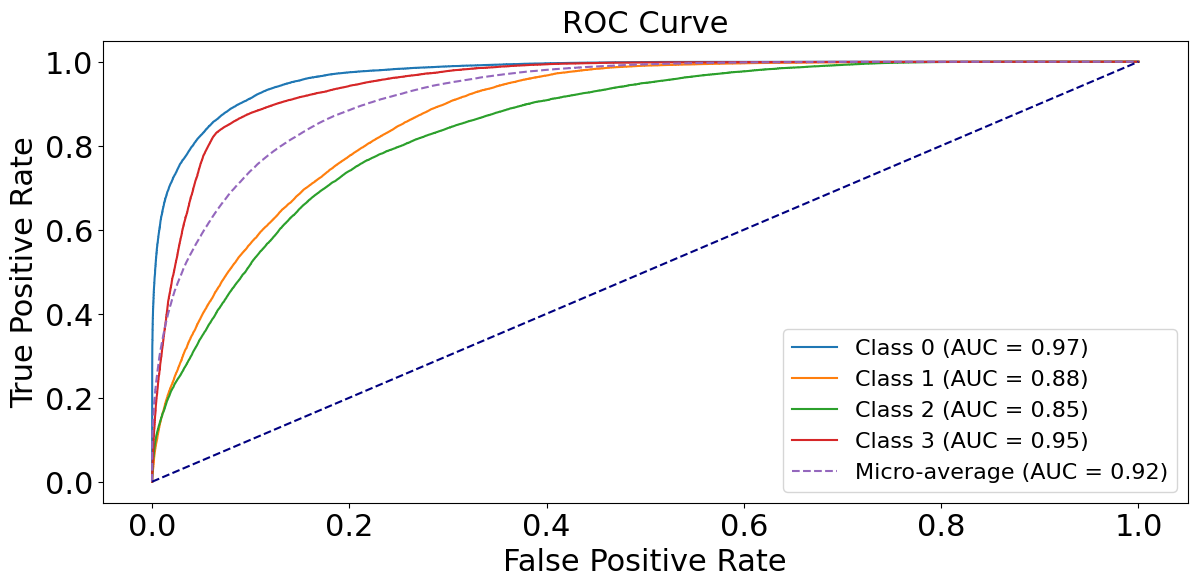

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Binarize the output for multiclass metrics
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2,3])  # Adjust for your classes
n_classes = y_test_binarized.shape[1]

# Initialize arrays to hold metrics
precision = dict()
recall = dict()
average_precision = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute metrics for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average precision and ROC AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
average_precision["micro"] = average_precision_score(y_test_binarized, y_pred_proba, average='micro')

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot Precision-Recall Curve
plt.figure(figsize=(14, 6))
#plt.subplot(1, 2, 1)
#for i in range(n_classes):
#    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')
#plt.plot(precision["micro"], recall["micro"], label='Micro-average (AP = {:.2f})'.format(average_precision["micro"]), linestyle='--')
#plt.xlabel('Recall', fontsize=22)
#plt.ylabel('Precision', fontsize=22)
#plt.title('Precision-Recall Curve', fontsize=22)
#plt.legend(loc='lower left', fontsize=16)

# Plot ROC Curve
#plt.subplot(1, 2, 2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (AUC = {:.2f})'.format(roc_auc["micro"]), linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC Curve', fontsize=22)
plt.legend(loc='lower right', fontsize=16)

#plt.tight_layout()
plt.savefig('texas-precision-roc-curve.png', dpi=300, bbox_inches='tight')
plt.show()


Epoch 1/30


/home/dgxuser49/.local/lib/python3.8/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 1: Gradient Norm = 3.0491
938/938 - 2s - loss: 0.6188 - accuracy: 0.7314 - 2s/epoch - 2ms/step
Epoch 2/30
Epoch 2: Gradient Norm = 3.3212
938/938 - 2s - loss: 0.6186 - accuracy: 0.7316 - 2s/epoch - 2ms/step
Epoch 3/30
Epoch 3: Gradient Norm = 3.1597
938/938 - 2s - loss: 0.6188 - accuracy: 0.7314 - 2s/epoch - 2ms/step
Epoch 4/30
Epoch 4: Gradient Norm = 2.8765
938/938 - 2s - loss: 0.6193 - accuracy: 0.7303 - 2s/epoch - 2ms/step
Epoch 5/30
Epoch 5: Gradient Norm = 3.2554
938/938 - 2s - loss: 0.6183 - accuracy: 0.7305 - 2s/epoch - 2ms/step
Epoch 6/30
Epoch 6: Gradient Norm = 2.8575
938/938 - 2s - loss: 0.6173 - accuracy: 0.7319 - 2s/epoch - 2ms/step
Epoch 7/30
Epoch 7: Gradient Norm = 2.6881
938/938 - 2s - loss: 0.6182 - accuracy: 0.7306 - 2s/epoch - 2ms/step
Epoch 8/30
Epoch 8: Gradient Norm = 3.1855
938/938 - 2s - loss: 0.6183 - accuracy: 0.7309 - 2s/epoch - 2ms/step
Epoch 9/30
Epoch 9: Gradient Norm = 4.1449
938/938 - 2s - loss: 0.6180 - accuracy: 0.7307 - 2s/epoch - 2ms/step
Epo

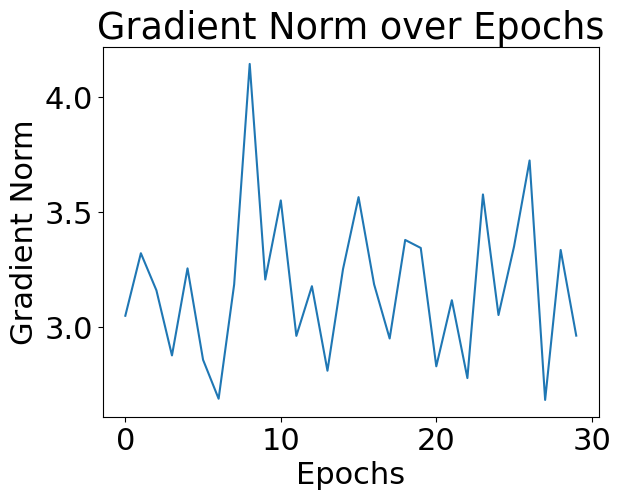

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L2 norm of gradients
def get_gradient_norm(model, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        # Use the loss function correctly
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        loss = loss_fn(targets, predictions)  # Correctly compute the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Compute the L2 norm of gradients
    norm = np.sum([np.linalg.norm(g.numpy()) for g in gradients if g is not None])
    return norm

# Callback to monitor gradient norms over training epochs
class GradientNormMonitor(tf.keras.callbacks.Callback):
    def __init__(self, inputs, targets):
        super().__init__()
        self.inputs = inputs
        self.targets = targets
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        norm = get_gradient_norm(self.model, self.inputs, self.targets)
        self.gradient_norms.append(norm)
        print(f'Epoch {epoch + 1}: Gradient Norm = {norm:.4f}')

    def plot_gradient_norms(self):
        plt.plot(self.gradient_norms)
        plt.title('Gradient Norm over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Gradient Norm')
        plt.savefig('texas-gradientnorm-curve.png', dpi=300, bbox_inches='tight')
        plt.show()

# Example usage during model training
# Assuming you have a dataset: (X_train, y_train)

# Subsample of data for gradient monitoring
inputs = X_train[:100]  
targets = y_train[:100]  

gradient_monitor = GradientNormMonitor(inputs, targets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile and train the model with the gradient monitor callback
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=128, verbose=2, callbacks=[gradient_monitor])

# Plot gradient norm after training
gradient_monitor.plot_gradient_norms()


3750/3750 - 6s - loss: 3.2427 - accuracy: 0.3307 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.0930 - accuracy: 0.3367 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 2.9807 - accuracy: 0.3423 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 2.9055 - accuracy: 0.3394 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 2.8717 - accuracy: 0.3331 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 2.8747 - accuracy: 0.3289 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 2.9110 - accuracy: 0.3262 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 2.9815 - accuracy: 0.3246 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.0828 - accuracy: 0.3235 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.2058 - accuracy: 0.3231 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.3433 - accuracy: 0.3230 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.4875 - accuracy: 0.3211 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.6337 - accuracy: 0.3185 - 6s/epoch - 2ms/step
3750/3750 - 6s - loss: 3.7864 - accuracy: 0.3159 - 6s/epoch - 2ms/step
3750/3

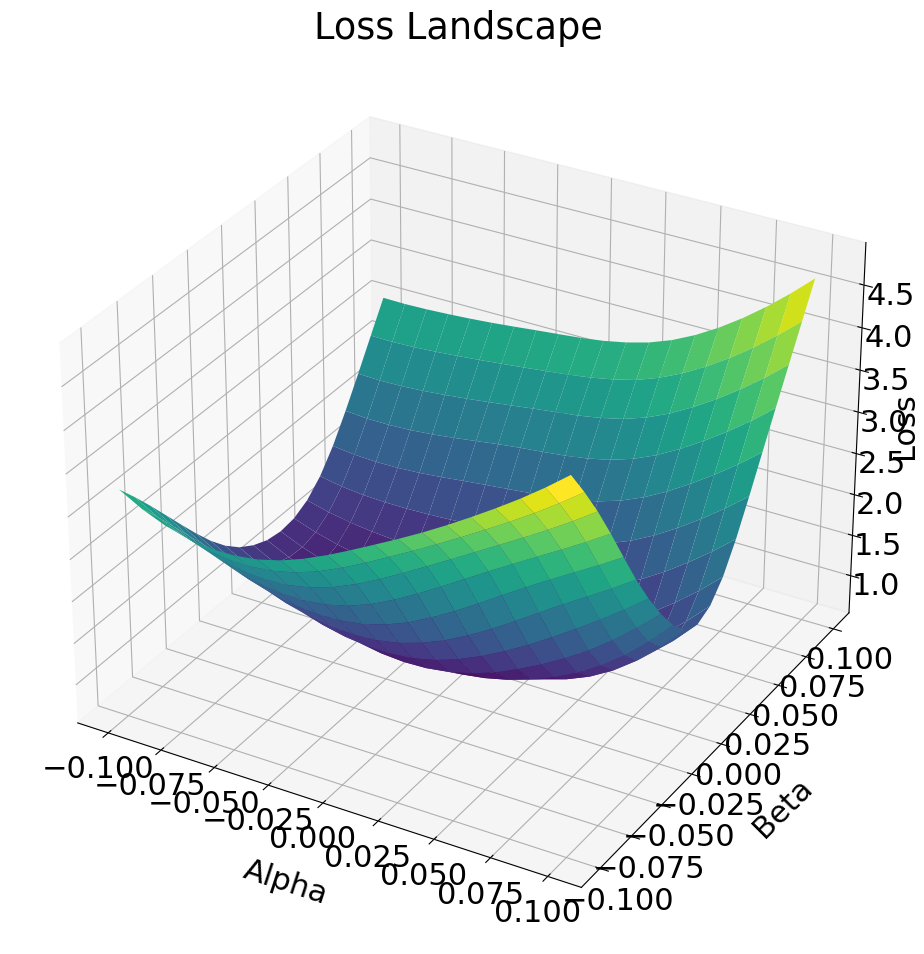

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to perturb model weights along a direction and compute loss
def perturb_and_compute_loss(model, X, y, direction1, direction2, alpha, beta):
    original_weights = model.get_weights()  # Store original weights
    perturbed_weights = []

    # Apply perturbation to the weights
    for i, weight in enumerate(original_weights):
        delta1 = direction1[i] * alpha
        delta2 = direction2[i] * beta
        perturbed_weights.append(weight + delta1 + delta2)

    model.set_weights(perturbed_weights)  # Update model weights
    loss = model.evaluate(X, y, verbose=2)[0]  # Compute loss
    model.set_weights(original_weights)  # Restore original weights
    return loss

# Function to generate random directions in parameter space
def generate_random_directions(model):
    directions = []
    for weight in model.get_weights():
        directions.append(np.random.randn(*weight.shape))
    return directions

# Function to plot the loss landscape
def plot_loss_landscape(model, X, y, alphas, betas):
    direction1 = generate_random_directions(model)
    direction2 = generate_random_directions(model)
    
    loss_values = np.zeros((len(alphas), len(betas)))

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            loss_values[i, j] = perturb_and_compute_loss(model, X, y, direction1, direction2, alpha, beta)

    # Plot the loss landscape as a 3D surface
    plt.figure(figsize=(10, 10))
    A, B = np.meshgrid(alphas, betas)
    ax = plt.axes(projection='3d')
    ax.xaxis.labelpad=20
    ax.yaxis.labelpad=20
    ax.zaxis.labelpad=0
    ax.plot_surface(A, B, loss_values, cmap='viridis')
    ax.set_title('Loss Landscape')
    ax.set_xlabel('Alpha', linespacing=3.2)
    ax.set_ylabel('Beta',rotation=45, linespacing=3.1)
    ax.set_zlabel('Loss',rotation=90, linespacing=1.0)
    plt.tight_layout()
    plt.savefig('texas-loss-landscape-curve-up.png', dpi=300, bbox_inches='tight')

    plt.show()

# Example usage
# Assuming you have a trained model, and X_train and y_train are your data
alphas = np.linspace(-0.1, 0.1, 20)  # Range of perturbations for direction 1
betas = np.linspace(-0.1, 0.1, 20)   # Range of perturbations for direction 2

# Assuming your model is already defined and compiled
plot_loss_landscape(model, X_train, y_train, alphas, betas)


In [108]:
dataset = pd.read_csv(r"UNSW_NB15_MIA.csv")
dataset = dataset.dropna()

dataset = dataset.drop(['sport', 'dsport', 'stcpb', 'dtcpb', 'Stime', 'Ltime', 'sbytes', 'dbytes', 'Sload', 'Dload'], axis=1)
dataset['proto'] = pd.Categorical(dataset['proto']).codes
dataset['state'] = pd.Categorical(dataset['state']).codes
dataset['service'] = pd.Categorical(dataset['service']).codes
dataset['attack_cat'] = pd.Categorical(dataset['attack_cat']).codes
ATTACK_CAT_MAP = {1:0,2:1,3:2,4:3, 5:4,6:5,7:6,8:7}
dataset['attack_cat'] = dataset['attack_cat'].replace(ATTACK_CAT_MAP)
dataset.head()

proto  state       dur  sttl  dttl  sloss  dloss  service  Spkts  Dpkts  \
0      0      1  0.240139    62   252      2     10        4     12     24   
1      0      1  2.390390   254   252      6      1        4     14      6   
2      0      1  0.190600   254   252      2      1        4     10      6   
3      0      1  0.177449   254   252      2      1        4     10      6   
4      0      1  0.291485    62   252      2      2        4     10      8   

   ...  is_ftp_login  ct_ftp_cmd  ct_srv_src  ct_srv_dst  ct_dst_ltm  \
0  ...             0           0           3           2           2   
1  ...             0           0           5           2           2   
2  ...             0           0           3           1           1   
3  ...             0           0           5           2           1   
4  ...             0           0           5           2           1   

   ct_src_ ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  attack_cat  
0            1                 1                 1               1           3  
1            1                 1                 1               1           5  
2            1                 1                 1               1           3  
3            1                 1                 1               1           2  
4            1                 1                 1               1           3  

[5 rows x 34 columns]

In [109]:
X = dataset.to_numpy()[:,:33]
y = dataset.to_numpy()[:,-1]
unique_values = np.unique(y)
print("Unique values:", unique_values)

Unique values: [0. 1. 2. 3. 4. 5. 6. 7.]


In [110]:
smote = PPSMOTE(k_neighbors=5, random_state=42)
#start_time = time.time()
X_train_3, y_train_3 = smote.oversample(X, y, 0.4, merge=True)
#end_time = time.time()

# Calculate runtime
#runtime_in_seconds = end_time - start_time
#print(f"PP-SMOTE resampling runtime: {runtime_in_seconds:.4f} seconds")

X_train_3.shape

(160768, 33)

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm
import tensorflow as tf


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_train_3, y_train_3, random_state=104, test_size=0.5, shuffle=True)

Epoch 1/150
628/628 - 2s - loss: 1.4940 - accuracy: 0.3986 - val_loss: 1.2086 - val_accuracy: 0.5530 - 2s/epoch - 4ms/step
Epoch 2/150
628/628 - 2s - loss: 1.0416 - accuracy: 0.5843 - val_loss: 0.9601 - val_accuracy: 0.5999 - 2s/epoch - 3ms/step
Epoch 3/150
628/628 - 2s - loss: 0.9117 - accuracy: 0.6221 - val_loss: 0.8942 - val_accuracy: 0.6263 - 2s/epoch - 3ms/step
Epoch 4/150
628/628 - 2s - loss: 0.8569 - accuracy: 0.6439 - val_loss: 0.8763 - val_accuracy: 0.6218 - 2s/epoch - 3ms/step
Epoch 5/150
628/628 - 2s - loss: 0.8196 - accuracy: 0.6608 - val_loss: 0.8053 - val_accuracy: 0.6607 - 2s/epoch - 3ms/step
Epoch 6/150
628/628 - 2s - loss: 0.7939 - accuracy: 0.6747 - val_loss: 0.7707 - val_accuracy: 0.6876 - 2s/epoch - 3ms/step
Epoch 7/150
628/628 - 2s - loss: 0.7687 - accuracy: 0.6872 - val_loss: 0.7426 - val_accuracy: 0.7167 - 2s/epoch - 3ms/step
Epoch 8/150
628/628 - 2s - loss: 0.7505 - accuracy: 0.7024 - val_loss: 0.7451 - val_accuracy: 0.6961 - 2s/epoch - 3ms/step
Epoch 9/150
628/

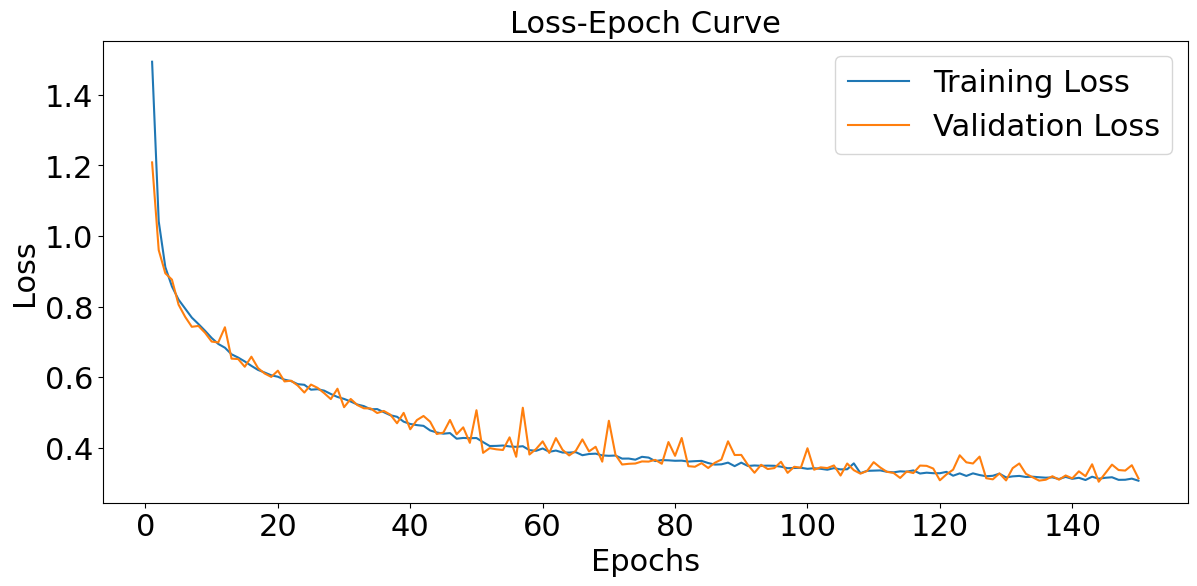

In [112]:

# Data scaling and label encoding
scaler = MinMaxScaler()
label_encoder = LabelEncoder()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform (not fit_transform) on test data

label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

# Model for binary classification
model = Sequential()
model.add(Dense(33, activation='relu', input_dim=33, kernel_constraint=MaxNorm(3)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='softmax'))  # Changed to 1 output neuron for binary classification

# Compile the model with BinaryCrossentropy loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()  # Changed to binary cross-entropy
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=150,
                        batch_size=128,
                        verbose=2)



# Loss and accuracy curves (train vs. validation)
epochs = range(1, len(history.history['loss']) + 1)

plt.rcParams.update({'font.size': 22, 'xtick.labelsize': 22, 'ytick.labelsize': 22})
# Plotting loss-epoch curve
plt.figure(figsize=(14, 6))
#plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss-Epoch Curve',fontsize= 22)
plt.xlabel('Epochs',fontsize= 22)
plt.ylabel('Loss',fontsize= 22)
plt.legend(fontsize= 22)

# Plotting accuracy-epoch curve
#plt.subplot(1, 2, 2)
#plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
#plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
#plt.title('Accuracy-Epoch Curve',fontsize= 22)
#plt.xlabel('Epochs',fontsize= 22)
#plt.ylabel('Accuracy',fontsize= 22)
#plt.legend(fontsize= 22)

#plt.tight_layout()
plt.savefig('unswnb15-epoch-curve-2.png', dpi=300, bbox_inches='tight')

plt.show()




2512/2512 - 4s - loss: 23.2005 - accuracy: 0.2235 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 20.6235 - accuracy: 0.2450 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 18.2672 - accuracy: 0.2571 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 15.8244 - accuracy: 0.2663 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 13.8728 - accuracy: 0.2774 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 12.3552 - accuracy: 0.2930 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 11.4829 - accuracy: 0.3190 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 12.4179 - accuracy: 0.3612 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 12.9244 - accuracy: 0.3813 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 12.7257 - accuracy: 0.4107 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 12.3637 - accuracy: 0.4096 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 12.1377 - accuracy: 0.3879 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 11.8667 - accuracy: 0.3814 - 4s/epoch - 2ms/step
2512/2512 - 4s - loss: 11.3128 - accuracy: 0.3531 - 4s/epoch - 2

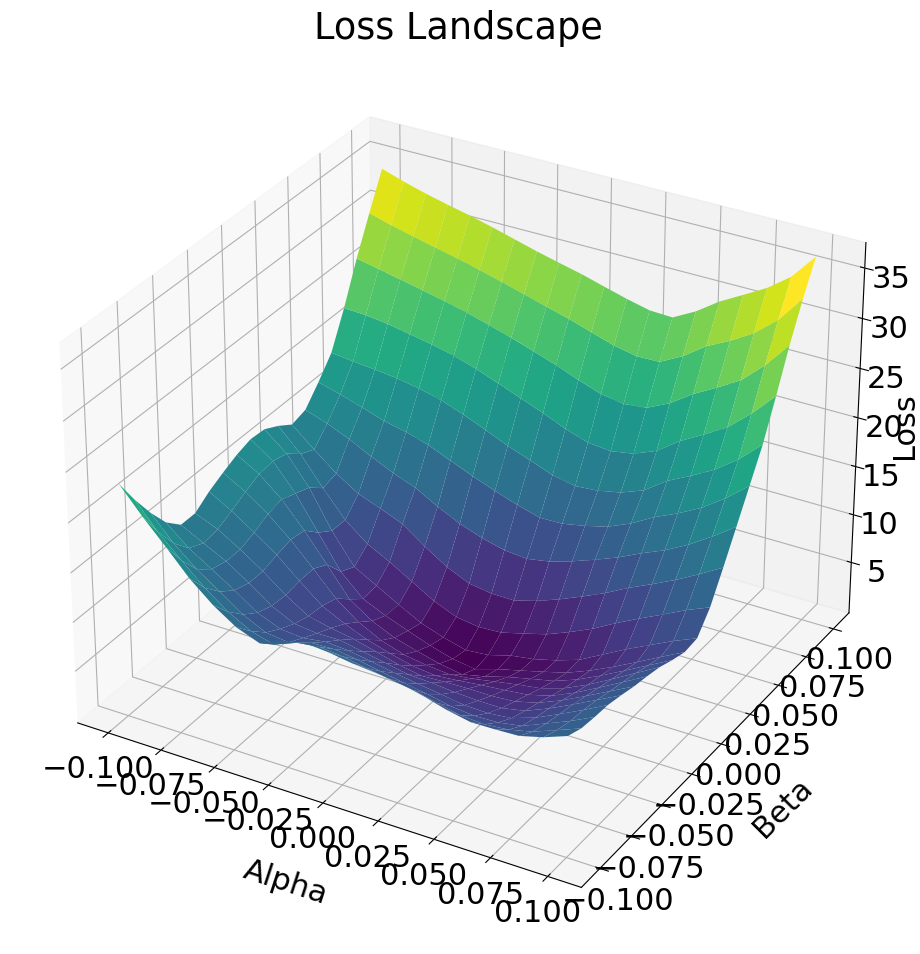

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to perturb model weights along a direction and compute loss
def perturb_and_compute_loss(model, X, y, direction1, direction2, alpha, beta):
    original_weights = model.get_weights()  # Store original weights
    perturbed_weights = []

    # Apply perturbation to the weights
    for i, weight in enumerate(original_weights):
        delta1 = direction1[i] * alpha
        delta2 = direction2[i] * beta
        perturbed_weights.append(weight + delta1 + delta2)

    model.set_weights(perturbed_weights)  # Update model weights
    loss = model.evaluate(X, y, verbose=2)[0]  # Compute loss
    model.set_weights(original_weights)  # Restore original weights
    return loss

# Function to generate random directions in parameter space
def generate_random_directions(model):
    directions = []
    for weight in model.get_weights():
        directions.append(np.random.randn(*weight.shape))
    return directions

# Function to plot the loss landscape
def plot_loss_landscape(model, X, y, alphas, betas):
    direction1 = generate_random_directions(model)
    direction2 = generate_random_directions(model)
    
    loss_values = np.zeros((len(alphas), len(betas)))

    for i, alpha in enumerate(alphas):
        for j, beta in enumerate(betas):
            loss_values[i, j] = perturb_and_compute_loss(model, X, y, direction1, direction2, alpha, beta)

    # Plot the loss landscape as a 3D surface
    plt.figure(figsize=(10, 10))
    A, B = np.meshgrid(alphas, betas)
    ax = plt.axes(projection='3d')
    ax.xaxis.labelpad=20
    ax.yaxis.labelpad=20
    ax.zaxis.labelpad=0
    ax.plot_surface(A, B, loss_values, cmap='viridis')
    ax.set_title('Loss Landscape')
    ax.set_xlabel('Alpha', linespacing=3.2)
    ax.set_ylabel('Beta',rotation=45, linespacing=3.1)
    ax.set_zlabel('Loss',rotation=90, linespacing=1.0)
    plt.tight_layout()
    plt.savefig('unswnb15-loss-landscape-curve-up.png', dpi=300, bbox_inches='tight')

    plt.show()

# Example usage
# Assuming you have a trained model, and X_train and y_train are your data
alphas = np.linspace(-0.1, 0.1, 20)  # Range of perturbations for direction 1
betas = np.linspace(-0.1, 0.1, 20)   # Range of perturbations for direction 2

# Assuming your model is already defined and compiled
plot_loss_landscape(model, X_train, y_train, alphas, betas)


Epoch 1/50
Epoch 1: Gradient Norm = 15.5831
628/628 - 2s - loss: 0.2952 - accuracy: 0.8985 - 2s/epoch - 2ms/step
Epoch 2/50
Epoch 2: Gradient Norm = 36.0364
628/628 - 1s - loss: 0.2962 - accuracy: 0.8985 - 1s/epoch - 2ms/step
Epoch 3/50
Epoch 3: Gradient Norm = 19.0899
628/628 - 1s - loss: 0.2977 - accuracy: 0.8970 - 1s/epoch - 2ms/step
Epoch 4/50
Epoch 4: Gradient Norm = 52.3028
628/628 - 1s - loss: 0.2944 - accuracy: 0.8985 - 1s/epoch - 2ms/step
Epoch 5/50
Epoch 5: Gradient Norm = 54.4880
628/628 - 1s - loss: 0.2913 - accuracy: 0.9003 - 1s/epoch - 2ms/step
Epoch 6/50
Epoch 6: Gradient Norm = 22.6790
628/628 - 1s - loss: 0.2946 - accuracy: 0.8982 - 1s/epoch - 2ms/step
Epoch 7/50
Epoch 7: Gradient Norm = 22.6073
628/628 - 1s - loss: 0.2950 - accuracy: 0.8984 - 1s/epoch - 2ms/step
Epoch 8/50
Epoch 8: Gradient Norm = 13.8843
628/628 - 1s - loss: 0.2973 - accuracy: 0.8965 - 1s/epoch - 2ms/step
Epoch 9/50
Epoch 9: Gradient Norm = 32.3554
628/628 - 1s - loss: 0.2975 - accuracy: 0.8967 - 1s/

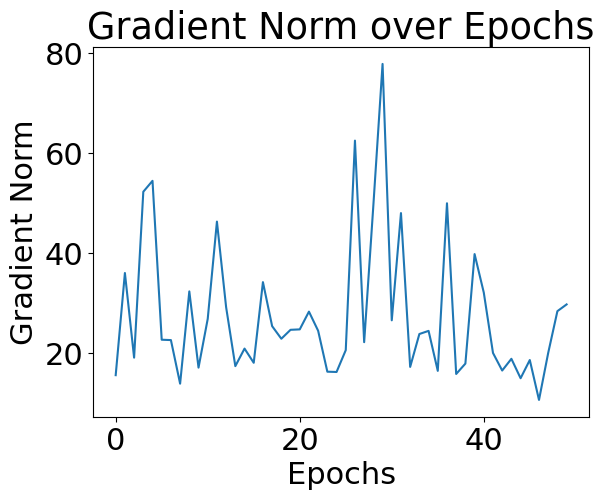

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to compute the L2 norm of gradients
def get_gradient_norm(model, inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        # Use the loss function correctly
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        loss = loss_fn(targets, predictions)  # Correctly compute the loss
    gradients = tape.gradient(loss, model.trainable_variables)
    # Compute the L2 norm of gradients
    norm = np.sum([np.linalg.norm(g.numpy()) for g in gradients if g is not None])
    return norm

# Callback to monitor gradient norms over training epochs
class GradientNormMonitor(tf.keras.callbacks.Callback):
    def __init__(self, inputs, targets):
        super().__init__()
        self.inputs = inputs
        self.targets = targets
        self.gradient_norms = []

    def on_epoch_end(self, epoch, logs=None):
        norm = get_gradient_norm(self.model, self.inputs, self.targets)
        self.gradient_norms.append(norm)
        print(f'Epoch {epoch + 1}: Gradient Norm = {norm:.4f}')

    def plot_gradient_norms(self):
        plt.plot(self.gradient_norms)
        plt.title('Gradient Norm over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Gradient Norm')
        plt.savefig('unsw15-gradientnorm-curve.png', dpi=300, bbox_inches='tight')
        plt.show()

# Example usage during model training
# Assuming you have a dataset: (X_train, y_train)

# Subsample of data for gradient monitoring
inputs = X_train[:100]  
targets = y_train[:100]  

gradient_monitor = GradientNormMonitor(inputs, targets)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile and train the model with the gradient monitor callback
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=128, verbose=2, callbacks=[gradient_monitor])

# Plot gradient norm after training
gradient_monitor.plot_gradient_norms()


2512/2512 [==============================] - 3s 1ms/step


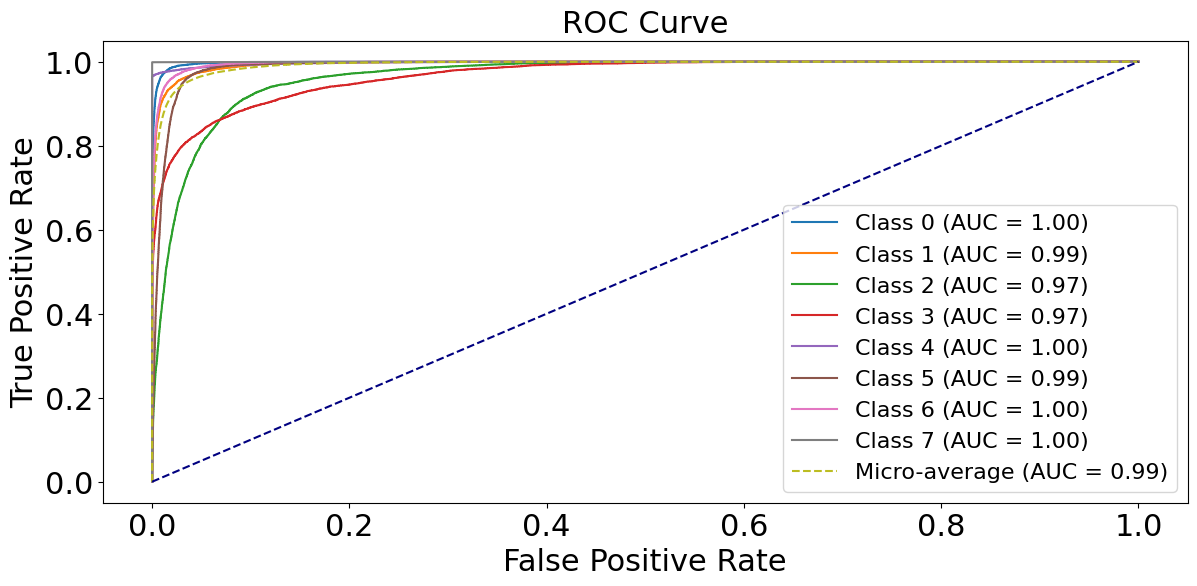

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Binarize the output for multiclass metrics
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2,3,4,5,6,7])  # Adjust for your classes
n_classes = y_test_binarized.shape[1]

# Initialize arrays to hold metrics
precision = dict()
recall = dict()
average_precision = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute metrics for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average precision and ROC AUC
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
average_precision["micro"] = average_precision_score(y_test_binarized, y_pred_proba, average='micro')

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.rcParams.update({'font.size': 22, 'xtick.labelsize': 22, 'ytick.labelsize': 22})
# Plot Precision-Recall Curve
plt.figure(figsize=(14, 6))
#plt.subplot(1, 2, 1)
#for i in range(n_classes):
#    plt.plot(recall[i], precision[i], label=f'Class {i} (AP = {average_precision[i]:.2f})')
#plt.plot(precision["micro"], recall["micro"], label='Micro-average (AP = {:.2f})'.format(average_precision["micro"]), linestyle='--')
#plt.xlabel('Recall', fontsize=22)
#plt.ylabel('Precision', fontsize=22)
#plt.title('Precision-Recall Curve', fontsize=22)
#plt.legend(loc='lower left', fontsize=16)

# Plot ROC Curve
#plt.subplot(1, 2, 2)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (AUC = {:.2f})'.format(roc_auc["micro"]), linestyle='--')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
plt.title('ROC Curve', fontsize=22)
plt.legend(loc='lower right', fontsize=16)

#plt.tight_layout()
plt.savefig('unsw15-precision-roc-curve.png', dpi=300, bbox_inches='tight')
plt.show()
